In [1]:
# Standard imports 

import os
import csv
import itertools  
import warnings
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import requests
from matplotlib.ticker import MaxNLocator
from scipy import linalg, stats
from scipy.linalg import svd
from scipy.stats import genextreme, norm, truncnorm, kstest
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

/Users/Uni/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# IMPORT + PREPARE DATA

In [2]:
def process_text_to_csv_from_url(input_url, output_csv_path, header_line=2):
    # Get the content from the URL
    response = requests.get(input_url)
    content = response.text.splitlines()

    # Calculate the starting line for data
    data_start_line = header_line + 1

    # Extract the header from the specified header line
    header = content[header_line].strip().split()

    # Write the content starting from the data start line to a CSV file
    with open(output_csv_path, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',')
        csvwriter.writerow(header)  # Write the header
        for line in content[data_start_line:]:
            row = line.strip().split()
            csvwriter.writerow(row)

    # Read the CSV file into a DataFrame
    data_frame = pd.read_csv(output_csv_path)

    return data_frame

# Import our datasets

deaths_data = process_text_to_csv_from_url(
    'https://raw.githubusercontent.com/gg321321/Dissertation-277165-Final/main/Deaths_1x1.txt', 
    '/Users/Uni/Desktop/Deaths_1x1.csv'
)
exposures_data = process_text_to_csv_from_url(
    'https://raw.githubusercontent.com/gg321321/Dissertation-277165-Final/main/Exposures_1x1.txt', 
    '/Users/Uni/Desktop/Exposures_1x1.csv'
)
population_data = process_text_to_csv_from_url(
    'https://raw.githubusercontent.com/gg321321/Dissertation-277165-Final/main/Population.txt', 
    '/Users/Uni/Desktop/Population.csv'
)

In [3]:
# Exposures dataframe contains the year 2022 when the other 2 dataframes do not, so remove year 2022

# Drop all rows where the 'Year' column is 2022 using loc to avoid future errors
population_data = population_data.loc[population_data['Year'] != 2022].copy()

In [4]:
# Rename columns in each dataframe
deaths_data.rename(columns={'Female': 'female_deaths', 'Male': 'male_deaths', 'Total': 'total_deaths'}, inplace=True)
population_data.rename(columns={'Female': 'female_population', 'Male': 'male_population', 'Total': 'total_population'}, inplace=True)
exposures_data.rename(columns={'Female': 'female_exposures', 'Male': 'male_exposures', 'Total': 'total_exposures'}, inplace=True)

In [5]:
common_columns = ['Year', 'Age'] # Identify common columns

# Merge the deaths and population dataframe
df = pd.merge(deaths_data, population_data, on=common_columns, how='outer', suffixes=('_deaths', '_population'))

# Merge the resulting dataframe with the exposure dataframe
df = pd.merge(df, exposures_data, on=common_columns, how='outer', suffixes=('', '_exposure'))

In [6]:
# Create a mask for rows where the total population is zero
mask_zero_population = (df['total_population'] == 0)

# Drop rows where the mask is True
df = df[~mask_zero_population]

In [7]:
# Step 1: Calculate the mortality rate for both genders and the total population
df['total_mortality_rate'] = df['total_deaths'] / df['total_population']
df['male_mortality_rate'] = df['male_deaths'] / df['male_population']
df['female_mortality_rate'] = df['female_deaths'] / df['female_population']

# Clean errors for which mortality rate > 1
df['total_mortality_rate'] = df['total_mortality_rate'].clip(upper=1.0)
df['male_mortality_rate'] = df['male_mortality_rate'].clip(upper=1.0)
df['female_mortality_rate'] = df['female_mortality_rate'].clip(upper=1.0)

# Step 2: Clean the Age Data - Handle non-numeric value "110+"
df['Age'] = df['Age'].replace('110+', 110)
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Drop rows where Age is NaN
df = df.dropna(subset=['Age'])

# Step 2: Define age groups and labels for visualization
age_groups = [(0, 12), (13, 18), (19, 30), (31, 49), (50, 65), (66, np.inf)]
age_labels = ['0-12', '13-18', '19-30', '31-49', '50-65', '66+']

# Compute average mortality rates for age groups
average_mortality_rates_total = np.zeros((len(age_labels), len(df['Year'].unique())))
average_mortality_rates_male = np.zeros((len(age_labels), len(df['Year'].unique())))
average_mortality_rates_female = np.zeros((len(age_labels), len(df['Year'].unique())))

for i, (start, end) in enumerate(age_groups):
    for j, year in enumerate(df['Year'].unique()):
        age_group_data_total = df[(df['Age'] >= start) & (df['Age'] < end) & (df['Year'] == year)]
        age_group_data_male = df[(df['Age'] >= start) & (df['Age'] < end) & (df['Year'] == year)]
        age_group_data_female = df[(df['Age'] >= start) & (df['Age'] < end) & (df['Year'] == year)]
        
        if not age_group_data_total.empty:
            average_mortality_rates_total[i, j] = age_group_data_total['total_mortality_rate'].mean()
        else:
            average_mortality_rates_total[i, j] = np.nan  # Assign NaN if no data is available
        
        if not age_group_data_male.empty:
            average_mortality_rates_male[i, j] = age_group_data_male['male_mortality_rate'].mean()
        else:
            average_mortality_rates_male[i, j] = np.nan  # Assign NaN if no data is available
        
        if not age_group_data_female.empty:
            average_mortality_rates_female[i, j] = age_group_data_female['female_mortality_rate'].mean()
        else:
            average_mortality_rates_female[i, j] = np.nan  # Assign NaN if no data is available

years = df['Year'].unique()
mid_year_index = len(years) // 2  # Select a mid-range year

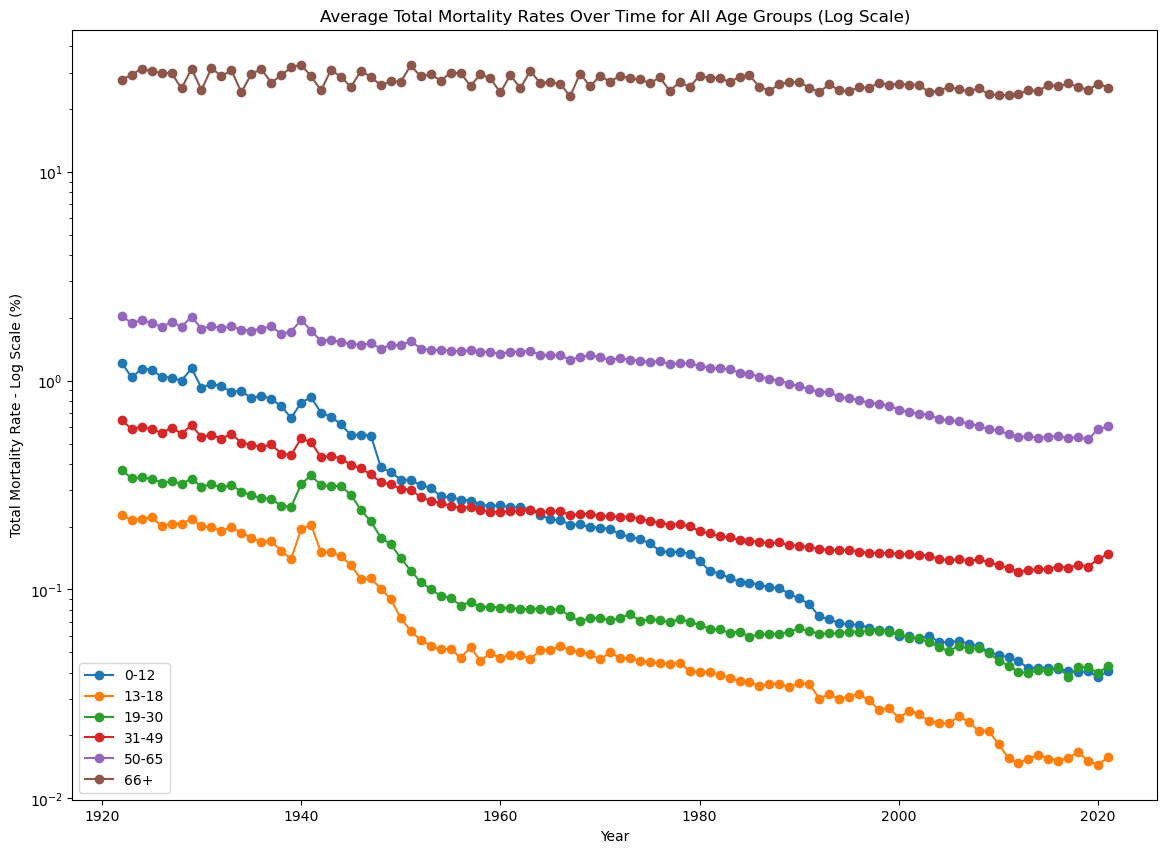

In [8]:
plt.figure(figsize=(14, 10))

# Plot total mortality rates over time for all age groups with a logarithmic scale
for i, label in enumerate(age_labels):
    plt.plot(years, 100 * average_mortality_rates_total[i, :], '-o', label=label)
plt.xlabel('Year')
plt.ylabel('Total Mortality Rate - Log Scale (%)')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Average Total Mortality Rates Over Time for All Age Groups (Log Scale)')
plt.show()

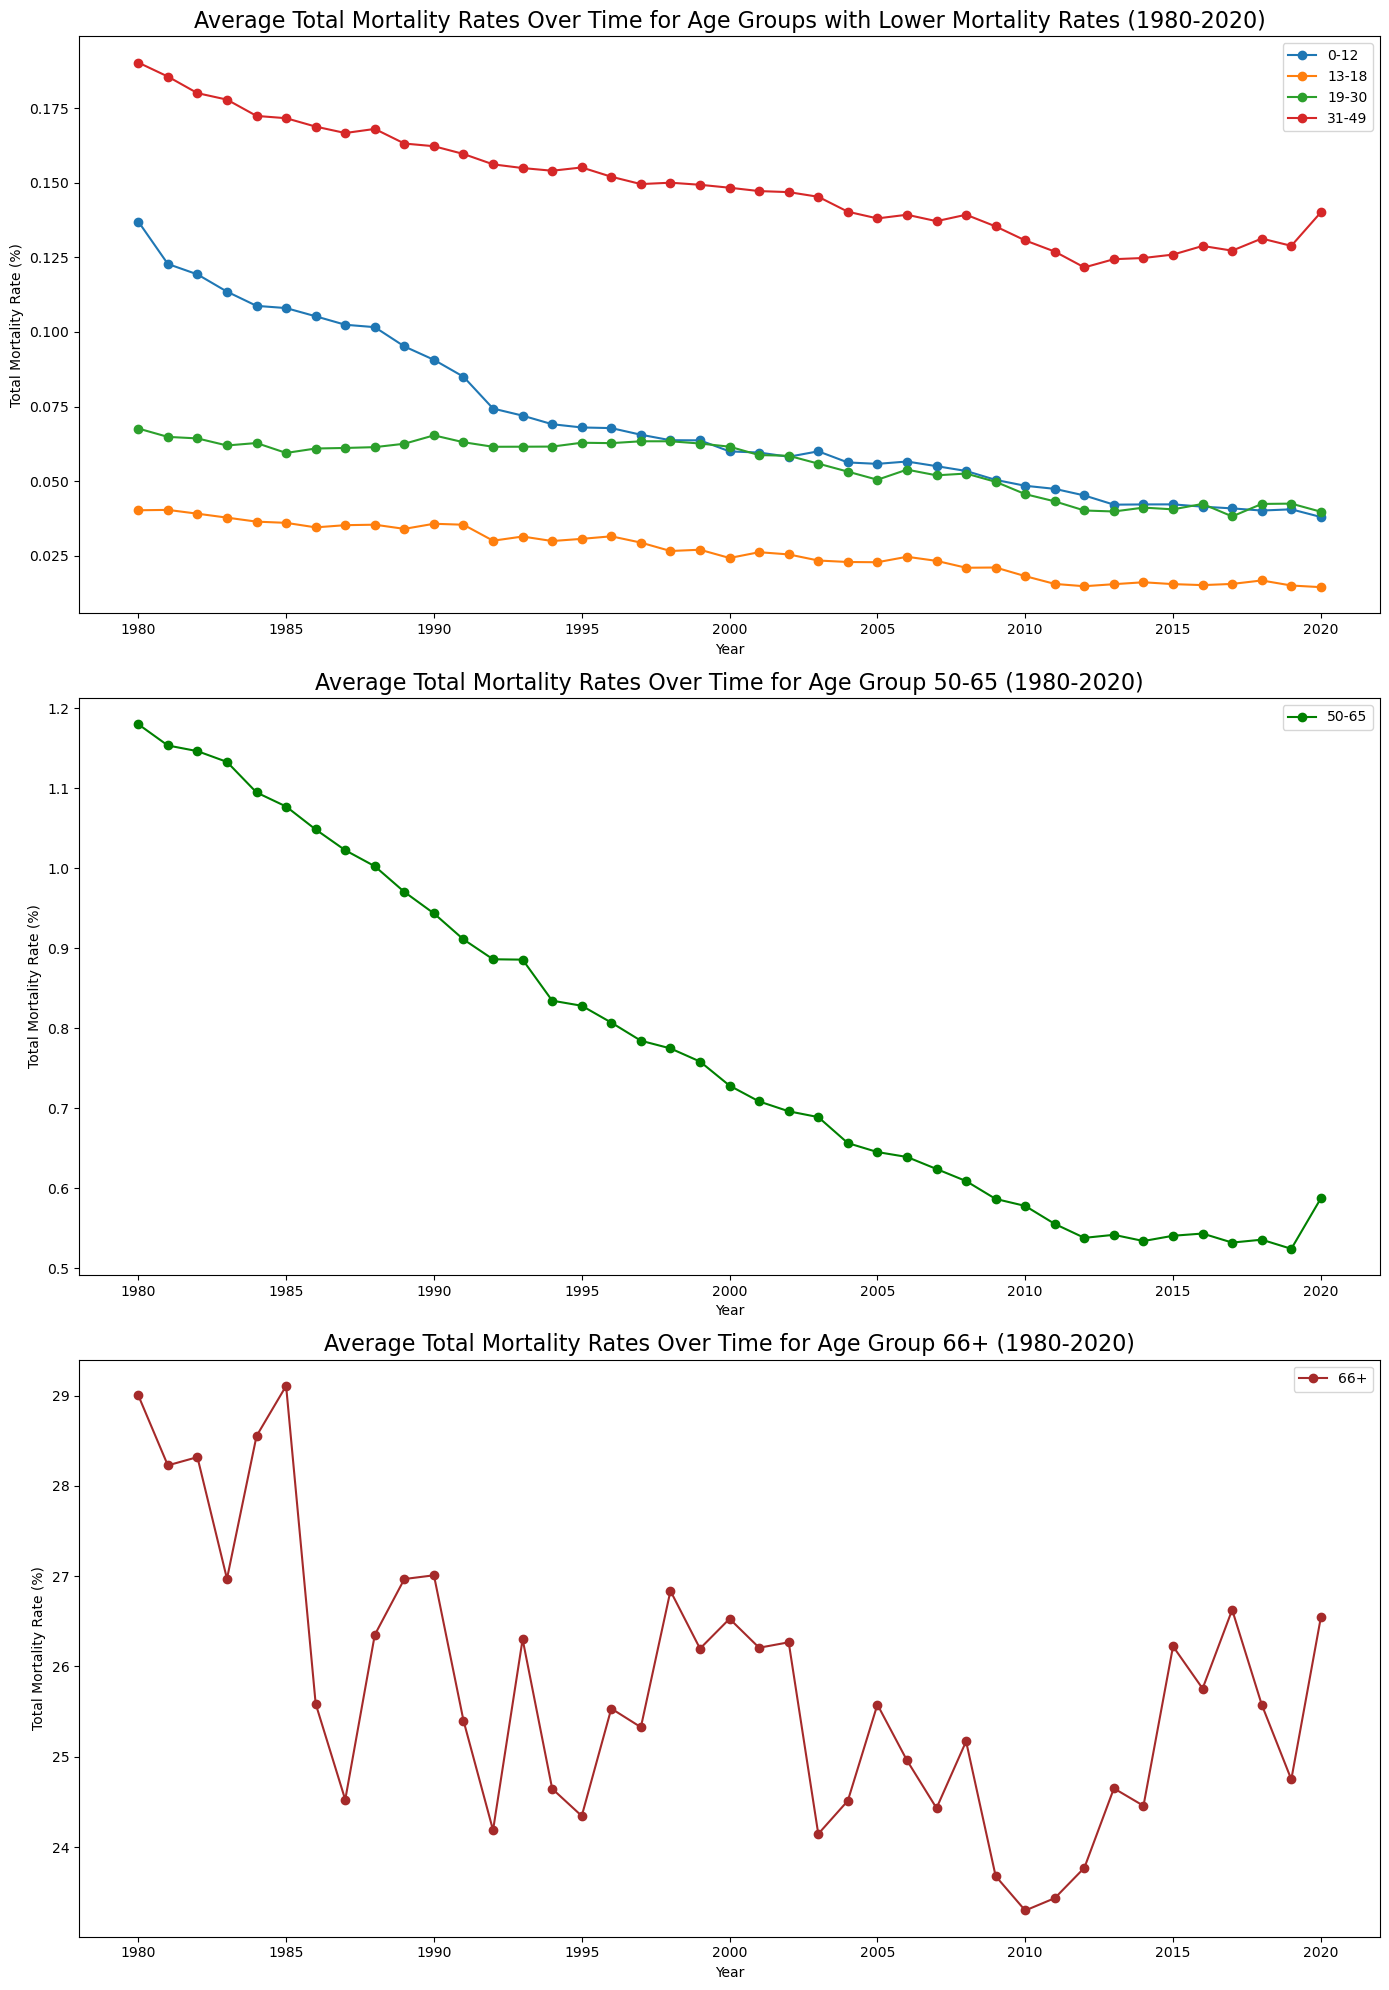

In [9]:
# Filter years from 1980 to 2020
filtered_years = [year for year in years if 1980 <= year <= 2020]
filtered_year_indices = [i for i, year in enumerate(years) if 1980 <= year <= 2020]

fig, axs = plt.subplots(3, 1, figsize=(14, 20))

# Plot total mortality rates over time for age groups with lower mortality rates
for i, label in enumerate(age_labels[:-2]):
    axs[0].plot(filtered_years, 100 * average_mortality_rates_total[i, filtered_year_indices], '-o', label=label)
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Total Mortality Rate (%)')
axs[0].set_title('Average Total Mortality Rates Over Time for Age Groups with Lower Mortality Rates (1980-2020)', fontsize=16)
axs[0].legend(loc='best')

# Plot total mortality rates over time for age group 50-65
axs[1].plot(filtered_years, 100 * average_mortality_rates_total[-2, filtered_year_indices], '-o', label=age_labels[-2], color='green')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Total Mortality Rate (%)')
axs[1].set_title('Average Total Mortality Rates Over Time for Age Group 50-65 (1980-2020)', fontsize=16)
axs[1].legend(loc='best')

# Plot total mortality rates over time for age group 66+
axs[2].plot(filtered_years, 100 * average_mortality_rates_total[-1, filtered_year_indices], '-o', label=age_labels[-1], color='brown')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Total Mortality Rate (%)')
axs[2].set_title('Average Total Mortality Rates Over Time for Age Group 66+ (1980-2020)', fontsize=16)
axs[2].legend(loc='best')

plt.tight_layout()

plt.show()

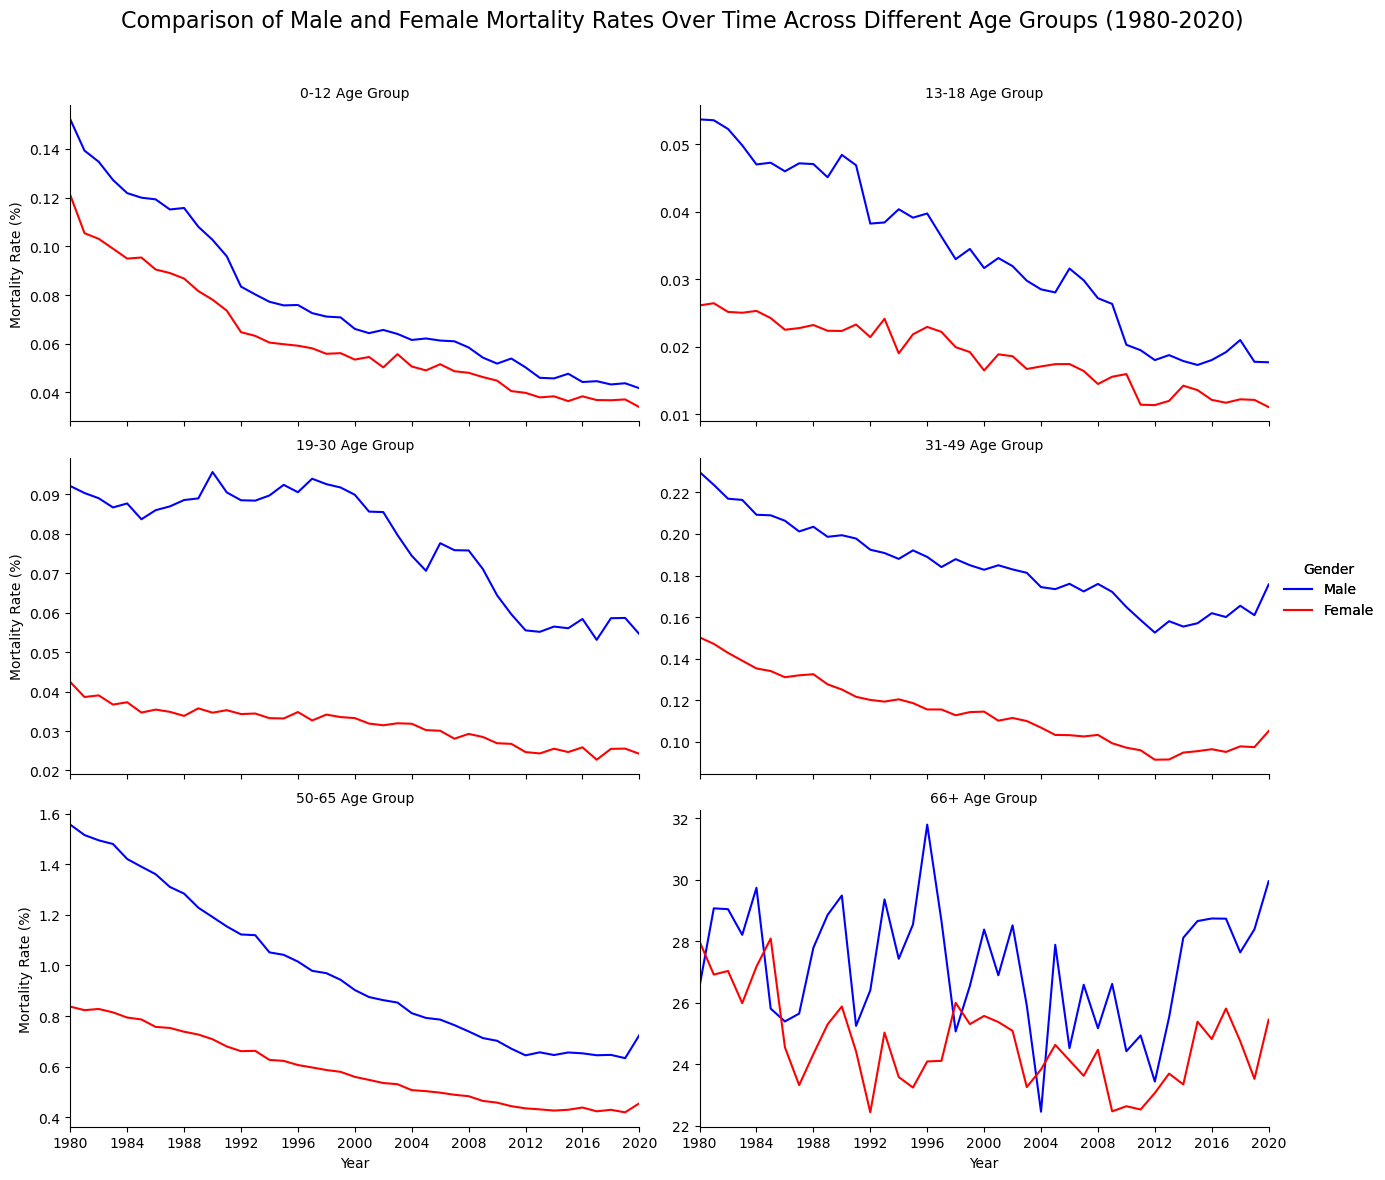

In [10]:
# Combine data for male and female mortality rates into a single DataFrame for plotting
mortality_data = []

for i, label in enumerate(age_labels):
    for year in filtered_years:
        mortality_data.append({'Year': year, 'Age Group': label, 'Gender': 'Male', 'Mortality Rate': 100 * average_mortality_rates_male[i, np.searchsorted(years, year)]})
        mortality_data.append({'Year': year, 'Age Group': label, 'Gender': 'Female', 'Mortality Rate': 100 * average_mortality_rates_female[i, np.searchsorted(years, year)]})

mortality_df = pd.DataFrame(mortality_data)

# Line plots
g = sns.FacetGrid(mortality_df, col="Age Group", hue="Gender", col_wrap=2, height=4, aspect=1.5, sharey=False)
g = g.map(plt.plot, "Year", "Mortality Rate").add_legend()
g.set_titles(col_template="{col_name} Age Group")
g.set_axis_labels("Year", "Mortality Rate (%)")
g.set(xlim=(1980, 2020))

# Set colors to blue for males and red for females
for ax in g.axes.flat:
    for line in ax.lines:
        if line.get_label() == 'Male':
            line.set_color('blue')
        elif line.get_label() == 'Female':
            line.set_color('red')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Update the legend with correct colors
handles, labels = ax.get_legend_handles_labels()
new_handles = [plt.Line2D([], [], color='blue', label='Male'),
               plt.Line2D([], [], color='red', label='Female')]
g.add_legend(handles=new_handles)

# Add a grand title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Comparison of Male and Female Mortality Rates Over Time Across Different Age Groups (1980-2020)', fontsize=16)

plt.show()

In [11]:
df_copy = df.copy() # Create a copy of the dataframe

# Convert 'Age' to numeric, replacing '110+' with 110
df_copy['Age'] = pd.to_numeric(df_copy['Age'].replace('110+', 110), errors='coerce')

# Create age groups on the copy
df_copy['Age_Group'] = pd.cut(df_copy['Age'], bins=[0, 12, 18, 30, 49, 65, np.inf], 
                              labels=['0-12', '13-18', '19-30', '31-49', '50-65', '66+'])

# Calculate summary statistics
summary_stats = df_copy.groupby('Age_Group')['total_mortality_rate'].agg(['mean', 'median', 'std', 'min', 'max'])
summary_stats = summary_stats * 100  # Convert to percentage

print("Summary Statistics of Mortality Rates by Age Group:")
print(summary_stats)

Summary Statistics of Mortality Rates by Age Group:
                mean     median        std       min         max
Age_Group                                                       
0-12        0.111839   0.035712   0.238963  0.003988    2.563071
13-18       0.080890   0.050860   0.073601  0.008353    0.296144
19-30       0.132054   0.073884   0.108681  0.030217    0.419832
31-49       0.287431   0.223905   0.202077  0.054129    1.111939
50-65       1.285172   1.099878   0.738315  0.263930    4.015202
66+        27.139655  18.267561  25.371578  0.000000  100.000000


# MODEL APPLICATION

In [12]:
# Define the periods for two-step forecasting
period1_start, period1_end = 1980, 1999
period2_start, period2_end = 1980, 2010
period3_start, period3_end = 1980, 2020

# Filter data for each period
df_period1 = df[(df['Year'] >= period1_start) & (df['Year'] <= period1_end)]
df_period2 = df[(df['Year'] >= period2_start) & (df['Year'] <= period2_end)]
df_period3 = df[(df['Year'] >= period3_start) & (df['Year'] <= period3_end)]

In [13]:
# Function to fit the Lee-Carter model and return the components
def fit_lee_carter(df):
   # Step 1: Initialise the Mortality matrix (pivot the data to have Age groups as rows and Years as columns)
    mortality_matrix = df.pivot(index='Age', columns='Year', values='total_mortality_rate').values

    # Step 2: Replace zeros with a small positive value and handle NaNs
    mortality_matrix[mortality_matrix == 0] = np.nan
    mortality_matrix = np.where(np.isnan(mortality_matrix), np.nanmean(mortality_matrix, axis=1)[:, np.newaxis], mortality_matrix)

    # Step 3: Define T, the number of years
    T = mortality_matrix.shape[1]

    # Step 4: Calculate the estimator for the age-specific pattern of mortality coefficient, a_hat
    a_hat = np.mean(np.log(mortality_matrix), axis=1)

    # Step 5: Define matrix Z
    Z = np.log(mortality_matrix) - a_hat[:, np.newaxis]

    # Step 6: Apply SVD to Z
    U, S, Vt = svd(Z, full_matrices=False)

    # Step 8: Solve for estimates b_hat and k_hat
    b_hat = -U[:, 0]
    sum_b_hat = np.sum(b_hat)
    b_hat = b_hat / sum_b_hat
    k_hat = -sum_b_hat * S[0] * Vt[0, :]

    return a_hat, b_hat, k_hat

In [14]:
def plot_parameters(age_groups, a_hat, b_hat, years, k_hat):
    
    plt.figure(figsize=(15, 5))

    # Plot for a_x
    plt.subplot(1, 3, 1)
    plt.scatter(age_groups, a_hat, marker='o', s=10)
    plt.xlabel('Age Groups')
    plt.ylabel('$a_x$')
    plt.title('Average Age-Specific Component ($a_x$)')

    # Plot for b_x
    plt.subplot(1, 3, 2)
    plt.scatter(age_groups, b_hat, marker='o', s=10)
    plt.xlabel('Age Groups')
    plt.ylabel('$b_x$')
    plt.title('First Singular Vector ($b_x$)')

    # Plot for k_t
    plt.subplot(1, 3, 3)
    plt.scatter(years, k_hat, marker='o', s=10)
    plt.xlabel('Years')
    plt.ylabel('$k_t$')
    plt.title('Time Component ($k_t$)')
    plt.xticks(range(min(years), max(years)+1, 3))  # Show only whole numbers for years

    plt.tight_layout()
    plt.show()

In [15]:
def perform_and_print_stationarity_tests(series):
    def adf_test(series, lags):
        results = {}
        for lag in lags:
            result = adfuller(series, maxlag=lag, regression='c', autolag=None)
            results[f'lag_{lag}'] = {'ADF Statistic': result[0], 'p-value': result[1]}
        return results

    # Lags to be used in the ADF tests
    lags = [0, 1, 2]
    
    # Calculate differences of the series
    series_diff = np.diff(series)
    series_diff_2 = np.diff(series_diff)
    series_diff_3 = np.diff(series_diff_2)

    # Perform ADF tests
    adf_results = {
        'original': adf_test(series, lags),
        'first_diff': adf_test(series_diff, lags),
        'second_diff': adf_test(series_diff_2, lags),
        'third_diff': adf_test(series_diff_3, lags)
    }

    # Print the ADF test results
    for diff_label, results in adf_results.items():
        print(f"\nADF Test Results for {diff_label} of the series:")
        for lag, result in results.items():
            print(f"  Lag {lag}: ADF Statistic = {result['ADF Statistic']:.4f}, p-value = {result['p-value']:.4f}")

    # Determine the differencing order
    if all(res['p-value'] < 0.05 for res in adf_results['original'].values()):
        d = 0
    elif all(res['p-value'] < 0.05 for res in adf_results['first_diff'].values()):
        d = 1
    elif all(res['p-value'] < 0.05 for res in adf_results['second_diff'].values()):
        d = 2
    elif all(res['p-value'] < 0.05 for res in adf_results['third_diff'].values()):
        d = 3
    else:
        d = None

    print(f"\nDetermined differencing order: d = {d}")
    return d

In [16]:
def plot_acf_pacf(series, d, subtract_lags=1, max_lags=None):
   
    # Determine the maximum number of lags based on sample size
    if max_lags is None:
        max_lags_value = len(series) // 2 - 1
        max_lags = max_lags_value - subtract_lags

    # Determine which series to plot based on differencing order
    if d == 0:
        series_to_plot = series
    elif d == 1:
        series_to_plot = np.diff(series)
    else:
        series_to_plot = np.diff(np.diff(series))

    # Plot ACF and PACF
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plot_acf(series_to_plot, lags=max_lags, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')
    plt.subplot(2, 1, 2)
    plot_pacf(series_to_plot, lags=max_lags, ax=plt.gca())
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.tight_layout()
    plt.show()

In [17]:
def find_best_arima_model(series, d, p_range, q_range):
   
    pdq = list(itertools.product(p_range, [d], q_range))

    best_aic = float("inf")
    best_pdq = None
    best_model = None

    for param in pdq:
        try:
            model = ARIMA(series, order=param)
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_pdq = param
                best_model = model
        except Exception as e:
            print(f"An error occurred for ARIMA{param}: {e}")
            continue

    print(f"Best ARIMA model: {best_pdq} with AIC: {best_aic}")

    # Fit the best model
    if best_model:
        best_model_fit = best_model.fit()
        return best_pdq, best_aic, best_model_fit
    else:
        return None, None, None

In [18]:
def plot_model_fit_and_residuals(years, series, model_fit):
   
    # Compute residuals for the best model
    residuals = model_fit.resid

    # Plot the model fit and residuals
    plt.figure(figsize=(10, 15))

    # Plot the original series and the ARIMA fit
    plt.subplot(2, 1, 1)
    plt.plot(years, series, label='$k_t$')
    plt.plot(years, series - residuals, label='ARIMA Fit')
    plt.legend()
    plt.xlabel('Years')
    plt.ylabel('Mortality Index')
    plt.title('Model Fit for 1980-2000')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot the residuals
    plt.subplot(2, 1, 2)
    plt.plot(years, residuals, label='Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Years')
    plt.ylabel('Residuals')
    plt.title('Residual Plot for 1980-2000')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

In [19]:
def apply_lee_carter_forecast(df, start_year=1980, end_year=2010, train_end_year=2000, arima_order=(1, 2, 1), forecast_steps=10):
    
    # Step 1: Apply Lee-Carter to full period
    df_full = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]
    a_hat_full, b_hat_full, k_hat_full = fit_lee_carter(df_full)
    years_full = df_full['Year'].unique()

    # Step 2: Extract training period (1980-2000) from full results
    train_end_index = np.where(years_full == train_end_year)[0][0]
    k_hat_train = k_hat_full[:train_end_index + 1]
    years_train = years_full[:train_end_index + 1]

    # Step 3: Fit ARIMA model to k_hat_train
    model = ARIMA(k_hat_train, order=arima_order)
    model_fit = model.fit()

    # Step 4: Forecast for the remaining period
    forecast_k_hat = model_fit.forecast(steps=forecast_steps)
    years_forecast = np.arange(train_end_year + 1, end_year + 1)

    # Step 5: Extract actual k_hat for the forecast period
    actual_k_hat_forecast_period = k_hat_full[train_end_index + 1:]

    # Step 6: Calculate MSE and MAE
    mse = np.mean((forecast_k_hat - actual_k_hat_forecast_period) ** 2)
    mae = np.mean(np.abs(forecast_k_hat - actual_k_hat_forecast_period))

    # Print MSE and MAE
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot full actual data
    plt.plot(years_full, k_hat_full, color='green', label='Actual 1980-2010')

    # Plot training data
    plt.plot(years_train, k_hat_train, color='blue', label='Actual 1980-2000 (Training)')

    # Plot forecast
    plt.plot(years_forecast, forecast_k_hat, color='orange', label='Forecast 2001-2010')

    plt.axvline(x=train_end_year, color='red', linestyle='--', label=f'Forecast Start ({train_end_year + 1})')
    plt.legend()
    plt.title('Actual vs Forecasted k_hat (1980-2010)')
    plt.xlabel('Year')
    plt.ylabel('k_hat')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# PERIOD 1

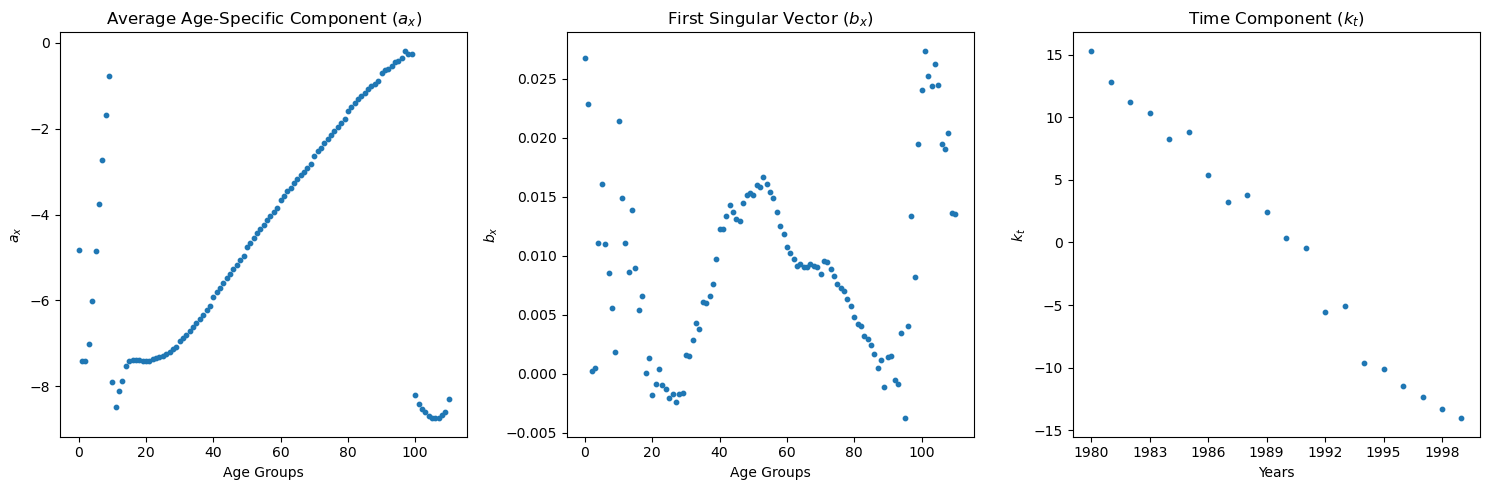


ADF Test Results for original of the series:
  Lag lag_0: ADF Statistic = -0.6673, p-value = 0.8550
  Lag lag_1: ADF Statistic = -0.3947, p-value = 0.9110
  Lag lag_2: ADF Statistic = -0.2160, p-value = 0.9366

ADF Test Results for first_diff of the series:
  Lag lag_0: ADF Statistic = -7.4023, p-value = 0.0000
  Lag lag_1: ADF Statistic = -3.3670, p-value = 0.0121
  Lag lag_2: ADF Statistic = -1.9040, p-value = 0.3302

ADF Test Results for second_diff of the series:
  Lag lag_0: ADF Statistic = -10.7987, p-value = 0.0000
  Lag lag_1: ADF Statistic = -6.1546, p-value = 0.0000
  Lag lag_2: ADF Statistic = -3.1066, p-value = 0.0261

ADF Test Results for third_diff of the series:
  Lag lag_0: ADF Statistic = -12.2334, p-value = 0.0000
  Lag lag_1: ADF Statistic = -8.1759, p-value = 0.0000
  Lag lag_2: ADF Statistic = -4.4025, p-value = 0.0003

Determined differencing order: d = 2


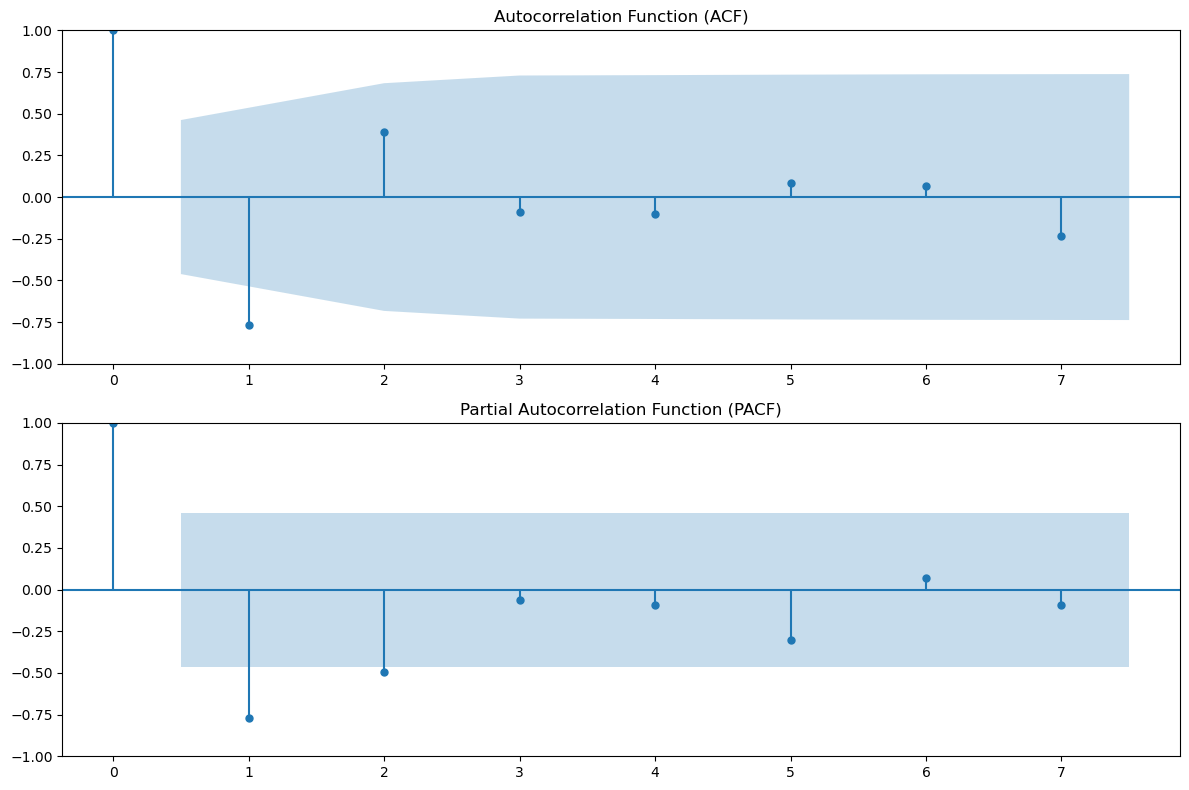

In [20]:
# First period model fitting

a_hat1, b_hat1, k_hat1 = fit_lee_carter(df_period1)
years1 = df_period1['Year'].unique()
age_groups1 = df_period1['Age'].unique()

plot_parameters(age_groups1, a_hat1, b_hat1, years1, k_hat1)

differencing_order = perform_and_print_stationarity_tests(k_hat1)

plot_acf_pacf(k_hat1, differencing_order, subtract_lags=2)

Best ARIMA model: (1, 2, 1) with AIC: 70.49313906587997


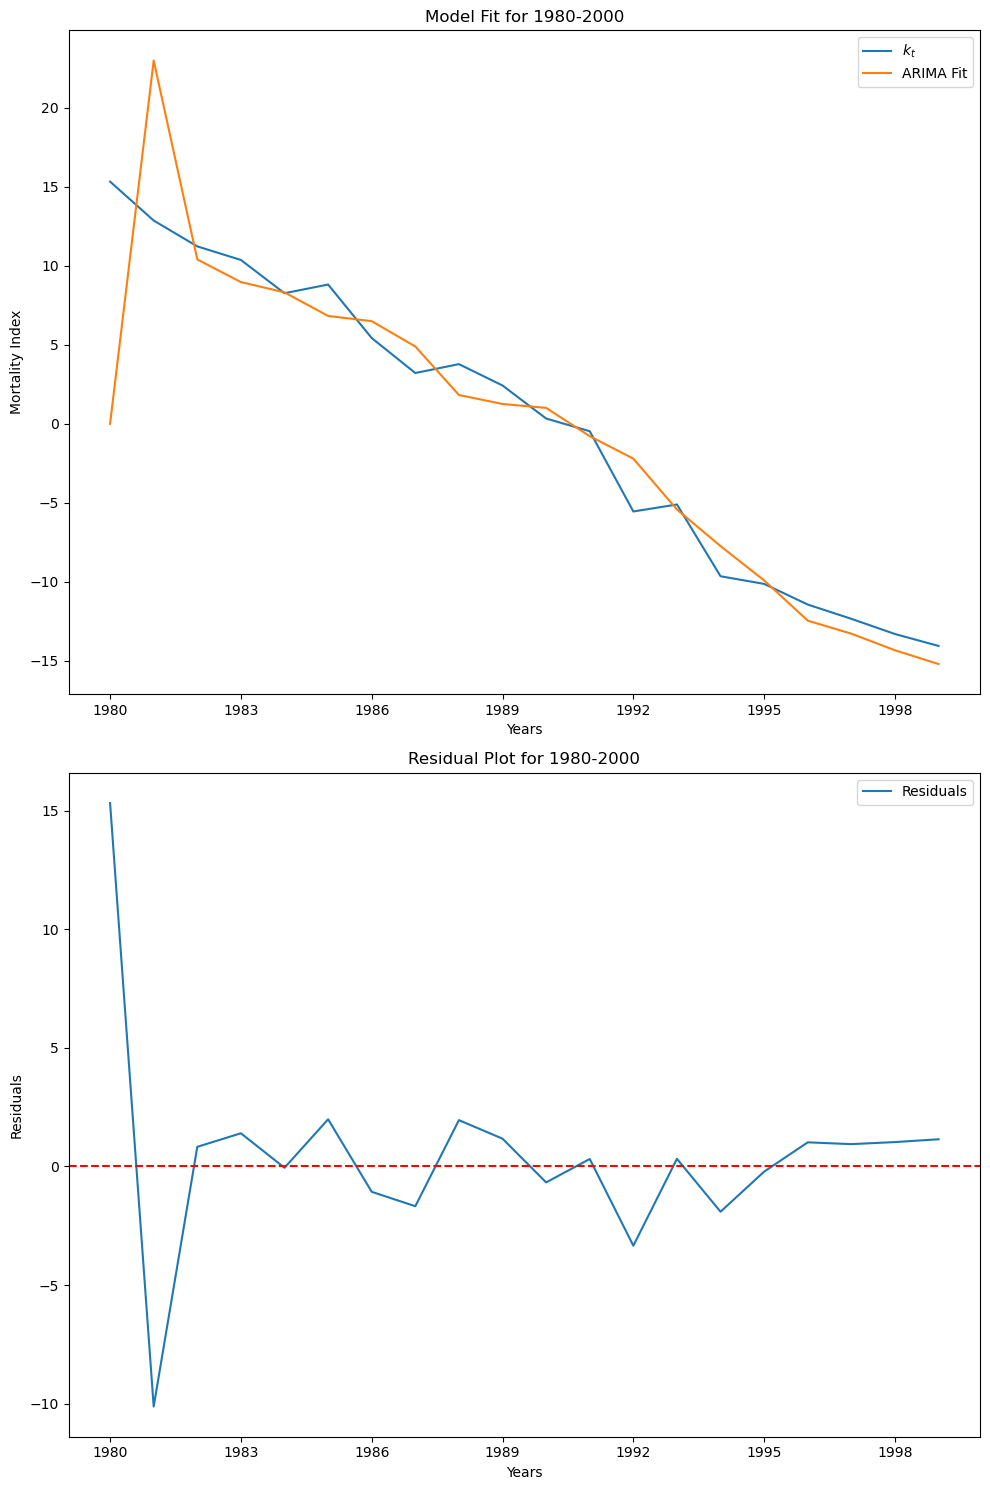

In [21]:
p_range = range(0, 3)  # Range for p based on PACF
q_range = range(0, 2)  # Range for q based on ACF

best_pdq, best_aic, best_model_fit = find_best_arima_model(k_hat1, differencing_order, p_range, q_range)
    
plot_model_fit_and_residuals(years1, k_hat1, best_model_fit)

Mean Squared Error (MSE): 2.2425126415618677
Mean Absolute Error (MAE): 1.0885142459739856


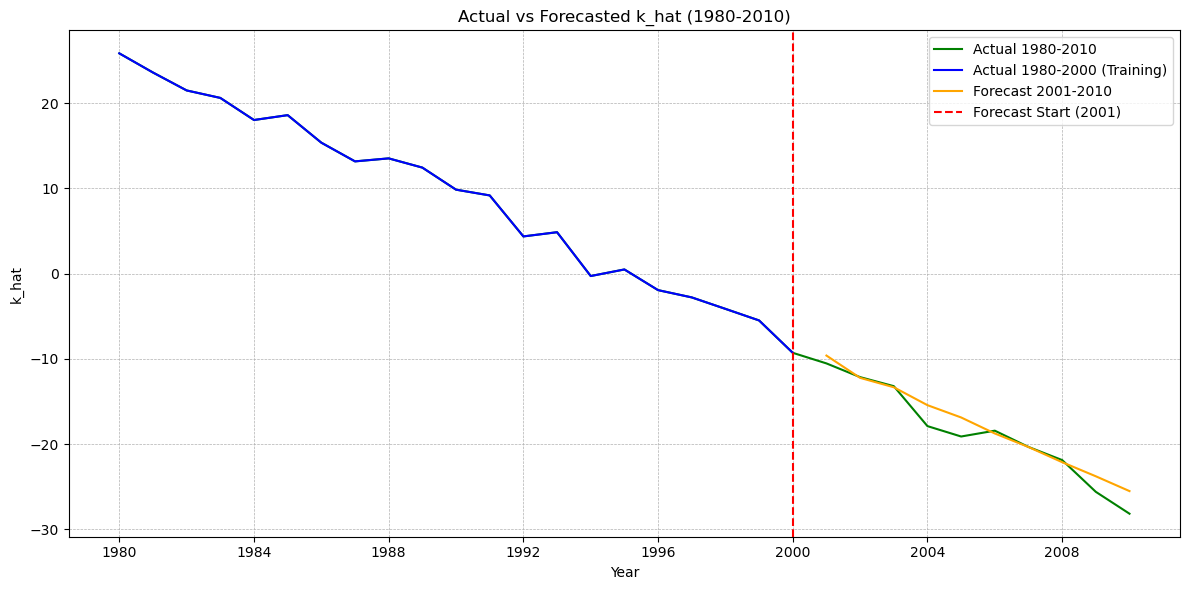

In [22]:
apply_lee_carter_forecast(df, start_year=1980, end_year=2010, train_end_year=2000, arima_order=(1, 2, 1), forecast_steps=10)

# PERIOD 2

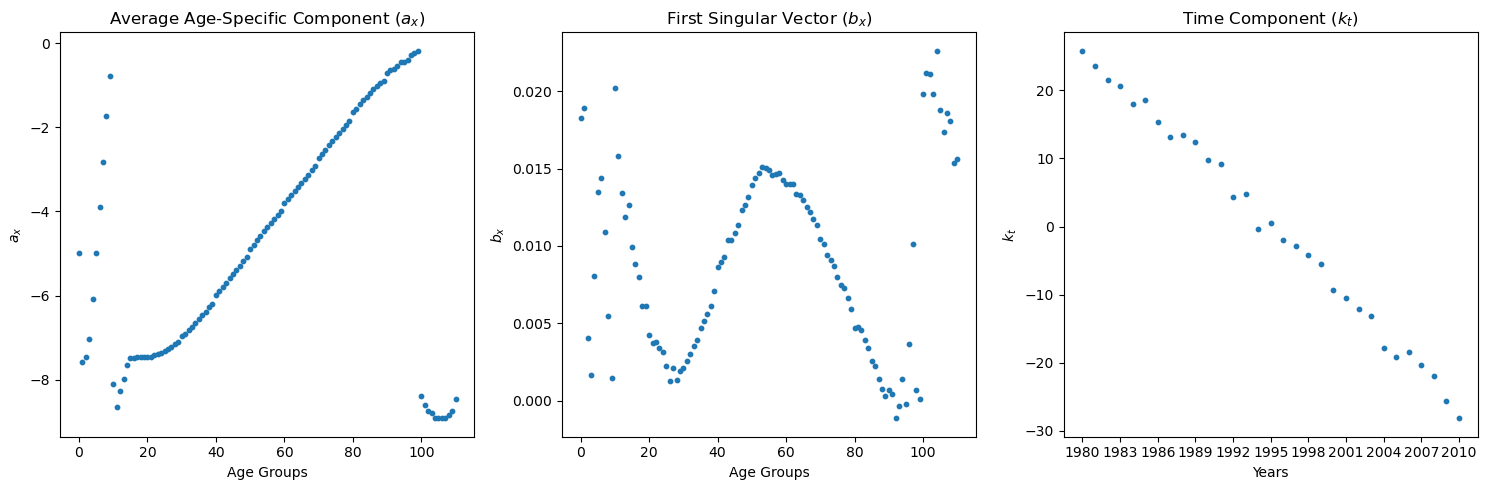


ADF Test Results for original of the series:
  Lag lag_0: ADF Statistic = 0.2064, p-value = 0.9726
  Lag lag_1: ADF Statistic = 0.7174, p-value = 0.9902
  Lag lag_2: ADF Statistic = 0.8956, p-value = 0.9930

ADF Test Results for first_diff of the series:
  Lag lag_0: ADF Statistic = -9.1236, p-value = 0.0000
  Lag lag_1: ADF Statistic = -4.5076, p-value = 0.0002
  Lag lag_2: ADF Statistic = -4.1657, p-value = 0.0008

ADF Test Results for second_diff of the series:
  Lag lag_0: ADF Statistic = -13.4490, p-value = 0.0000
  Lag lag_1: ADF Statistic = -6.4229, p-value = 0.0000
  Lag lag_2: ADF Statistic = -5.1882, p-value = 0.0000

ADF Test Results for third_diff of the series:
  Lag lag_0: ADF Statistic = -16.6841, p-value = 0.0000
  Lag lag_1: ADF Statistic = -8.0905, p-value = 0.0000
  Lag lag_2: ADF Statistic = -6.4634, p-value = 0.0000

Determined differencing order: d = 1


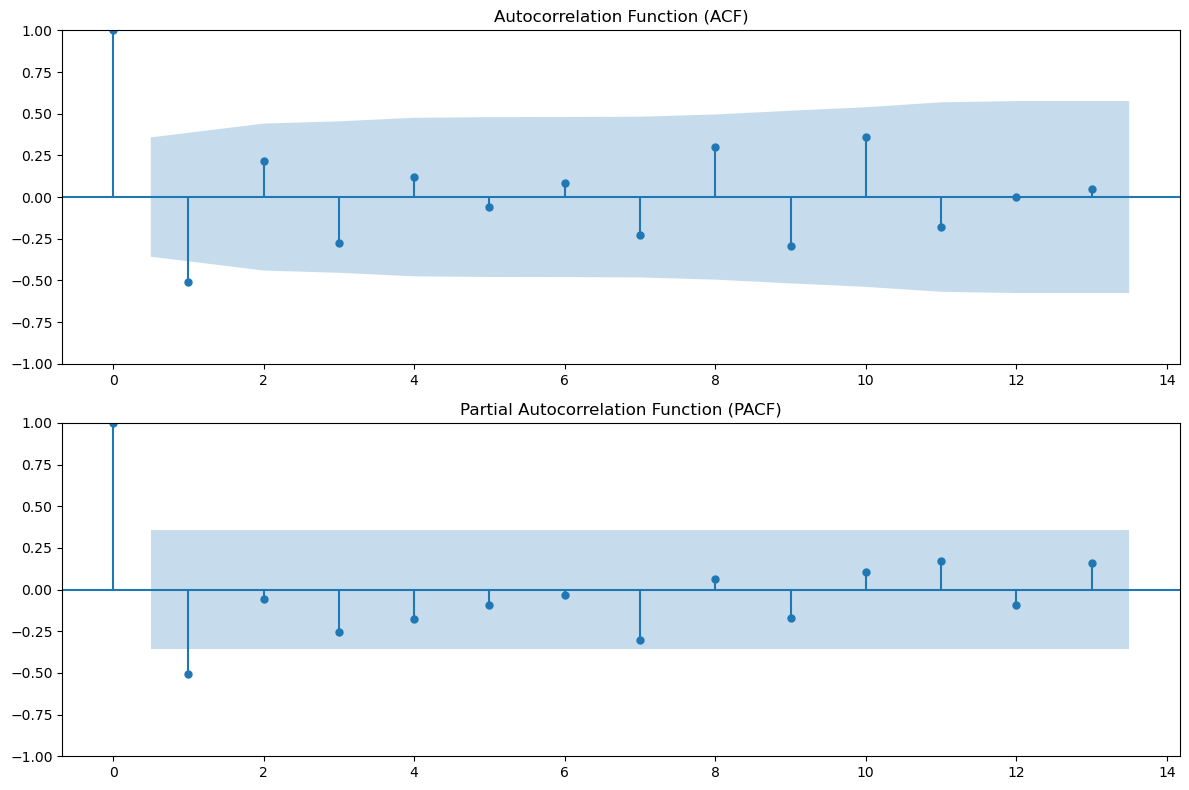

In [23]:
# Second period model fitting

a_hat2, b_hat2, k_hat2 = fit_lee_carter(df_period2)
years2 = df_period2['Year'].unique()
age_groups2 = df_period2['Age'].unique()

plot_parameters(age_groups2, a_hat2, b_hat2, years2, k_hat2)

differencing_order = perform_and_print_stationarity_tests(k_hat2)

plot_acf_pacf(k_hat2, differencing_order, subtract_lags=1)

Best ARIMA model: (1, 1, 1) with AIC: 123.07350004777128


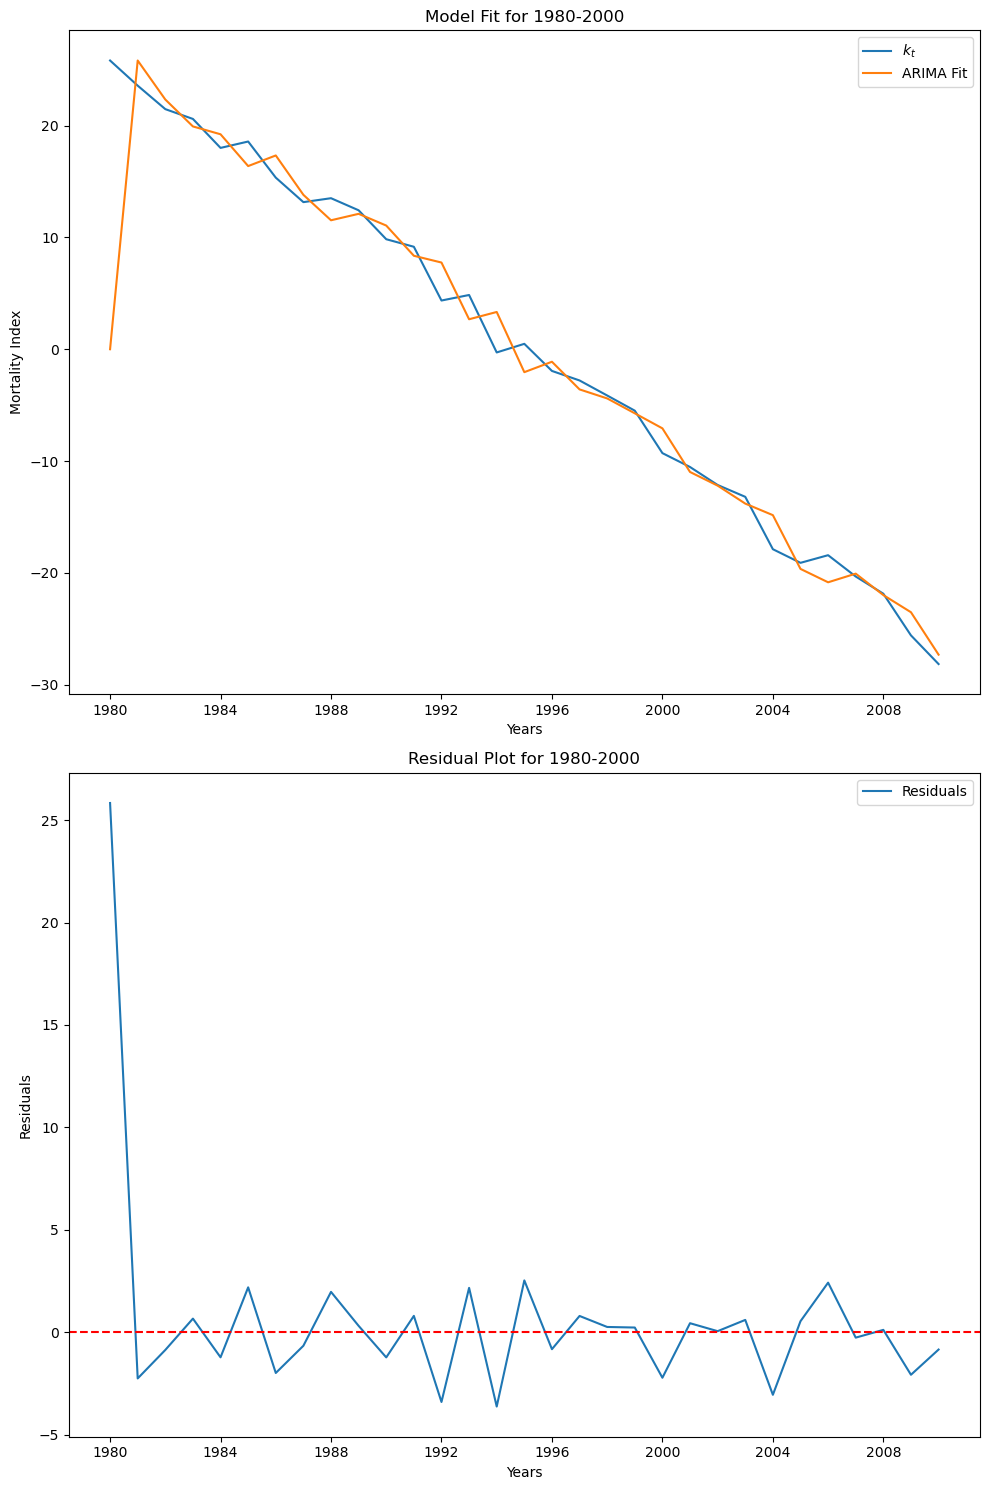

In [24]:
p_range = range(0, 2)  # Range for p based on PACF
q_range = range(0, 2)  # Range for q based on ACF

best_pdq, best_aic, best_model_fit = find_best_arima_model(k_hat2, differencing_order, p_range, q_range)
    
plot_model_fit_and_residuals(years2, k_hat2, best_model_fit)

Mean Squared Error (MSE): 14.916691146489137
Mean Absolute Error (MAE): 3.0997024696934186


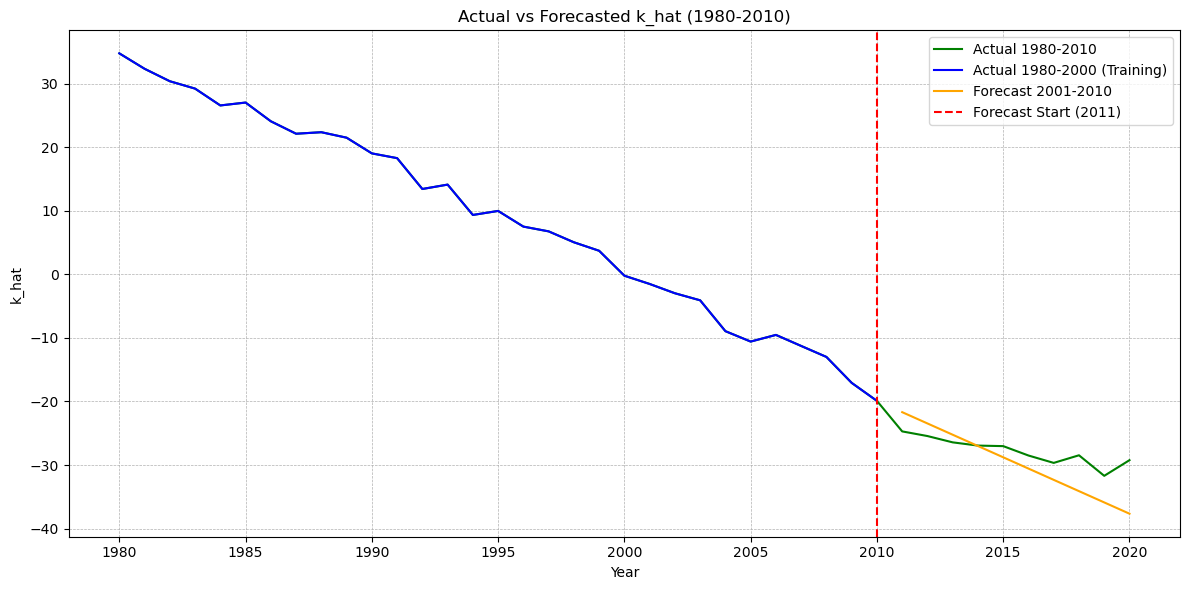

In [25]:
apply_lee_carter_forecast(df, start_year=1980, end_year=2020, train_end_year=2010, arima_order=(1, 1, 1), forecast_steps=10)

# COMPARE PERIOD 1 AND 2 FORECASTED RESULTS

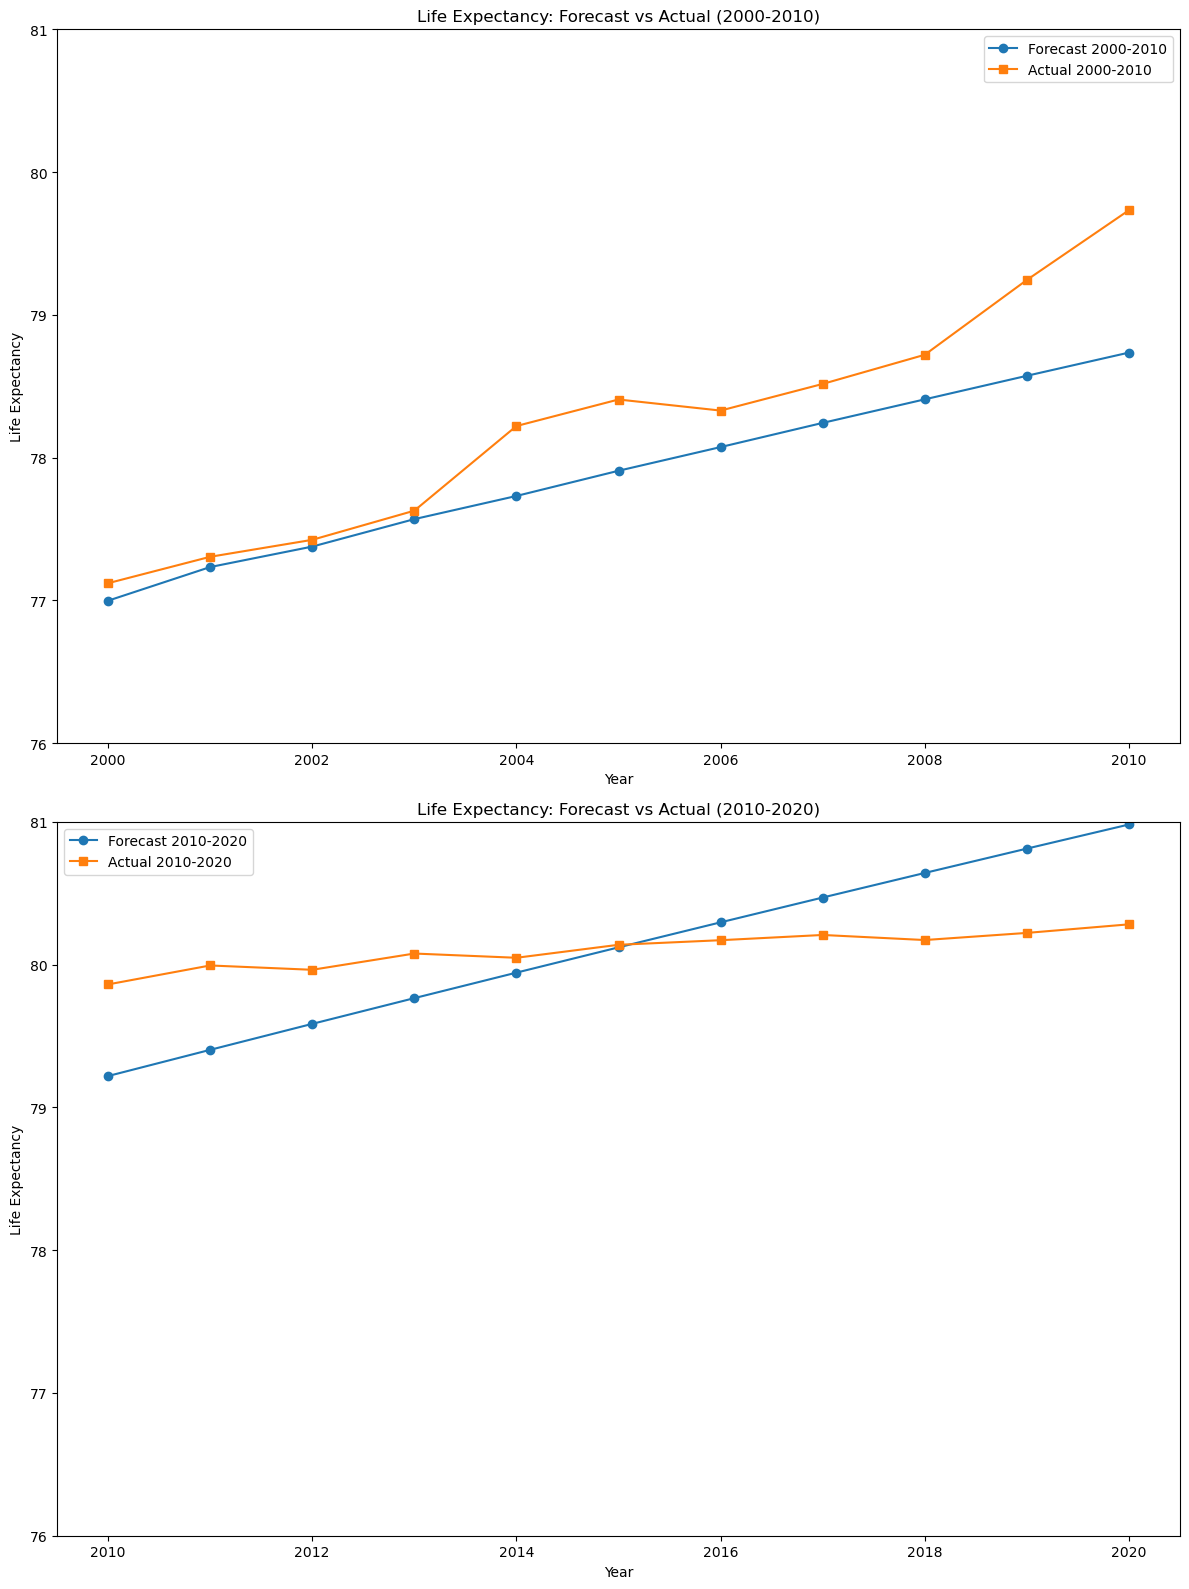

Average Forecasted Life Expectancy 2000-2010: 77.89587825718887
Average Actual Life Expectancy 2000-2010: 78.24123759507216
Average Forecasted Life Expectancy 2010-2020: 80.11266047213233
Average Actual Life Expectancy 2010-2020: 80.10346262746585


In [26]:
def forecast_arima1(k_t, steps):
    model = ARIMA(k_t, order=(1, 2, 1)) 
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

def forecast_arima2(k_t, steps):
    model = ARIMA(k_t, order=(1, 1, 1)) 
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

def convert_to_mortality_rates(a_x, b_x, k_t):
    return np.exp(a_x[:, np.newaxis] + np.outer(b_x, k_t))

def calculate_life_expectancy(mortality_rates):
    survival_prob = 1 - mortality_rates
    cumulative_survival = np.cumprod(survival_prob, axis=0)
    life_expectancy = np.sum(cumulative_survival, axis=0)
    return life_expectancy

# First forecasting period: 2000-2010
df_train_1 = df[(df['Year'] >= 1980) & (df['Year'] <= 2000)]
a_x_1, b_x_1, k_t_1 = fit_lee_carter(df_train_1)
k_hat_forecast_1 = forecast_arima1(k_t_1, steps=11)  # 11 years forecast (2000-2010 inclusive)

# Convert forecast to mortality rates
mortality_rates_forecast_1 = convert_to_mortality_rates(a_x_1, b_x_1, k_hat_forecast_1)

# Calculate life expectancy for each forecasted year
life_expectancy_forecast_1 = calculate_life_expectancy(mortality_rates_forecast_1)

# Get actual mortality rates for 2000-2010
df_actual_1 = df[(df['Year'] >= 2000) & (df['Year'] <= 2010)]
a_x_actual_1, b_x_actual_1, k_t_actual_1 = fit_lee_carter(df_actual_1)
mortality_rates_actual_1 = convert_to_mortality_rates(a_x_actual_1, b_x_actual_1, k_t_actual_1)

# Calculate actual life expectancy for 2000-2010
life_expectancy_actual_1 = calculate_life_expectancy(mortality_rates_actual_1)

# Second forecasting period: 2010-2020
df_train_2 = df[(df['Year'] >= 1980) & (df['Year'] <= 2009)]
a_x_2, b_x_2, k_t_2 = fit_lee_carter(df_train_2)
k_hat_forecast_2 = forecast_arima2(k_t_2, steps=11)  # 11 years forecast (2010-2020 inclusive)

# Convert forecast to mortality rates
mortality_rates_forecast_2 = convert_to_mortality_rates(a_x_2, b_x_2, k_hat_forecast_2)

# Calculate life expectancy for each forecasted year
life_expectancy_forecast_2 = calculate_life_expectancy(mortality_rates_forecast_2)

# Get actual mortality rates for 2010-2020
df_actual_2 = df[(df['Year'] >= 2010) & (df['Year'] <= 2020)]
a_x_actual_2, b_x_actual_2, k_t_actual_2 = fit_lee_carter(df_actual_2)
mortality_rates_actual_2 = convert_to_mortality_rates(a_x_actual_2, b_x_actual_2, k_t_actual_2)

# Calculate actual life expectancy for 2010-2020
life_expectancy_actual_2 = calculate_life_expectancy(mortality_rates_actual_2)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Plot for 2000-2010
years_1 = range(2000, 2011)
ax1.plot(years_1, life_expectancy_forecast_1, label='Forecast 2000-2010', marker='o')
ax1.plot(years_1, life_expectancy_actual_1, label='Actual 2000-2010', marker='s')
ax1.set_title('Life Expectancy: Forecast vs Actual (2000-2010)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Life Expectancy')
ax1.legend()
ax1.set_ylim(76, 81)  # Set y-axis limits
ax1.grid(False)       

# Plot for 2010-2020
years_2 = range(2010, 2021)
ax2.plot(years_2, life_expectancy_forecast_2, label='Forecast 2010-2020', marker='o')
ax2.plot(years_2, life_expectancy_actual_2, label='Actual 2010-2020', marker='s')
ax2.set_title('Life Expectancy: Forecast vs Actual (2010-2020)')
ax2.set_xlabel('Year')
ax2.set_ylabel('Life Expectancy')
ax2.legend()
ax2.set_ylim(76, 81)  # Set y-axis limits
ax2.grid(False)     

plt.tight_layout()
plt.show()

# Print summary statistics
print("Average Forecasted Life Expectancy 2000-2010:", np.mean(life_expectancy_forecast_1))
print("Average Actual Life Expectancy 2000-2010:", np.mean(life_expectancy_actual_1))
print("Average Forecasted Life Expectancy 2010-2020:", np.mean(life_expectancy_forecast_2))
print("Average Actual Life Expectancy 2010-2020:", np.mean(life_expectancy_actual_2))

In [27]:
# Calculate errors
errors_1 = np.array(life_expectancy_actual_1) - np.array(life_expectancy_forecast_1)
errors_2 = np.array(life_expectancy_actual_2) - np.array(life_expectancy_forecast_2)

# Calculate MPE
percent_errors_1 = (errors_1 / np.array(life_expectancy_actual_1)) * 100
percent_errors_2 = (errors_2 / np.array(life_expectancy_actual_2)) * 100

# Calculate MAE and RMSE
mae_1 = np.mean(np.abs(errors_1))
rmse_1 = np.sqrt(np.mean(errors_1**2))
mae_2 = np.mean(np.abs(errors_2))
rmse_2 = np.sqrt(np.mean(errors_2**2))


# Print summary statistics
print("\nPeriod 2000-2010:")
print(f"Mean Absolute Error (MAE): {mae_1:.2f} years")
print(f"Root Mean Squared Error (RMSE): {rmse_1:.2f} years")
print(f"Mean Percentage Error: {np.mean(percent_errors_1):.2f}%")

print("\nPeriod 2010-2020:")
print(f"Mean Absolute Error (MAE): {mae_2:.2f} years")
print(f"Root Mean Squared Error (RMSE): {rmse_2:.2f} years")
print(f"Mean Percentage Error: {np.mean(percent_errors_2):.2f}%")


Period 2000-2010:
Mean Absolute Error (MAE): 0.35 years
Root Mean Squared Error (RMSE): 0.45 years
Mean Percentage Error: 0.44%

Period 2010-2020:
Mean Absolute Error (MAE): 0.38 years
Root Mean Squared Error (RMSE): 0.44 years
Mean Percentage Error: -0.01%


# NOW FIT MODEL USING ALL OF THE DATA 1980-2020

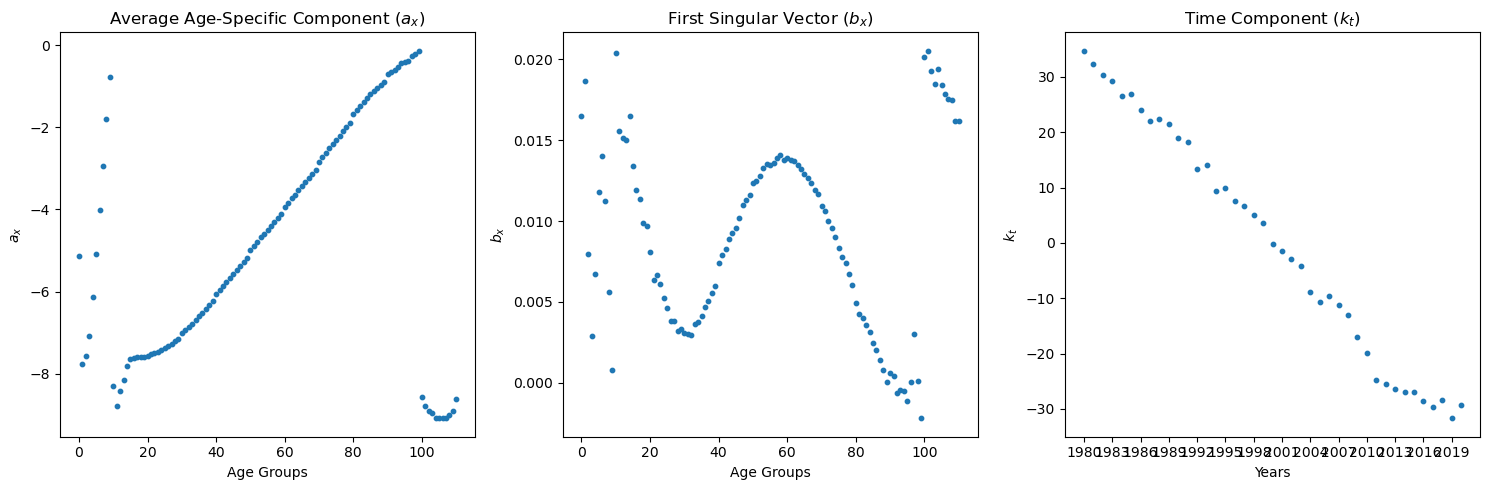


ADF Test Results for original of the series:
  Lag lag_0: ADF Statistic = -1.0534, p-value = 0.7333
  Lag lag_1: ADF Statistic = -1.0051, p-value = 0.7514
  Lag lag_2: ADF Statistic = -0.8428, p-value = 0.8062

ADF Test Results for first_diff of the series:
  Lag lag_0: ADF Statistic = -8.2751, p-value = 0.0000
  Lag lag_1: ADF Statistic = -3.7448, p-value = 0.0035
  Lag lag_2: ADF Statistic = -3.2870, p-value = 0.0155

ADF Test Results for second_diff of the series:
  Lag lag_0: ADF Statistic = -14.7194, p-value = 0.0000
  Lag lag_1: ADF Statistic = -6.8930, p-value = 0.0000
  Lag lag_2: ADF Statistic = -5.4022, p-value = 0.0000

ADF Test Results for third_diff of the series:
  Lag lag_0: ADF Statistic = -18.5278, p-value = 0.0000
  Lag lag_1: ADF Statistic = -9.2460, p-value = 0.0000
  Lag lag_2: ADF Statistic = -6.9920, p-value = 0.0000

Determined differencing order: d = 1


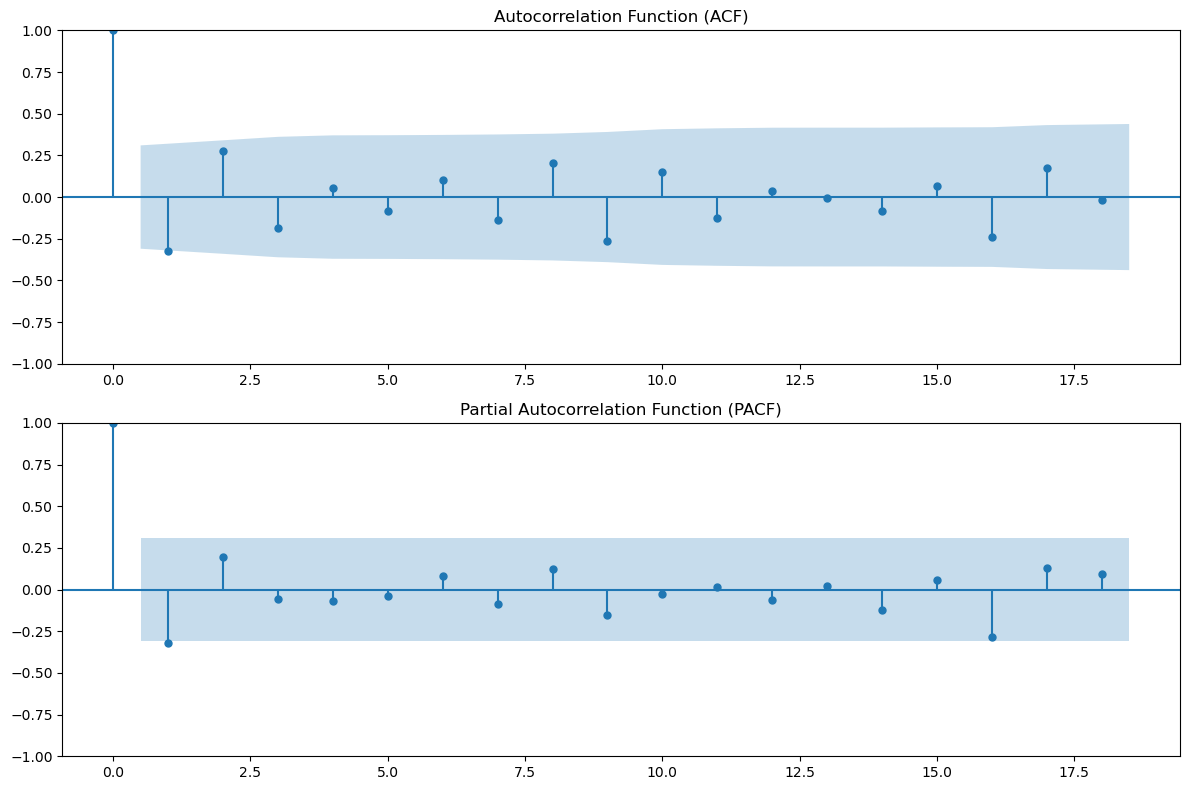

In [28]:
# Final model fitting

a_hat3, b_hat3, k_hat3 = fit_lee_carter(df_period3)
years3 = df_period3['Year'].unique()
age_groups3 = df_period3['Age'].unique()

plot_parameters(age_groups3, a_hat3, b_hat3, years3, k_hat3)

differencing_order = perform_and_print_stationarity_tests(k_hat3)

plot_acf_pacf(k_hat3, differencing_order, subtract_lags=1)

Best ARIMA model: (1, 1, 1) with AIC: 167.71788473069628


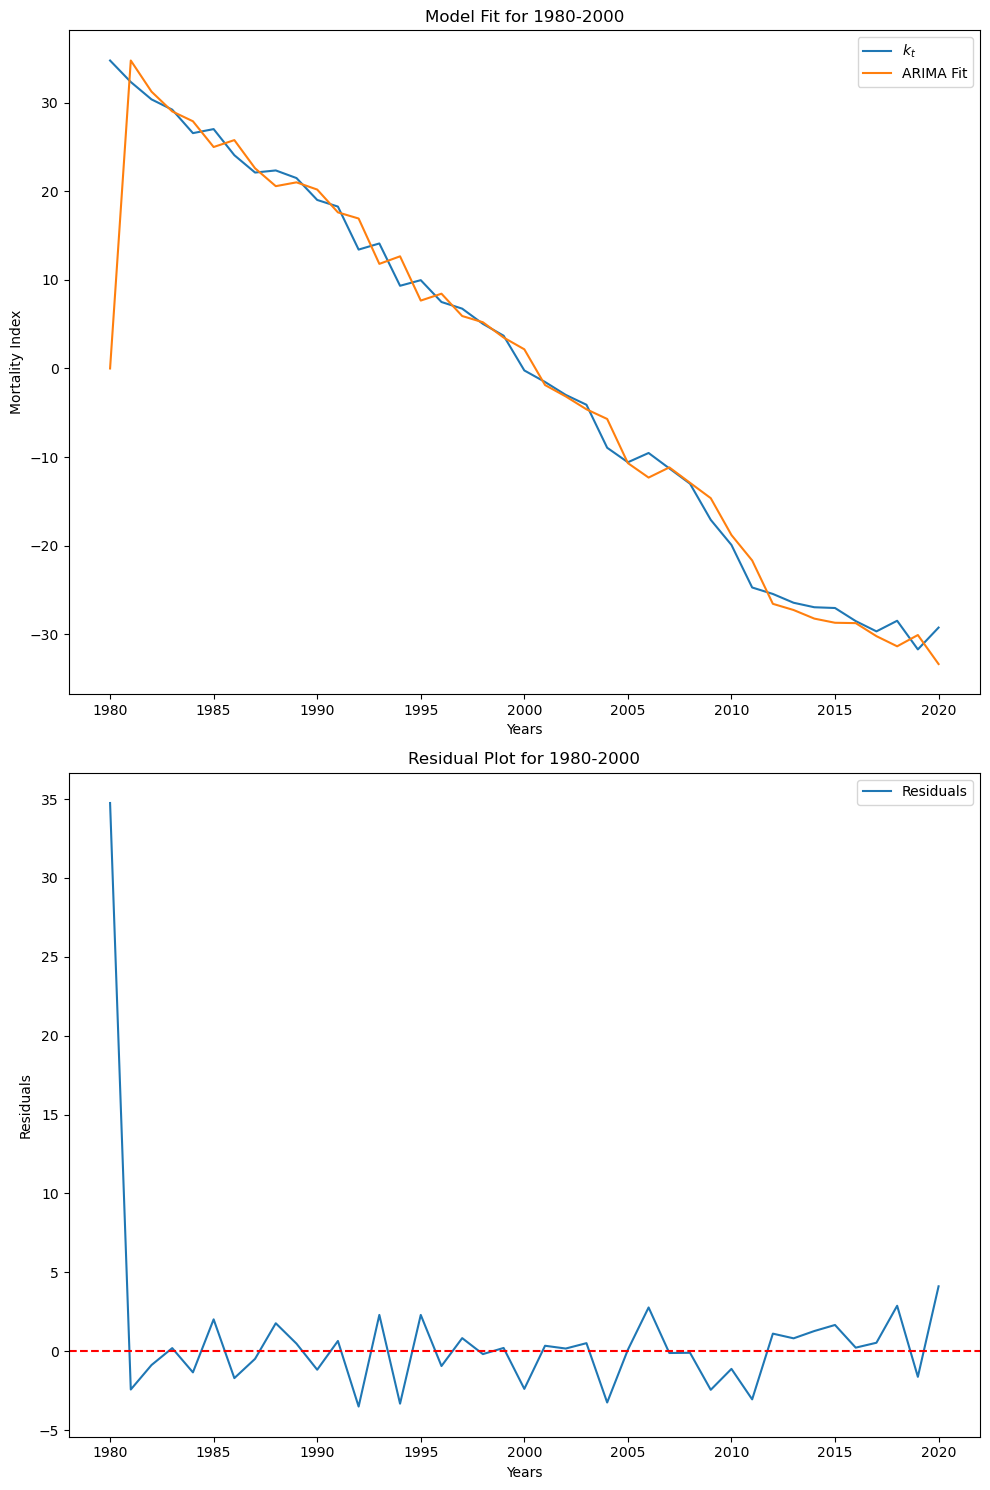

In [29]:
p_range = range(0, 2)  # Range for p based on PACF
q_range = range(0, 2)  # Range for q based on ACF

best_pdq, best_aic, best_model_fit = find_best_arima_model(k_hat3, differencing_order, p_range, q_range)
    
plot_model_fit_and_residuals(years3, k_hat3, best_model_fit)

# MODEL FITTING: MALES AND FEMALES SEPARATE

In [30]:
# Create male and female datasets
df_male = df[['Year', 'Age', 'male_deaths', 'male_population', 'male_exposures', 'male_mortality_rate']]
df_female = df[['Year', 'Age', 'female_deaths', 'female_population', 'female_exposures', 'female_mortality_rate']]

# Rename columns to make them generic
df_male.columns = ['Year', 'Age', 'deaths', 'population', 'exposures', 'total_mortality_rate']
df_female.columns = ['Year', 'Age', 'deaths', 'population', 'exposures', 'total_mortality_rate']

# Create a mask for rows where the male or female population is zero (this is to avoid the mortality rate being a NaN value)
mask_zero_population_male = (df_male['population'] == 0)
mask_zero_population_female = (df_female['population'] == 0)

# Print the number of rows that will be dropped
print(f"Number of rows of male data with zero population: {mask_zero_population_male.sum()}")
print(f"Number of rows of female data with zero population: {mask_zero_population_female.sum()}")

# Drop rows where the mask is True
df_male = df_male[~mask_zero_population_male]
df_female = df_female[~mask_zero_population_female]

# Filter data for each period
df_male_period1 = df_male[(df_male['Year'] >= period1_start) & (df_male['Year'] <= period1_end)]
df_male_period2 = df_male[(df_male['Year'] >= period2_start) & (df_male['Year'] <= period2_end)]
df_male_period3 = df_male[(df_male['Year'] >= period3_start) & (df_male['Year'] <= period3_end)]

df_female_period1 = df_female[(df_female['Year'] >= period1_start) & (df_female['Year'] <= period1_end)]
df_female_period2 = df_female[(df_female['Year'] >= period2_start) & (df_female['Year'] <= period2_end)]
df_female_period3 = df_female[(df_female['Year'] >= period3_start) & (df_female['Year'] <= period3_end)]

Number of rows of male data with zero population: 170
Number of rows of female data with zero population: 13


In [31]:
# Re-define the Lee Carter function but for male/female mortality rate

def fit_lee_carter_male_or_female(df):
   # Step 1: Initialise the Mortality matrix (pivot the data to have Age groups as rows and Years as columns)
    mortality_matrix = df.pivot(index='Age', columns='Year', values='total_mortality_rate').values

    # Step 2: Replace zeros with a small positive value and handle NaNs
    mortality_matrix[mortality_matrix == 0] = np.nan
    mortality_matrix = np.where(np.isnan(mortality_matrix), np.nanmean(mortality_matrix, axis=1)[:, np.newaxis], mortality_matrix)

    # Step 3: Define T, the number of years
    T = mortality_matrix.shape[1]

    # Step 4: Calculate the estimator for the age-specific pattern of mortality coefficient, a_hat
    a_hat = np.mean(np.log(mortality_matrix), axis=1)

    # Step 5: Define matrix Z
    Z = np.log(mortality_matrix) - a_hat[:, np.newaxis]

    # Step 6: Apply SVD to Z
    U, S, Vt = svd(Z, full_matrices=False)

    # Step 8: Solve for estimates b_hat and k_hat
    b_hat = -U[:, 0]
    sum_b_hat = np.sum(b_hat)
    b_hat = b_hat / sum_b_hat
    k_hat = -sum_b_hat * S[0] * Vt[0, :]

    return a_hat, b_hat, k_hat

# MALE DATA - PERIOD 1

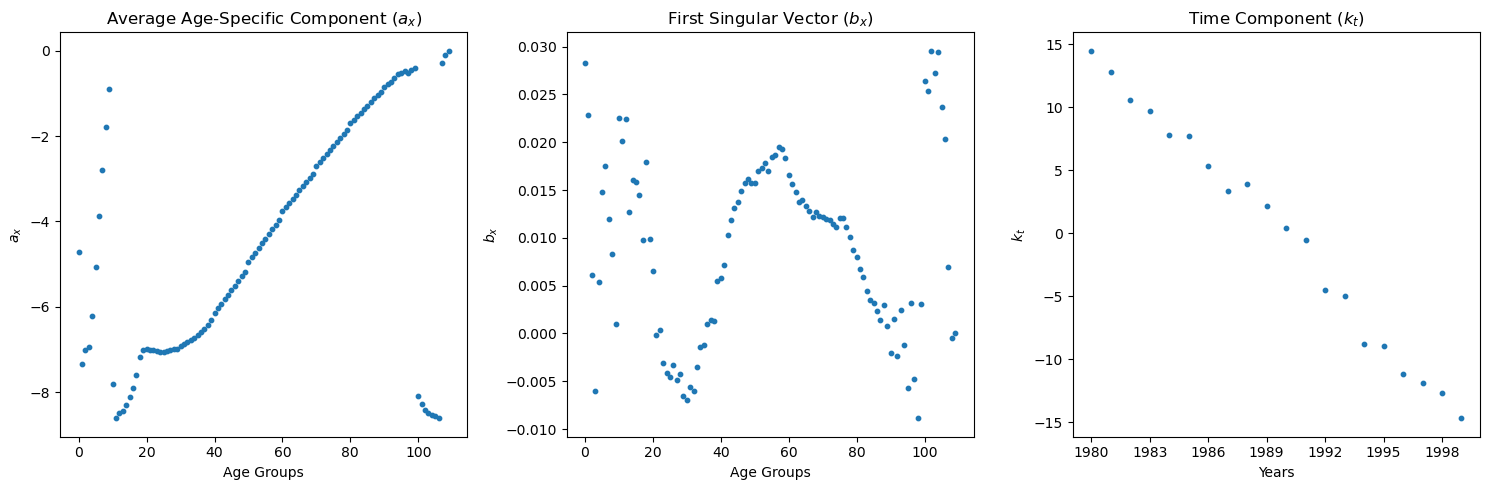


ADF Test Results for original of the series:
  Lag lag_0: ADF Statistic = -0.2114, p-value = 0.9371
  Lag lag_1: ADF Statistic = -0.0502, p-value = 0.9542
  Lag lag_2: ADF Statistic = 0.2516, p-value = 0.9750

ADF Test Results for first_diff of the series:
  Lag lag_0: ADF Statistic = -7.7097, p-value = 0.0000
  Lag lag_1: ADF Statistic = -3.2925, p-value = 0.0152
  Lag lag_2: ADF Statistic = -1.7748, p-value = 0.3930

ADF Test Results for second_diff of the series:
  Lag lag_0: ADF Statistic = -11.5377, p-value = 0.0000
  Lag lag_1: ADF Statistic = -6.2205, p-value = 0.0000
  Lag lag_2: ADF Statistic = -2.7458, p-value = 0.0664

ADF Test Results for third_diff of the series:
  Lag lag_0: ADF Statistic = -13.1449, p-value = 0.0000
  Lag lag_1: ADF Statistic = -8.7955, p-value = 0.0000
  Lag lag_2: ADF Statistic = -4.0064, p-value = 0.0014

Determined differencing order: d = 3


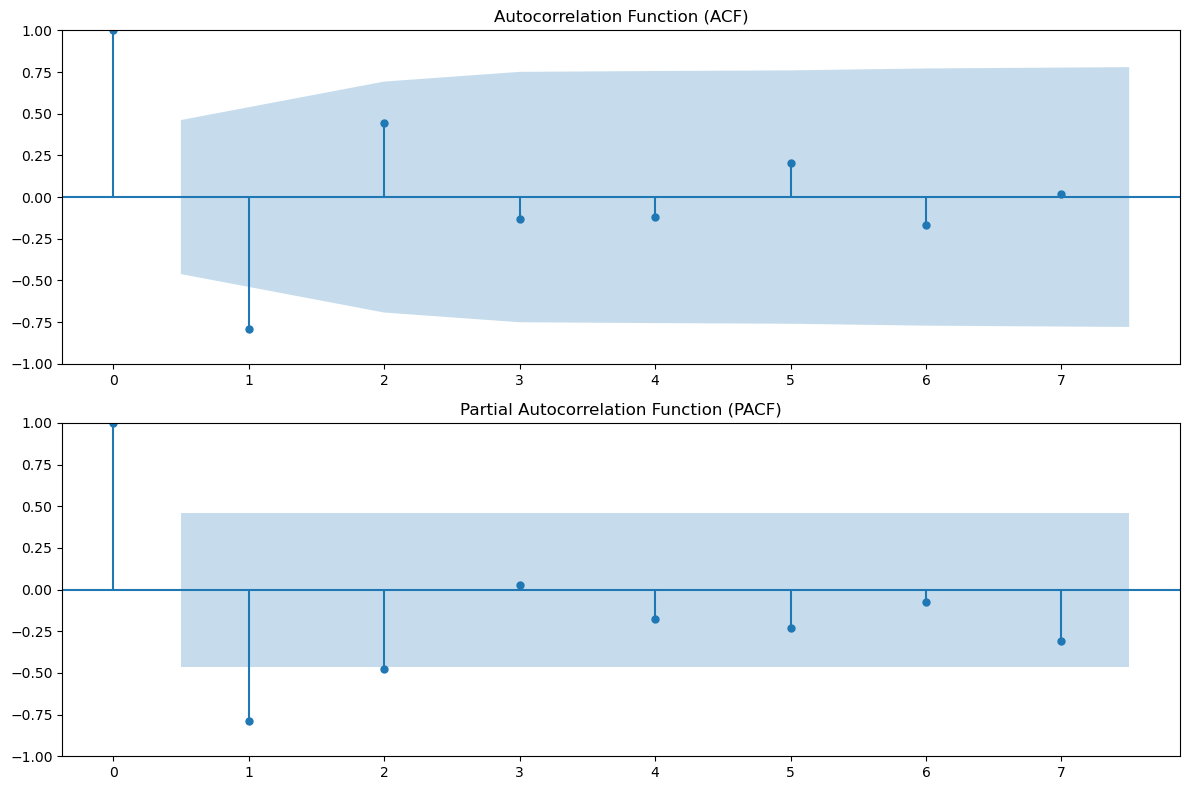

In [32]:
# Male period 1 model fitting

a_hat_male_1, b_hat_male_1, k_hat_male_1 = fit_lee_carter_male_or_female(df_male_period1)
years_male_1 = df_male_period1['Year'].unique()
age_groups_male_1 = df_male_period1['Age'].unique()

plot_parameters(age_groups_male_1, a_hat_male_1, b_hat_male_1, years_male_1, k_hat_male_1)

differencing_order = perform_and_print_stationarity_tests(k_hat_male_1)

plot_acf_pacf(k_hat_male_1, differencing_order, subtract_lags=2)

Best ARIMA model: (2, 3, 1) with AIC: 65.8286963594498


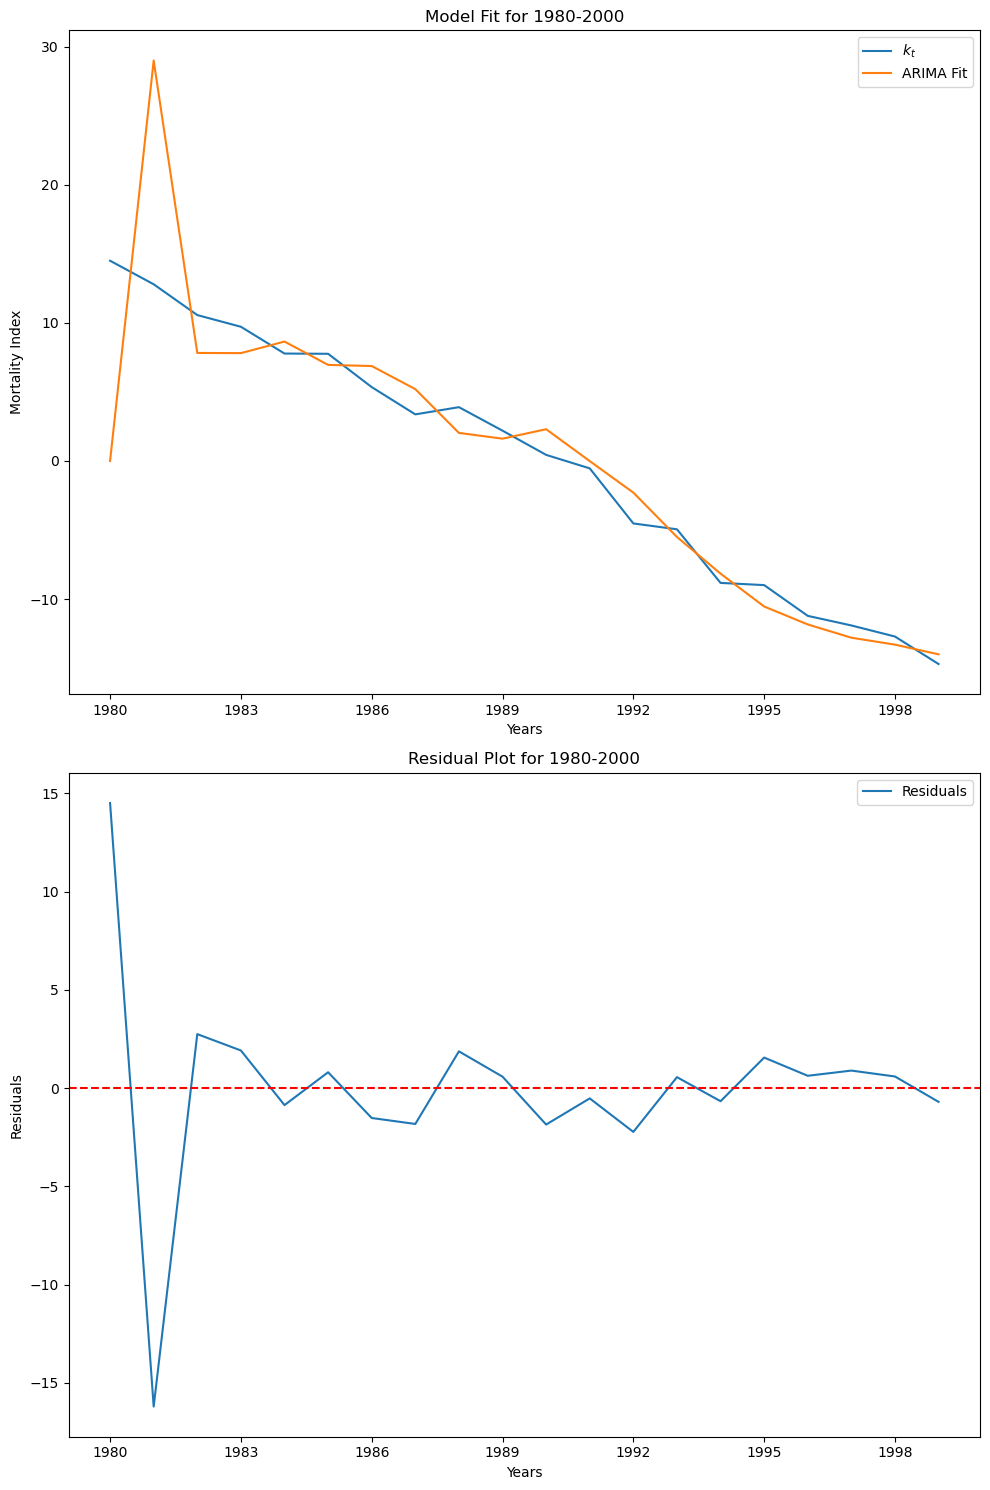

In [33]:
p_range = range(0, 3)  # Range for p based on PACF
q_range = range(0, 2)  # Range for q based on ACF

best_pdq, best_aic, best_model_fit = find_best_arima_model(k_hat_male_1, differencing_order, p_range, q_range)
    
plot_model_fit_and_residuals(years_male_1, k_hat_male_1, best_model_fit)

Mean Squared Error (MSE): 33.00169914215841
Mean Absolute Error (MAE): 4.849870233015791


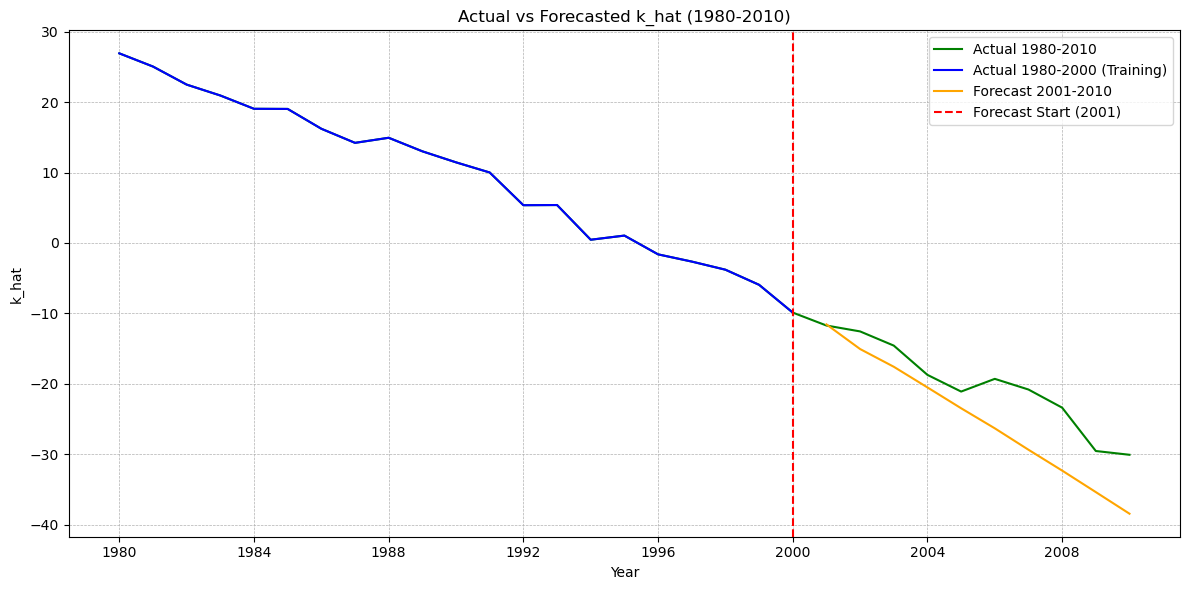

In [34]:
apply_lee_carter_forecast(df_male, start_year=1980, end_year=2010, train_end_year=2000, arima_order=(2,3,1), forecast_steps=10)

# MALE DATA - PERIOD 2

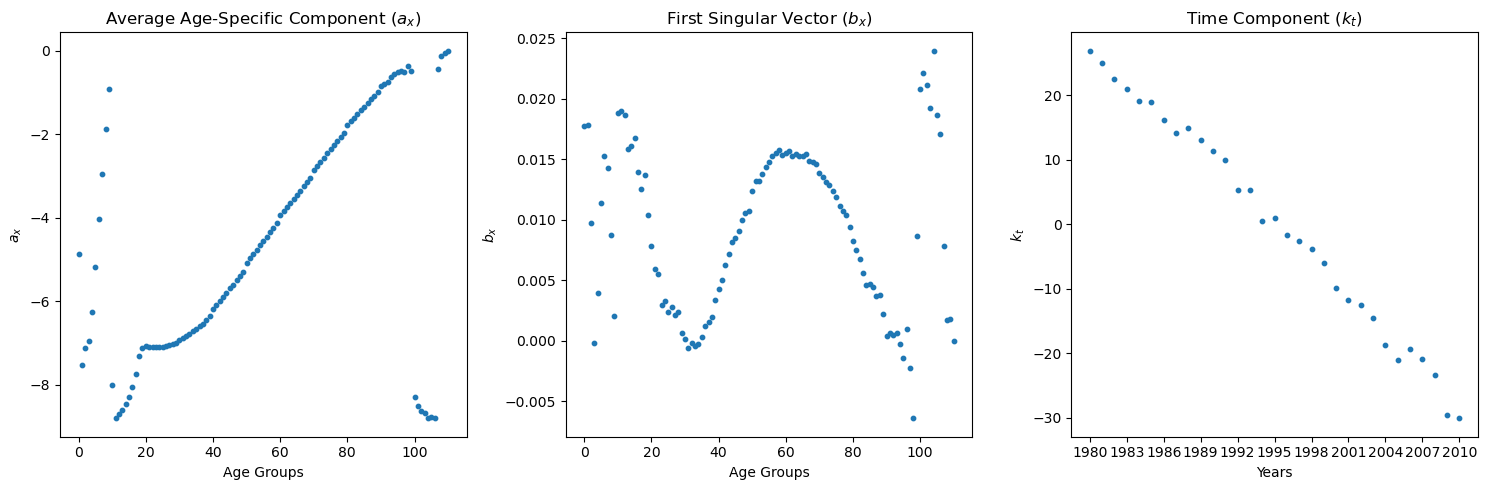


ADF Test Results for original of the series:
  Lag lag_0: ADF Statistic = 0.3227, p-value = 0.9784
  Lag lag_1: ADF Statistic = 0.7385, p-value = 0.9906
  Lag lag_2: ADF Statistic = 0.9754, p-value = 0.9940

ADF Test Results for first_diff of the series:
  Lag lag_0: ADF Statistic = -7.0669, p-value = 0.0000
  Lag lag_1: ADF Statistic = -4.5235, p-value = 0.0002
  Lag lag_2: ADF Statistic = -5.0401, p-value = 0.0000

ADF Test Results for second_diff of the series:
  Lag lag_0: ADF Statistic = -9.9572, p-value = 0.0000
  Lag lag_1: ADF Statistic = -5.6599, p-value = 0.0000
  Lag lag_2: ADF Statistic = -5.9142, p-value = 0.0000

ADF Test Results for third_diff of the series:
  Lag lag_0: ADF Statistic = -12.4677, p-value = 0.0000
  Lag lag_1: ADF Statistic = -6.2654, p-value = 0.0000
  Lag lag_2: ADF Statistic = -5.8335, p-value = 0.0000

Determined differencing order: d = 1


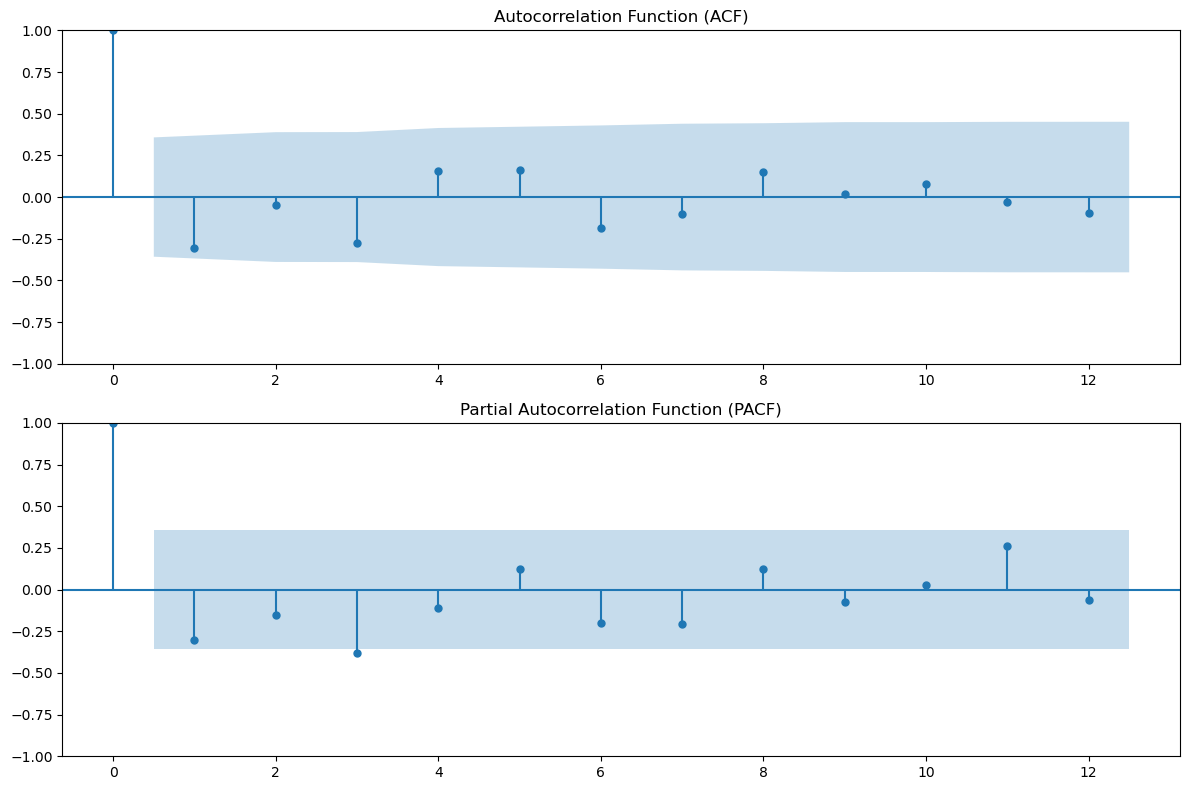

In [35]:
# Male period 2 model fitting

a_hat_male_2, b_hat_male_2, k_hat_male_2 = fit_lee_carter_male_or_female(df_male_period2)
years_male_2 = df_male_period2['Year'].unique()
age_groups_male_2 = df_male_period2['Age'].unique()

plot_parameters(age_groups_male_2, a_hat_male_2, b_hat_male_2, years_male_2, k_hat_male_2)

differencing_order = perform_and_print_stationarity_tests(k_hat_male_2)

plot_acf_pacf(k_hat_male_2, differencing_order, subtract_lags=2)

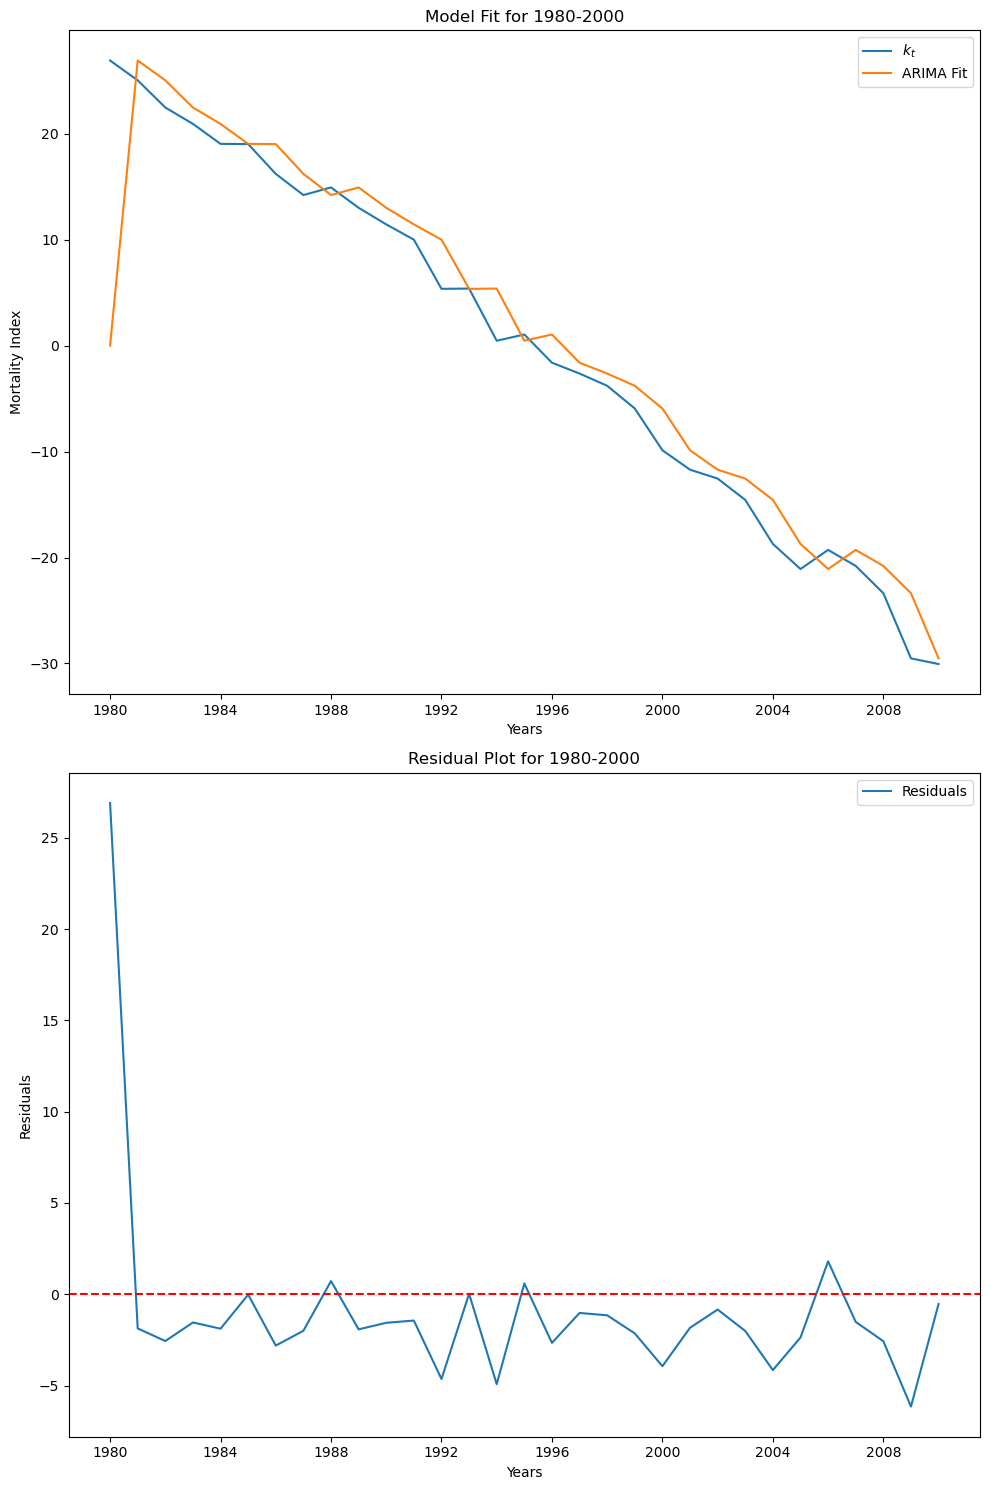

In [36]:
# Define the range for p and q based on ACF and PACF plots 
p = 0
q = 0

# No need for AIC here as there is only 1 combination of parameters
model = ARIMA(k_hat_male_2, order=(0, 1, 0))
best_model_fit = model.fit()
  
plot_model_fit_and_residuals(years_male_2, k_hat_male_2, best_model_fit)

Mean Squared Error (MSE): 14.916691146489137
Mean Absolute Error (MAE): 3.0997024696934186


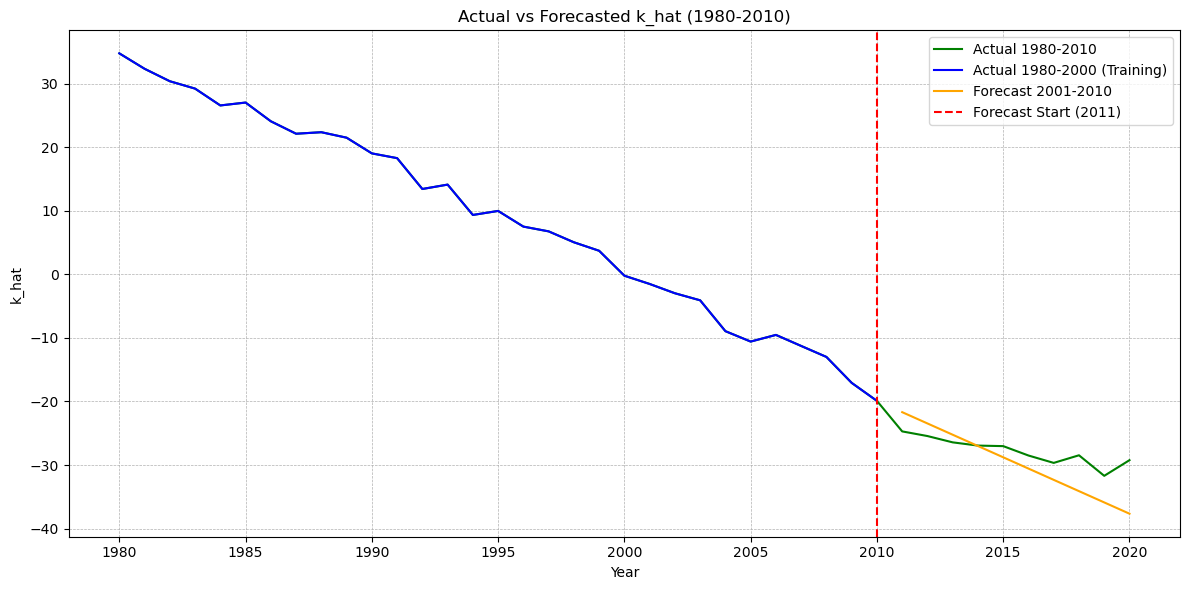

In [37]:
apply_lee_carter_forecast(df, start_year=1980, end_year=2020, train_end_year=2010, arima_order=(1, 1, 1), forecast_steps=10)

# COMPARE PERIOD 1 AND 2 FORECASTED RESULTS

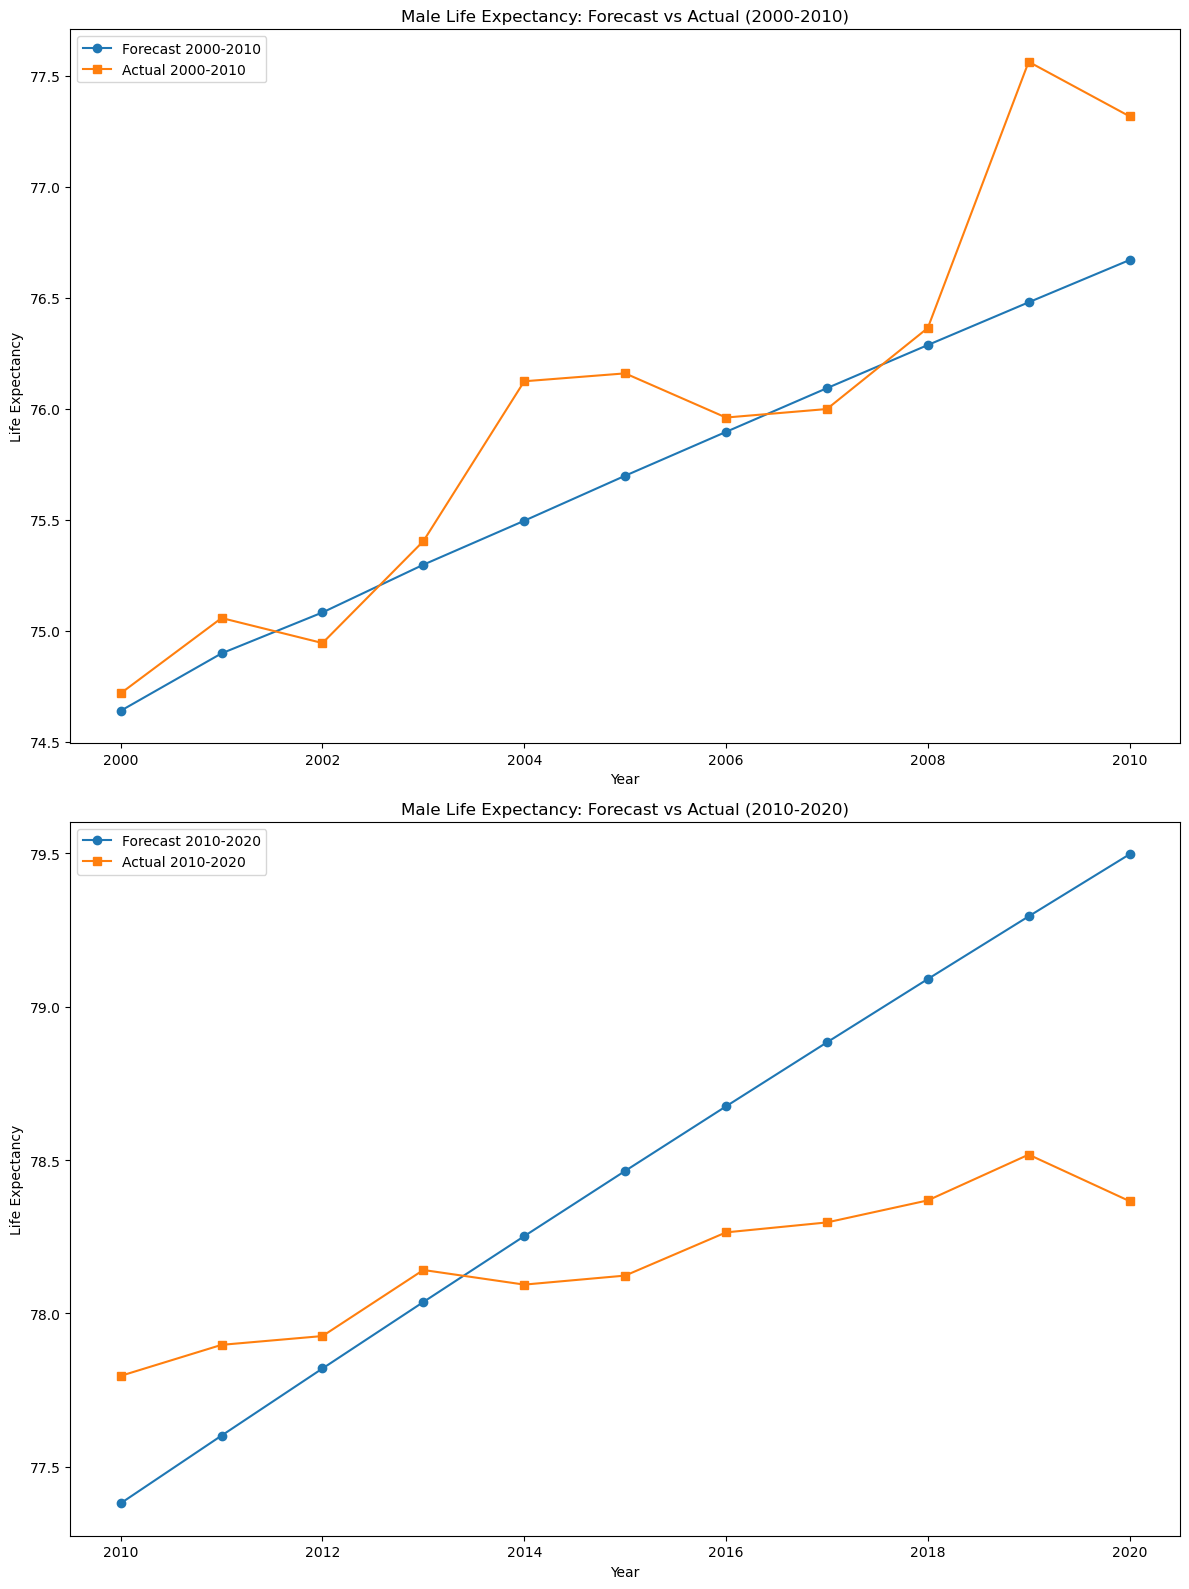

Average Forecasted Male Life Expectancy 2000-2010: 75.68495070288778
Average Actual Male Life Expectancy 2000-2010: 75.9642864729048
Average Forecasted Male Life Expectancy 2010-2020: 78.45435113772591
Average Actual Male Life Expectancy 2010-2020: 78.16288938782604


In [38]:
# First forecasting period: 2000-2010
df_male_train_1 = df_male[(df_male['Year'] >= 1980) & (df_male['Year'] <= 2000)]
a_x_male_1, b_x_male_1, k_t_male_1 = fit_lee_carter_male_or_female(df_male_train_1)
k_hat_male_forecast_1 = forecast_arima1(k_t_male_1, steps=11)  # 11 years forecast (2000-2010 inclusive)

# Convert forecast to mortality rates
mortality_rates_male_forecast_1 = convert_to_mortality_rates(a_x_male_1, b_x_male_1, k_hat_male_forecast_1)

# Calculate life expectancy for each forecasted year
life_expectancy_male_forecast_1 = calculate_life_expectancy(mortality_rates_male_forecast_1)

# Get actual mortality rates for 2000-2010
df_male_actual_1 = df_male[(df_male['Year'] >= 2000) & (df_male['Year'] <= 2010)]
a_x_male_actual_1, b_x_male_actual_1, k_t_male_actual_1 = fit_lee_carter_male_or_female(df_male_actual_1)
mortality_rates_male_actual_1 = convert_to_mortality_rates(a_x_male_actual_1, b_x_male_actual_1, k_t_male_actual_1)

# Calculate actual life expectancy for 2000-2010
life_expectancy_male_actual_1 = calculate_life_expectancy(mortality_rates_male_actual_1)

# Second forecasting period: 2010-2020
df_male_train_2 = df_male[(df_male['Year'] >= 1980) & (df_male['Year'] <= 2009)]
a_x_male_2, b_x_male_2, k_t_male_2 = fit_lee_carter_male_or_female(df_male_train_2)
k_hat_male_forecast_2 = forecast_arima2(k_t_male_2, steps=11)  # 11 years forecast (2010-2020 inclusive)

# Convert forecast to mortality rates
mortality_rates_male_forecast_2 = convert_to_mortality_rates(a_x_male_2, b_x_male_2, k_hat_male_forecast_2)

# Calculate life expectancy for each forecasted year
life_expectancy_male_forecast_2 = calculate_life_expectancy(mortality_rates_male_forecast_2)

# Get actual mortality rates for 2010-2020
df_male_actual_2 = df_male[(df_male['Year'] >= 2010) & (df_male['Year'] <= 2020)]
a_x_male_actual_2, b_x_male_actual_2, k_t_male_actual_2 = fit_lee_carter_male_or_female(df_male_actual_2)
mortality_rates_male_actual_2 = convert_to_mortality_rates(a_x_male_actual_2, b_x_male_actual_2, k_t_male_actual_2)

# Calculate actual life expectancy for 2010-2020
life_expectancy_male_actual_2 = calculate_life_expectancy(mortality_rates_male_actual_2)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Plot for 2000-2010
years_1 = range(2000, 2011)
ax1.plot(years_1, life_expectancy_male_forecast_1, label='Forecast 2000-2010', marker='o')
ax1.plot(years_1, life_expectancy_male_actual_1, label='Actual 2000-2010', marker='s')
ax1.set_title('Male Life Expectancy: Forecast vs Actual (2000-2010)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Life Expectancy')
ax1.legend()

# Plot for 2010-2020
years_2 = range(2010, 2021)
ax2.plot(years_2, life_expectancy_male_forecast_2, label='Forecast 2010-2020', marker='o')
ax2.plot(years_2, life_expectancy_male_actual_2, label='Actual 2010-2020', marker='s')
ax2.set_title('Male Life Expectancy: Forecast vs Actual (2010-2020)')
ax2.set_xlabel('Year')
ax2.set_ylabel('Life Expectancy')
ax2.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print("Average Forecasted Male Life Expectancy 2000-2010:", np.mean(life_expectancy_male_forecast_1))
print("Average Actual Male Life Expectancy 2000-2010:", np.mean(life_expectancy_male_actual_1))
print("Average Forecasted Male Life Expectancy 2010-2020:", np.mean(life_expectancy_male_forecast_2))
print("Average Actual Male Life Expectancy 2010-2020:", np.mean(life_expectancy_male_actual_2))

In [39]:
# Calculate errors for male data
errors_male_1 = np.array(life_expectancy_male_actual_1) - np.array(life_expectancy_male_forecast_1)
errors_male_2 = np.array(life_expectancy_male_actual_2) - np.array(life_expectancy_male_forecast_2)

# Calculate percentage errors for male data
percent_errors_male_1 = (errors_male_1 / np.array(life_expectancy_male_actual_1)) * 100
percent_errors_male_2 = (errors_male_2 / np.array(life_expectancy_male_actual_2)) * 100

# Calculate MAE and root RMSE for male data
mae_male_1 = np.mean(np.abs(errors_male_1))
rmse_male_1 = np.sqrt(np.mean(errors_male_1**2))
mae_male_2 = np.mean(np.abs(errors_male_2))
rmse_male_2 = np.sqrt(np.mean(errors_male_2**2))

# Print summary statistics for male data
print("\nMale Life Expectancy - Period 2000-2010:")
print(f"Mean Absolute Error (MAE): {mae_male_1:.2f} years")
print(f"Root Mean Squared Error (RMSE): {rmse_male_1:.2f} years")
print(f"Mean Percentage Error: {np.mean(percent_errors_male_1):.2f}%")

print("\nMale Life Expectancy - Period 2010-2020:")
print(f"Mean Absolute Error (MAE): {mae_male_2:.2f} years")
print(f"Root Mean Squared Error (RMSE): {rmse_male_2:.2f} years")
print(f"Mean Percentage Error: {np.mean(percent_errors_male_2):.2f}%")


Male Life Expectancy - Period 2000-2010:
Mean Absolute Error (MAE): 0.32 years
Root Mean Squared Error (RMSE): 0.46 years
Mean Percentage Error: 0.36%

Male Life Expectancy - Period 2010-2020:
Mean Absolute Error (MAE): 0.46 years
Root Mean Squared Error (RMSE): 0.55 years
Mean Percentage Error: -0.37%


# MALE DATA - 1980-2020

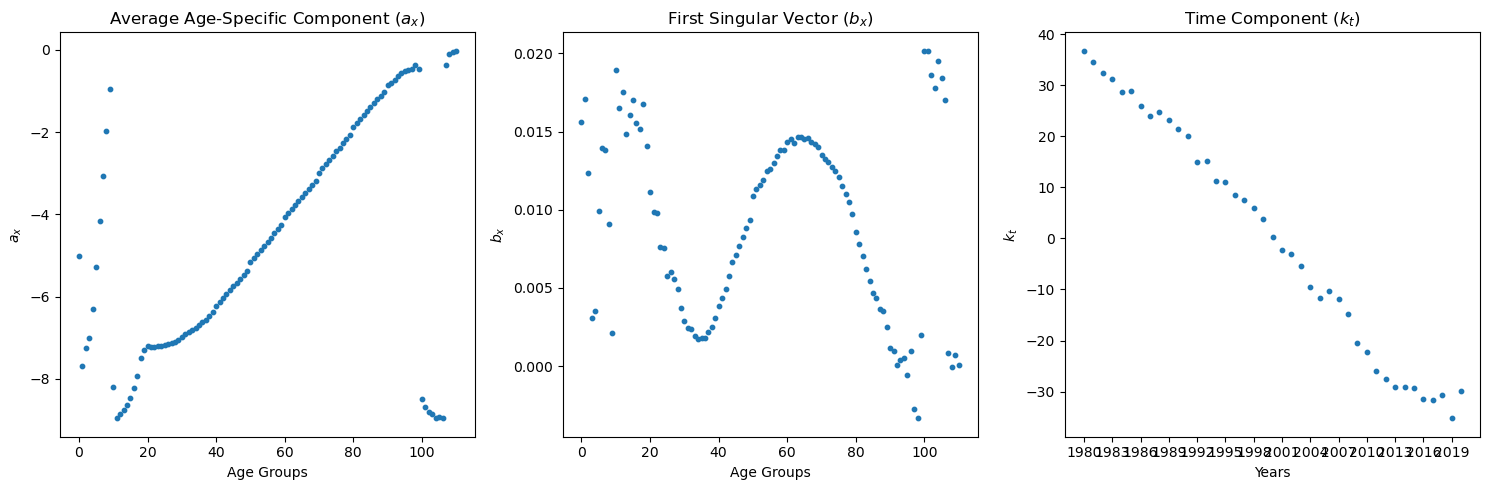


ADF Test Results for original of the series:
  Lag lag_0: ADF Statistic = -1.1236, p-value = 0.7056
  Lag lag_1: ADF Statistic = -1.0545, p-value = 0.7329
  Lag lag_2: ADF Statistic = -0.9478, p-value = 0.7718

ADF Test Results for first_diff of the series:
  Lag lag_0: ADF Statistic = -6.9825, p-value = 0.0000
  Lag lag_1: ADF Statistic = -3.7264, p-value = 0.0038
  Lag lag_2: ADF Statistic = -2.8885, p-value = 0.0467

ADF Test Results for second_diff of the series:
  Lag lag_0: ADF Statistic = -11.5279, p-value = 0.0000
  Lag lag_1: ADF Statistic = -7.0747, p-value = 0.0000
  Lag lag_2: ADF Statistic = -5.5526, p-value = 0.0000

ADF Test Results for third_diff of the series:
  Lag lag_0: ADF Statistic = -13.6203, p-value = 0.0000
  Lag lag_1: ADF Statistic = -8.7525, p-value = 0.0000
  Lag lag_2: ADF Statistic = -6.9092, p-value = 0.0000

Determined differencing order: d = 1


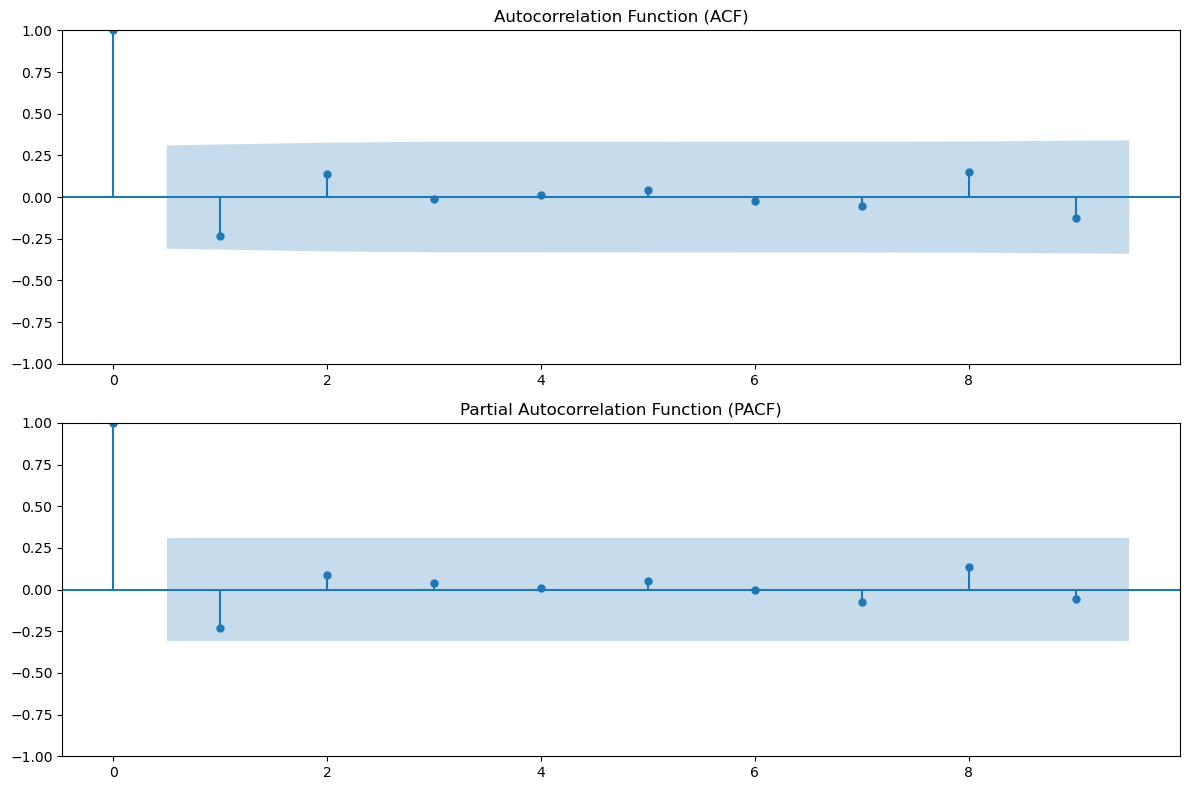

In [40]:
# Male period 2 model fitting

a_hat_male, b_hat_male, k_hat_male = fit_lee_carter_male_or_female(df_male_period3)
years = df_male_period3['Year'].unique()
age_groups = df_male_period3['Age'].unique()

plot_parameters(age_groups, a_hat_male, b_hat_male, years, k_hat_male)

differencing_order = perform_and_print_stationarity_tests(k_hat_male)

plot_acf_pacf(k_hat_male, differencing_order, subtract_lags=10)

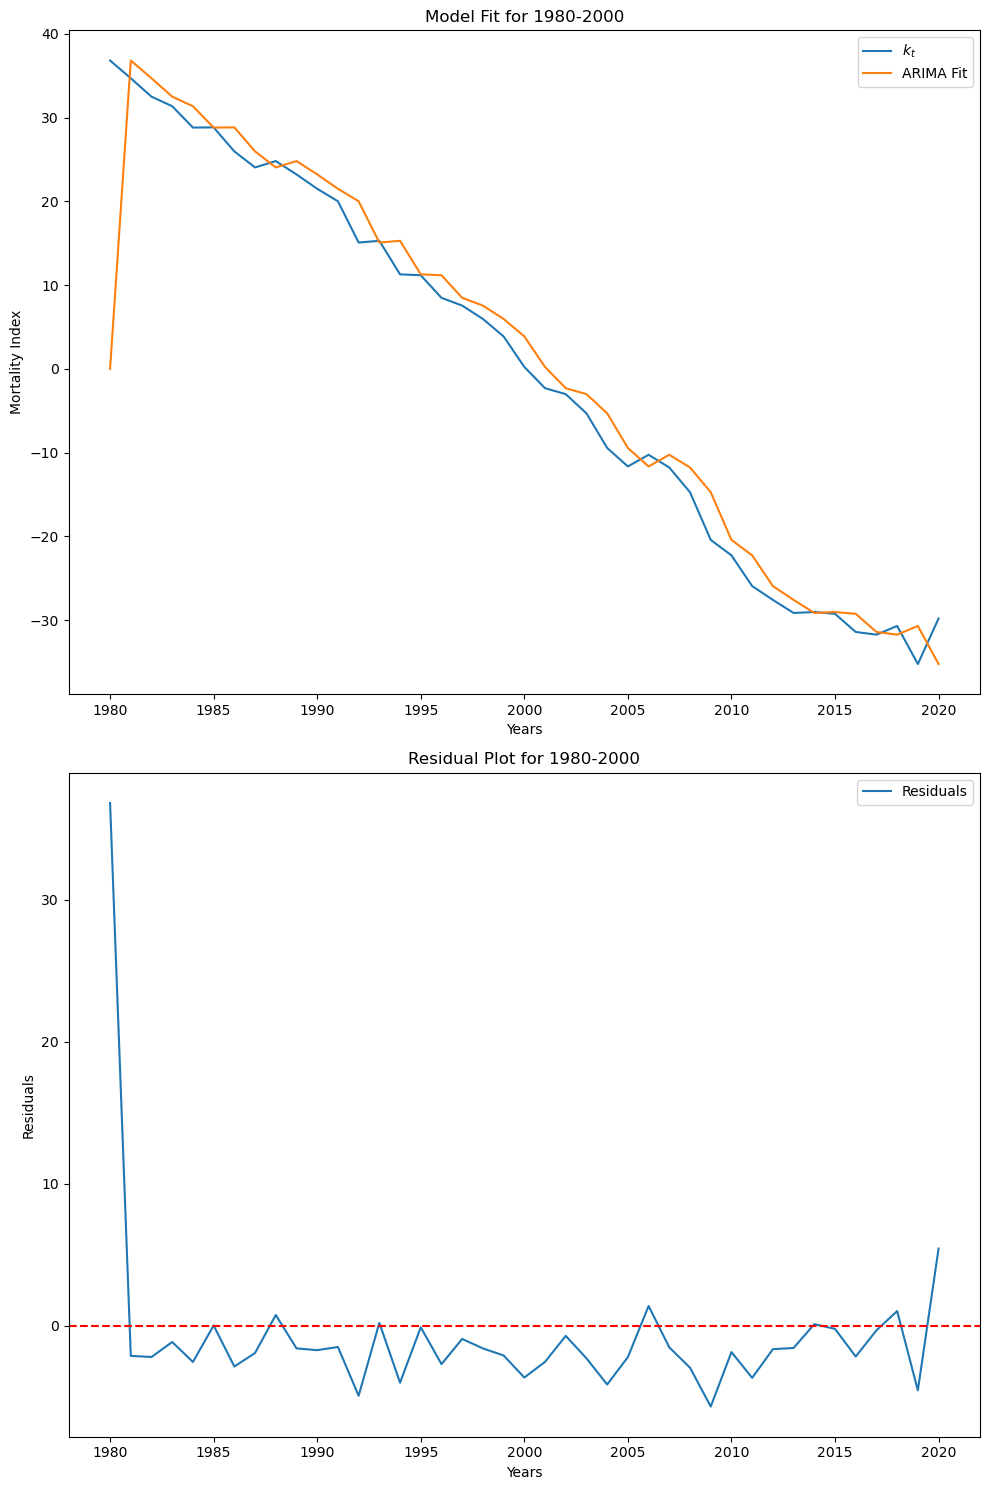

In [41]:
# Define the range for p and q based on ACF and PACF plots 
p = 0
q = 0

# No need for AIC here as there is only 1 combination of parameters
model = ARIMA(k_hat_male, order=(0, 1, 0))
best_model_fit = model.fit()
  
plot_model_fit_and_residuals(years, k_hat_male, best_model_fit)

# FEMALE DATA - PERIOD 1

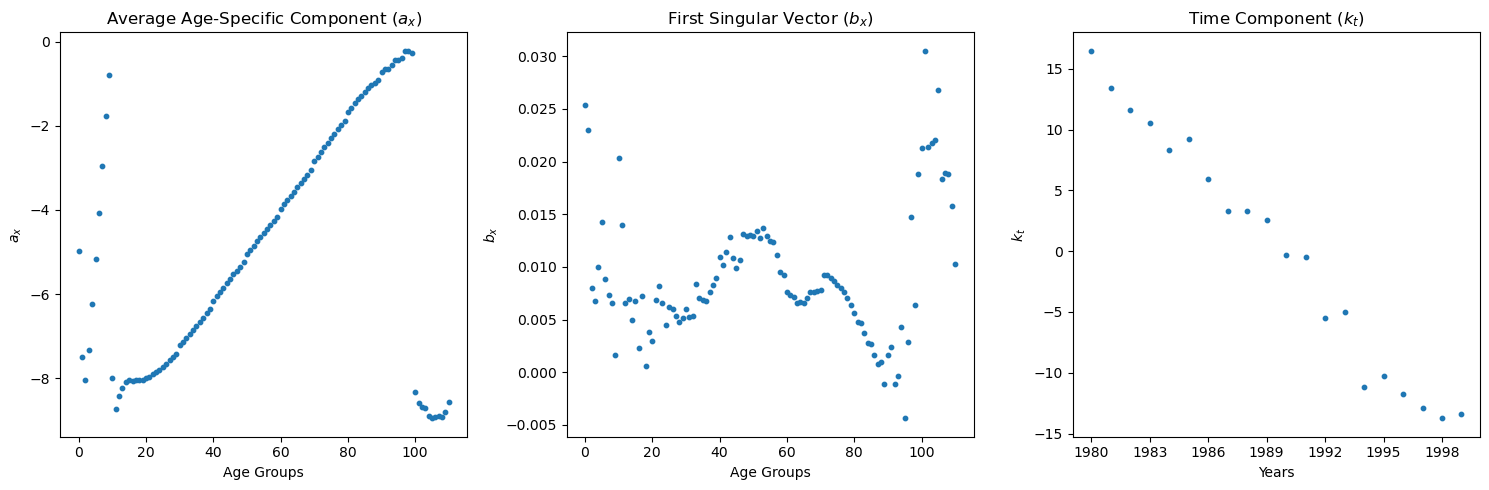


ADF Test Results for original of the series:
  Lag lag_0: ADF Statistic = -1.0380, p-value = 0.7391
  Lag lag_1: ADF Statistic = -0.8206, p-value = 0.8130
  Lag lag_2: ADF Statistic = -0.5586, p-value = 0.8801

ADF Test Results for first_diff of the series:
  Lag lag_0: ADF Statistic = -7.8369, p-value = 0.0000
  Lag lag_1: ADF Statistic = -3.1889, p-value = 0.0206
  Lag lag_2: ADF Statistic = -1.9635, p-value = 0.3028

ADF Test Results for second_diff of the series:
  Lag lag_0: ADF Statistic = -11.8751, p-value = 0.0000
  Lag lag_1: ADF Statistic = -5.6751, p-value = 0.0000
  Lag lag_2: ADF Statistic = -3.5508, p-value = 0.0068

ADF Test Results for third_diff of the series:
  Lag lag_0: ADF Statistic = -13.7914, p-value = 0.0000
  Lag lag_1: ADF Statistic = -7.1402, p-value = 0.0000
  Lag lag_2: ADF Statistic = -4.9012, p-value = 0.0000

Determined differencing order: d = 2


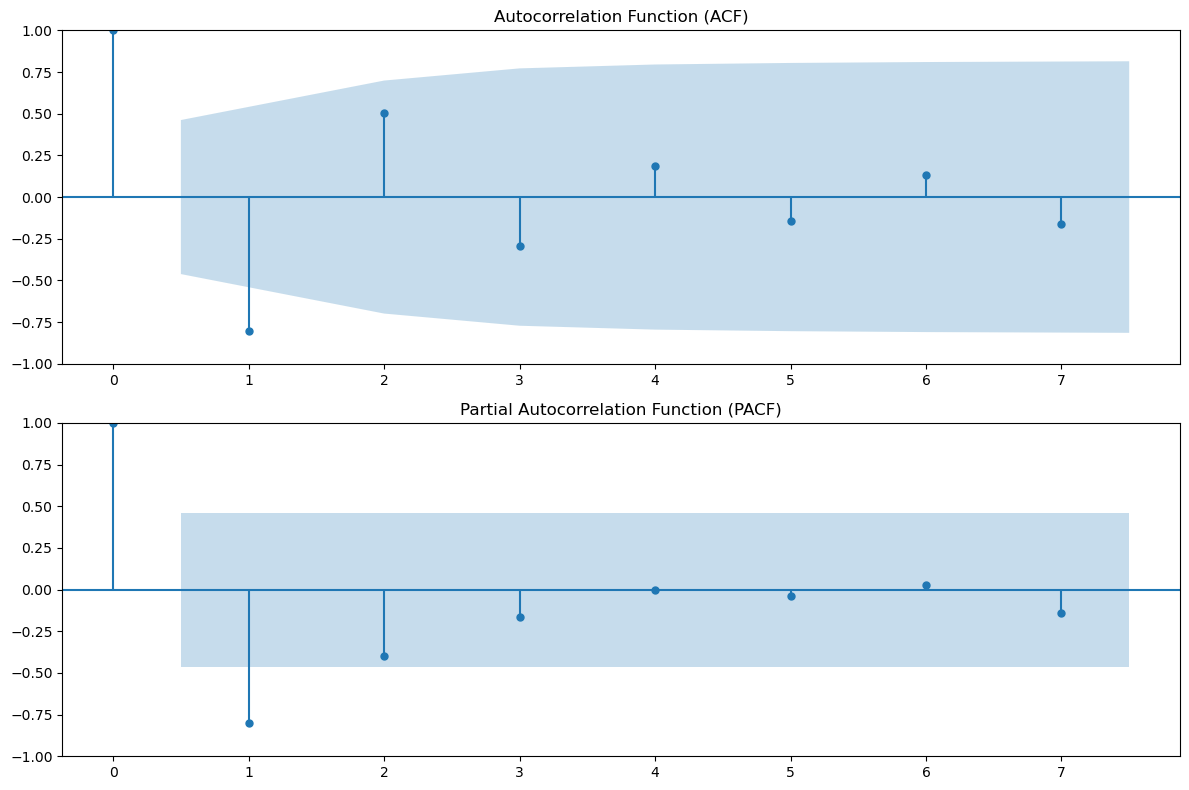

In [42]:
# female period 1 model fitting

a_hat_female_1, b_hat_female_1, k_hat_female_1 = fit_lee_carter_male_or_female(df_female_period1)
years_female_1 = df_female_period1['Year'].unique()
age_groups_female_1 = df_female_period1['Age'].unique()

plot_parameters(age_groups_female_1, a_hat_female_1, b_hat_female_1, years_female_1, k_hat_female_1)

differencing_order = perform_and_print_stationarity_tests(k_hat_female_1)

plot_acf_pacf(k_hat_female_1, differencing_order, subtract_lags=2)

Best ARIMA model: (1, 2, 1) with AIC: 77.46731174047707


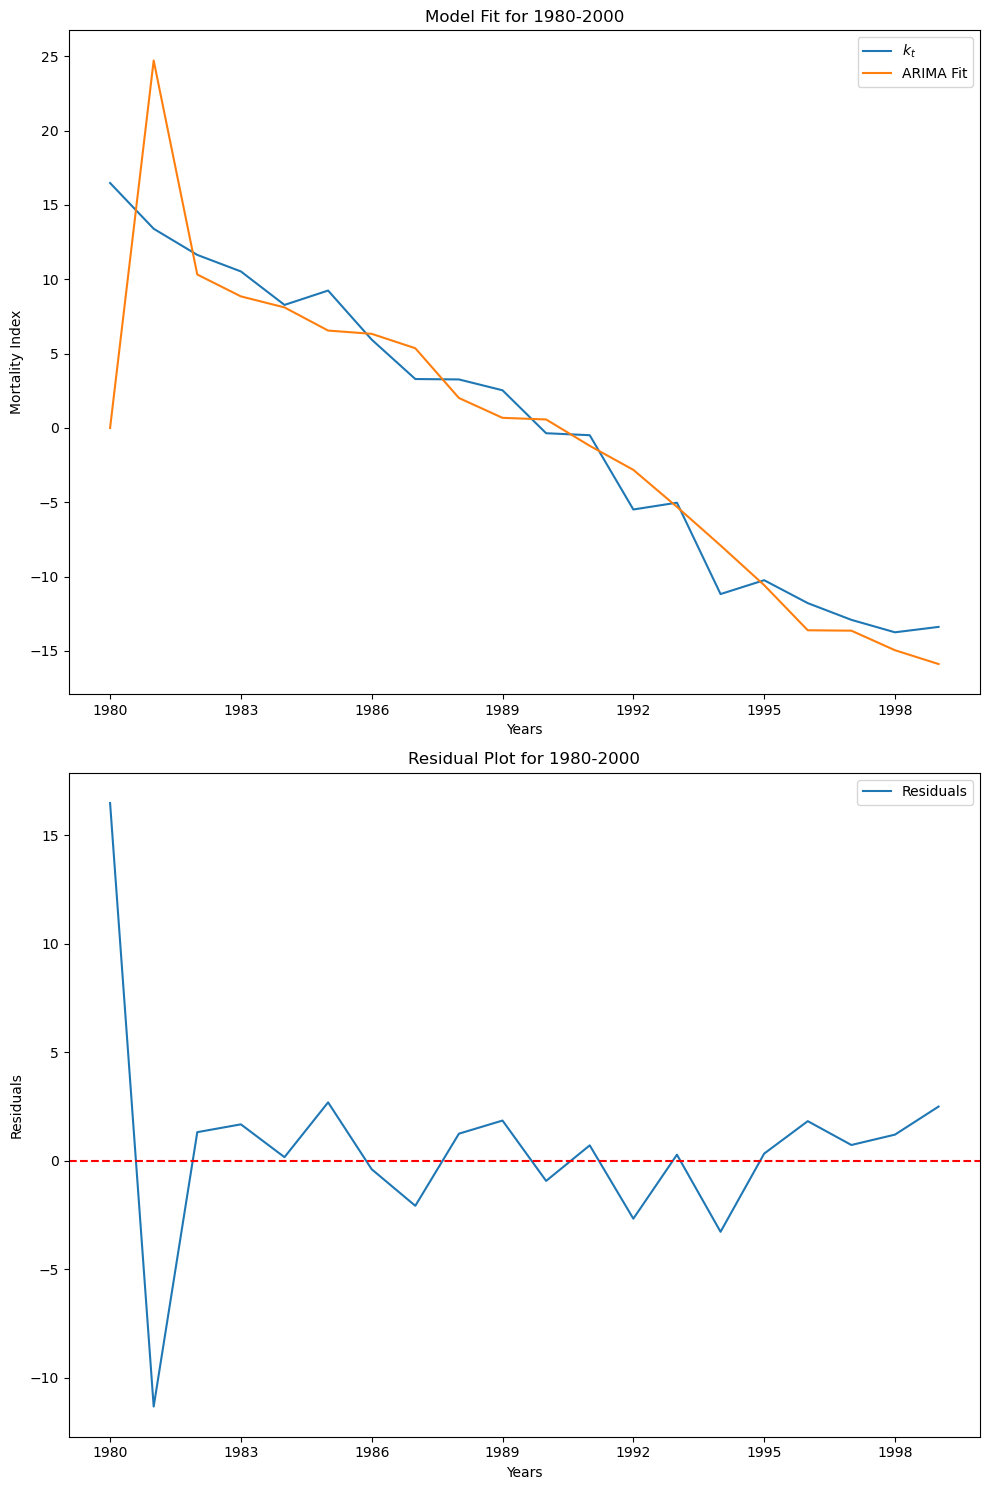

In [43]:
p_range = range(0, 2)  # Range for p based on PACF
q_range = range(0, 2)  # Range for q based on ACF

best_pdq, best_aic, best_model_fit = find_best_arima_model(k_hat_female_1, differencing_order, p_range, q_range)
    
plot_model_fit_and_residuals(years_female_1, k_hat_female_1, best_model_fit)

Mean Squared Error (MSE): 4.319901676393667
Mean Absolute Error (MAE): 1.5899445649325101


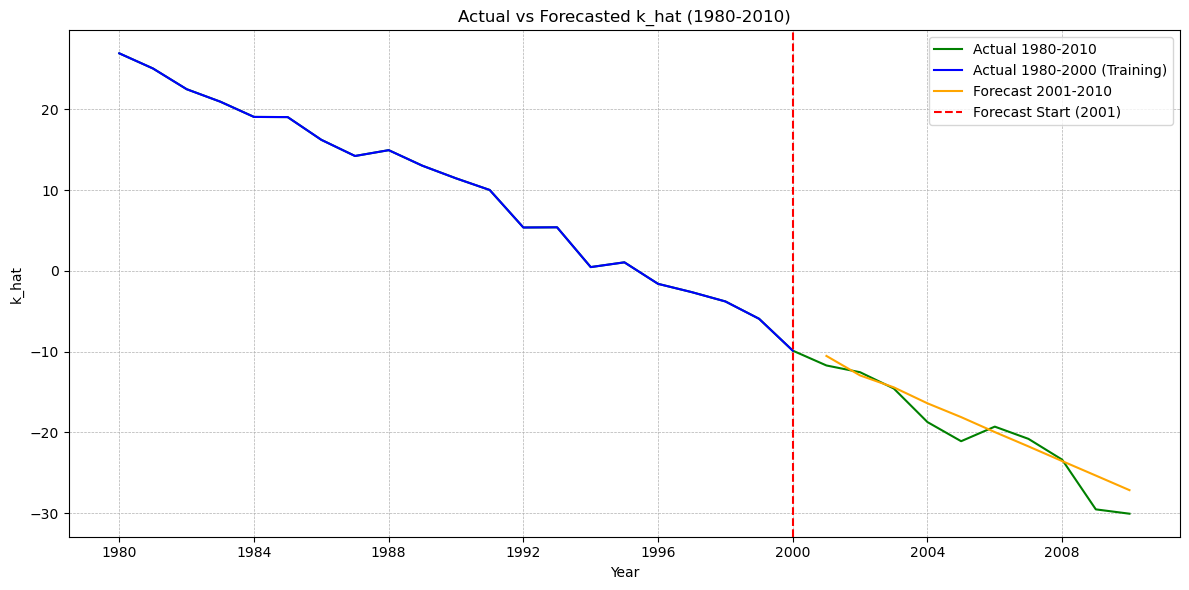

In [44]:
apply_lee_carter_forecast(df_male, start_year=1980, end_year=2010, train_end_year=2000, arima_order=(1,2,1), forecast_steps=10)

# FEMALE DATA - PERIOD 2

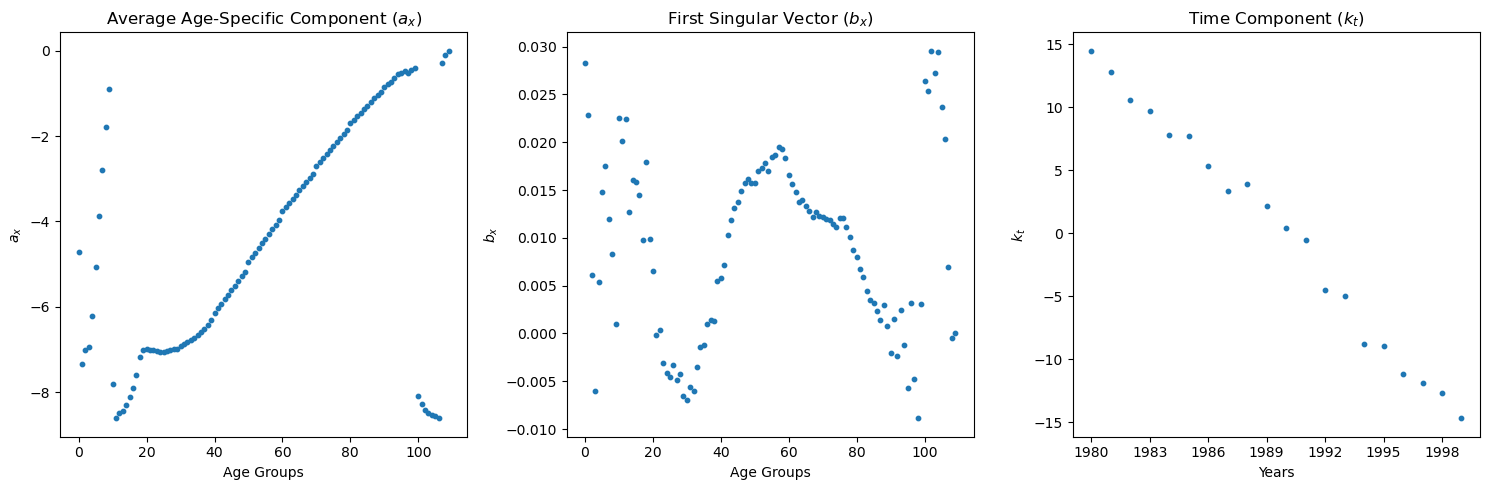


ADF Test Results for original of the series:
  Lag lag_0: ADF Statistic = -0.2114, p-value = 0.9371
  Lag lag_1: ADF Statistic = -0.0502, p-value = 0.9542
  Lag lag_2: ADF Statistic = 0.2516, p-value = 0.9750

ADF Test Results for first_diff of the series:
  Lag lag_0: ADF Statistic = -7.7097, p-value = 0.0000
  Lag lag_1: ADF Statistic = -3.2925, p-value = 0.0152
  Lag lag_2: ADF Statistic = -1.7748, p-value = 0.3930

ADF Test Results for second_diff of the series:
  Lag lag_0: ADF Statistic = -11.5377, p-value = 0.0000
  Lag lag_1: ADF Statistic = -6.2205, p-value = 0.0000
  Lag lag_2: ADF Statistic = -2.7458, p-value = 0.0664

ADF Test Results for third_diff of the series:
  Lag lag_0: ADF Statistic = -13.1449, p-value = 0.0000
  Lag lag_1: ADF Statistic = -8.7955, p-value = 0.0000
  Lag lag_2: ADF Statistic = -4.0064, p-value = 0.0014

Determined differencing order: d = 3


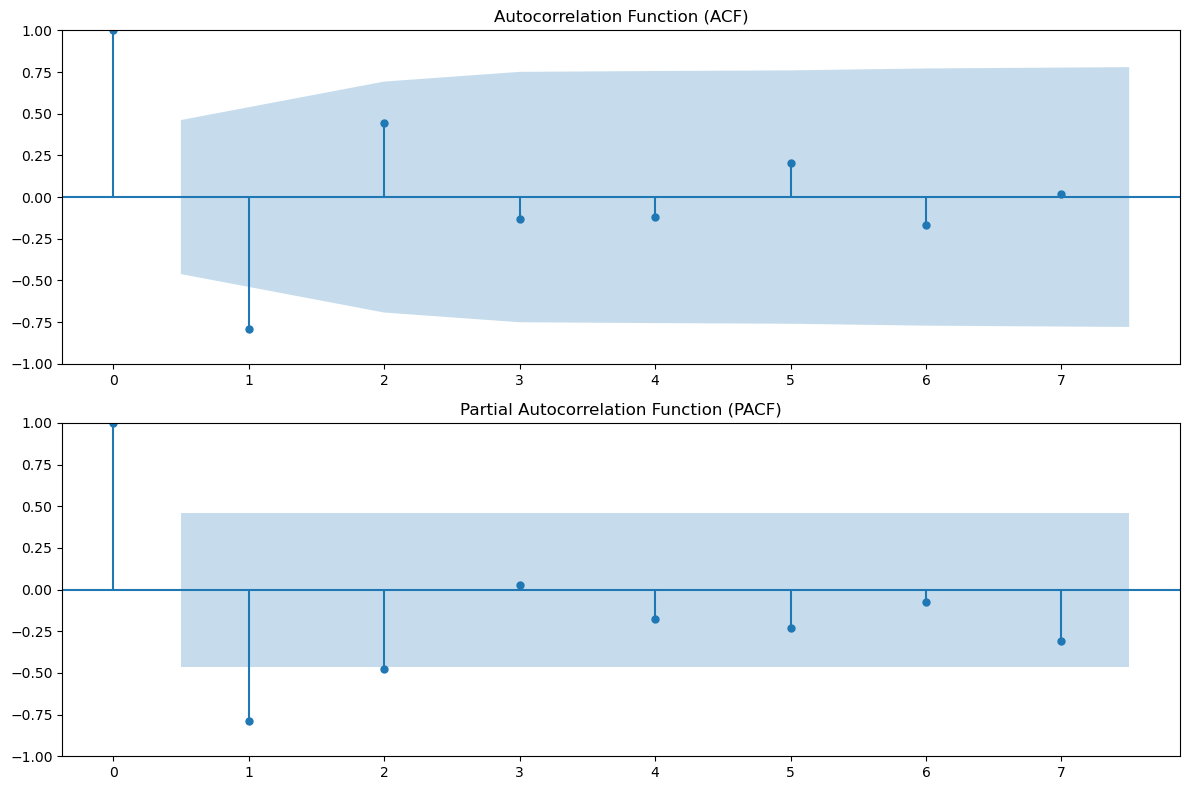

In [45]:
# Female period 2 model fitting

a_hat_female_2, b_hat_female_2, k_hat_female_2 = fit_lee_carter_male_or_female(df_male_period1)
years_female_2 = df_male_period1['Year'].unique()
age_groups_female_2 = df_male_period1['Age'].unique()

plot_parameters(age_groups_female_2, a_hat_female_2, b_hat_female_2, years_female_2, k_hat_female_2)

differencing_order = perform_and_print_stationarity_tests(k_hat_female_2)

plot_acf_pacf(k_hat_female_2, differencing_order, subtract_lags=2)

Best ARIMA model: (1, 3, 1) with AIC: 68.32335467808292


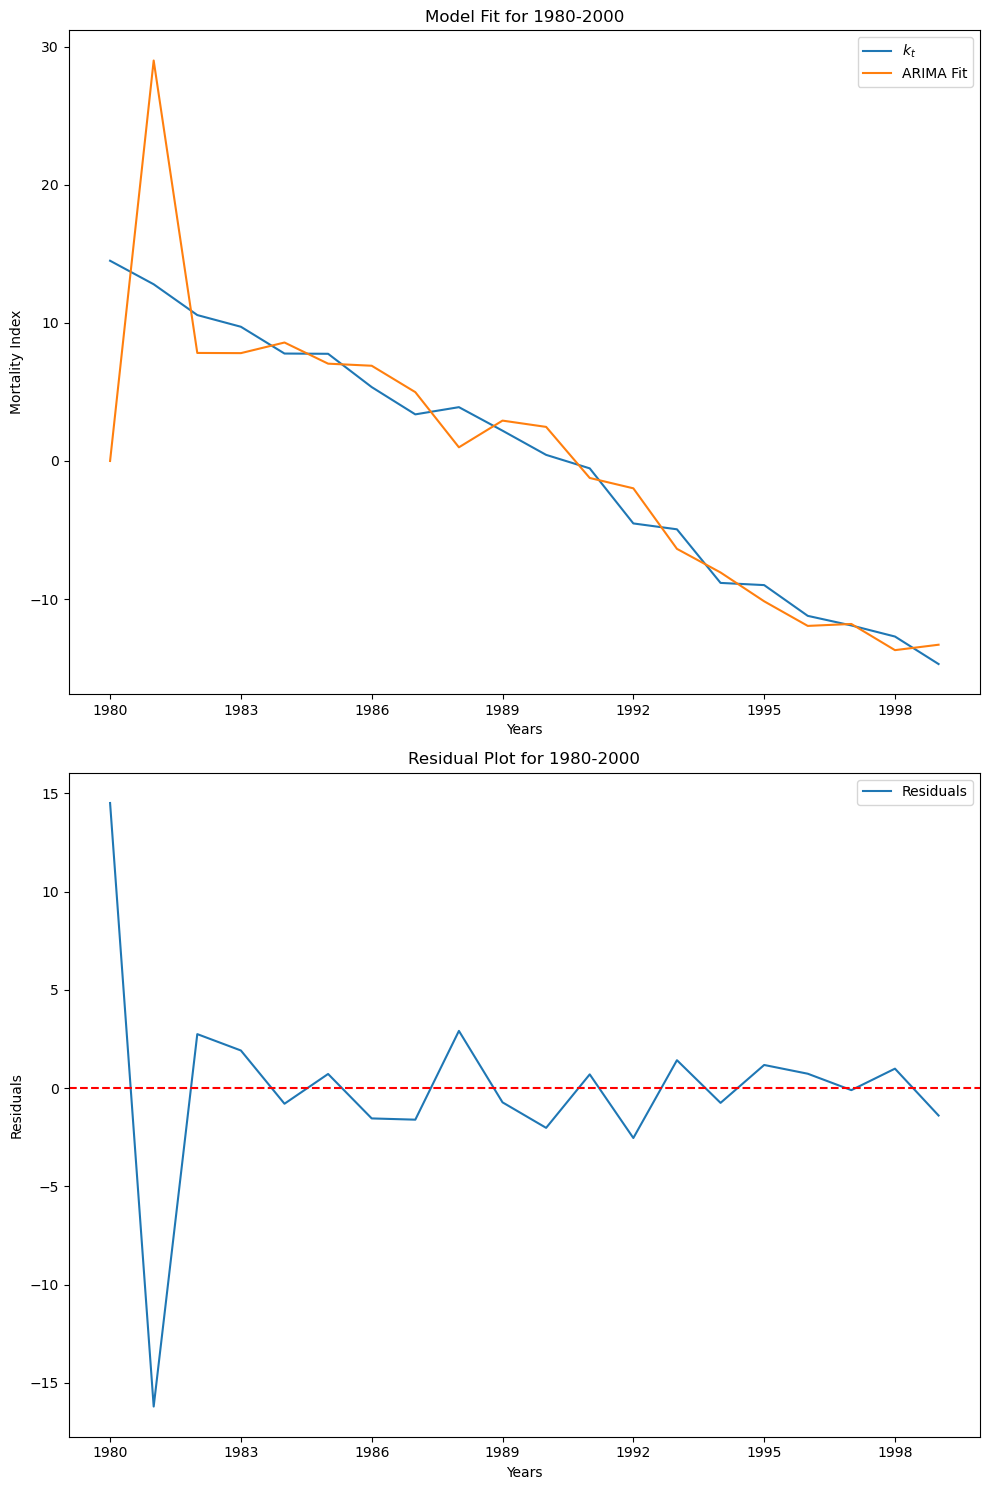

In [46]:
p_range = range(0, 2)  # Range for p based on PACF
q_range = range(0, 2)  # Range for q based on ACF

best_pdq, best_aic, best_model_fit = find_best_arima_model(k_hat_female_2, differencing_order, p_range, q_range)
    
plot_model_fit_and_residuals(years_female_2, k_hat_female_2, best_model_fit)

Mean Squared Error (MSE): 88.82651034984058
Mean Absolute Error (MAE): 8.19357542508648


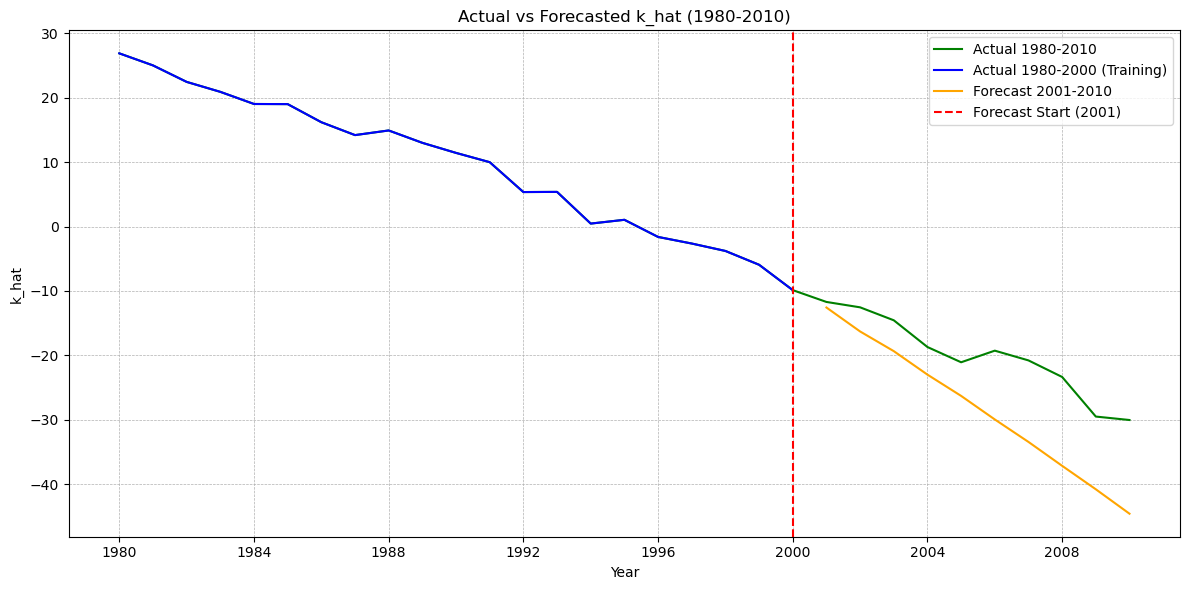

In [47]:
apply_lee_carter_forecast(df_male, start_year=1980, end_year=2010, train_end_year=2000, arima_order=(1,3,1), forecast_steps=10)

# COMPARE PERIOD 1 AND 2 FORECASTED RESULTS

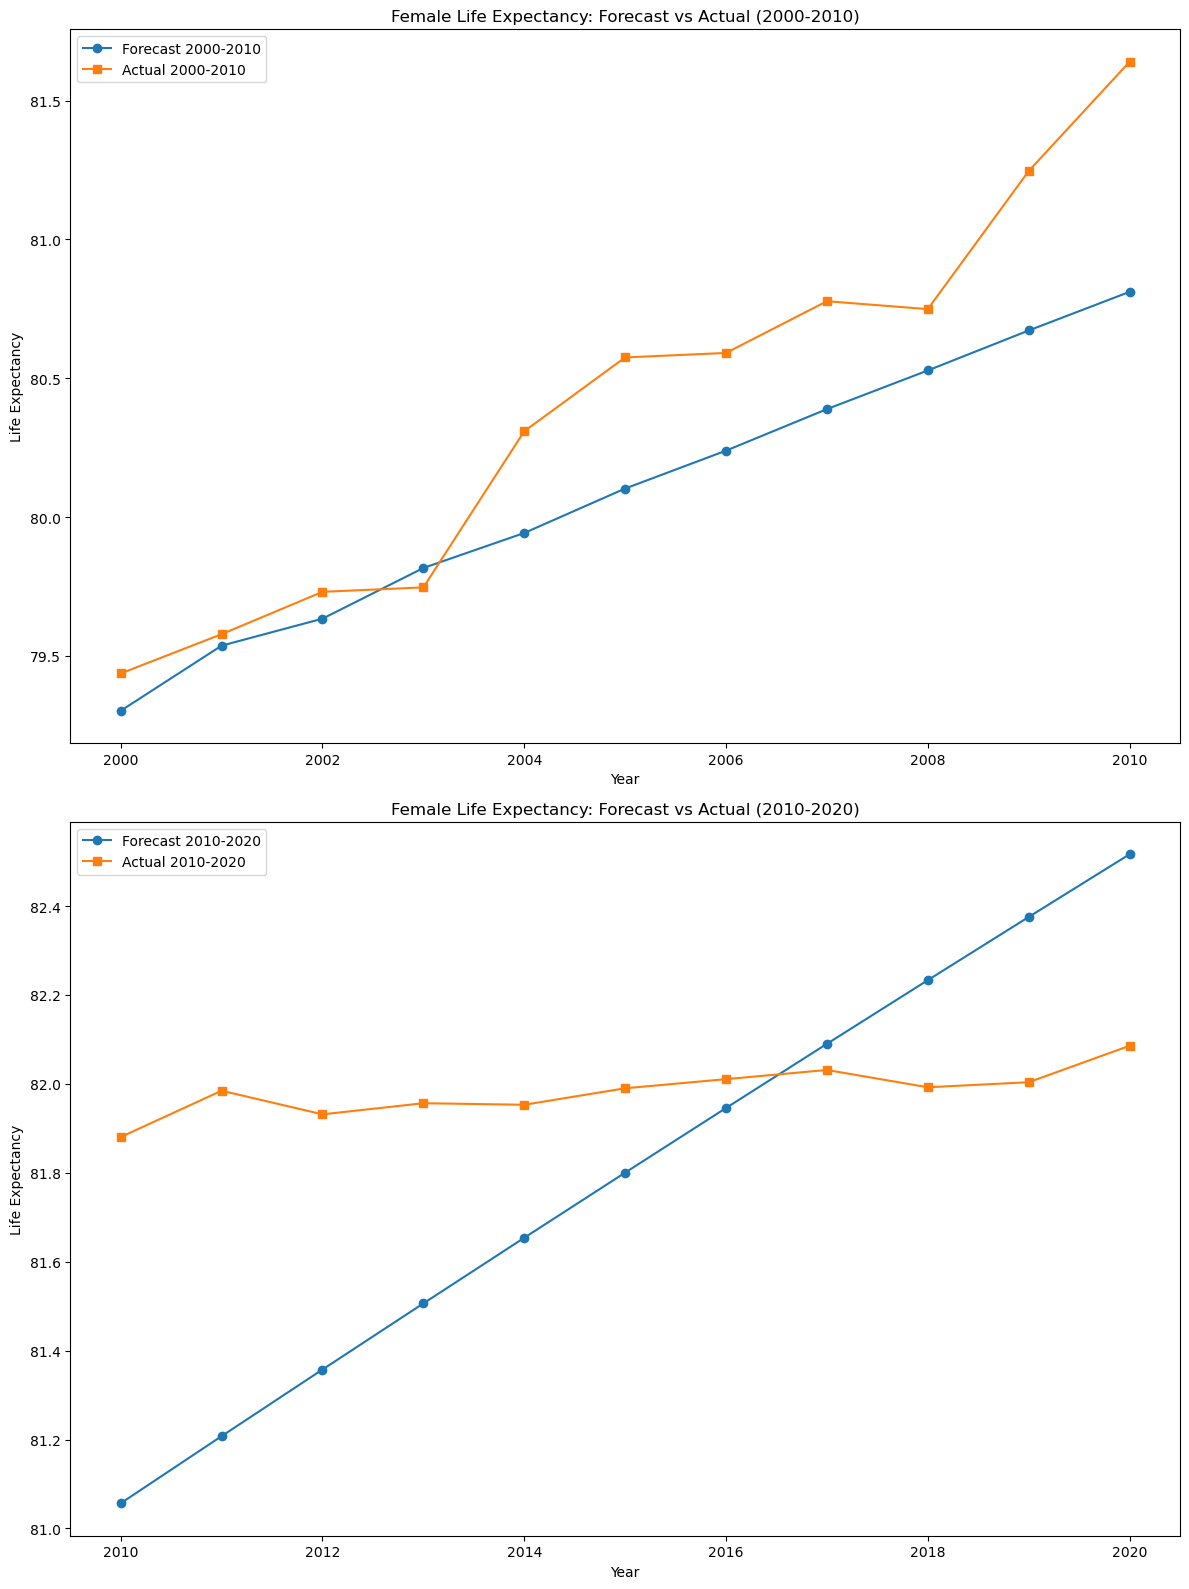

Average Forecasted female Life Expectancy 2000-2010: 80.08864250978021
Average Actual female Life Expectancy 2000-2010: 80.39817586409514
Average Forecasted female Life Expectancy 2010-2020: 81.79483064852853
Average Actual female Life Expectancy 2010-2020: 81.98365610508162


In [48]:
# First forecasting period: 2000-2010
df_female_train_1 = df_female[(df_female['Year'] >= 1980) & (df_female['Year'] <= 2000)]
a_x_female_1, b_x_female_1, k_t_female_1 = fit_lee_carter_male_or_female(df_female_train_1)
k_hat_female_forecast_1 = forecast_arima1(k_t_female_1, steps=11)  # 11 years forecast (2000-2010 inclusive)

# Convert forecast to mortality rates
mortality_rates_female_forecast_1 = convert_to_mortality_rates(a_x_female_1, b_x_female_1, k_hat_female_forecast_1)

# Calculate life expectancy for each forecasted year
life_expectancy_female_forecast_1 = calculate_life_expectancy(mortality_rates_female_forecast_1)

# Get actual mortality rates for 2000-2010
df_female_actual_1 = df_female[(df_female['Year'] >= 2000) & (df_female['Year'] <= 2010)]
a_x_female_actual_1, b_x_female_actual_1, k_t_female_actual_1 = fit_lee_carter_male_or_female(df_female_actual_1)
mortality_rates_female_actual_1 = convert_to_mortality_rates(a_x_female_actual_1, b_x_female_actual_1, k_t_female_actual_1)

# Calculate actual life expectancy for 2000-2010
life_expectancy_female_actual_1 = calculate_life_expectancy(mortality_rates_female_actual_1)

# Second forecasting period: 2010-2020
df_female_train_2 = df_female[(df_female['Year'] >= 1980) & (df_female['Year'] <= 2009)]
a_x_female_2, b_x_female_2, k_t_female_2 = fit_lee_carter_male_or_female(df_female_train_2)
k_hat_female_forecast_2 = forecast_arima2(k_t_female_2, steps=11)  # 11 years forecast (2010-2020 inclusive)

# Convert forecast to mortality rates
mortality_rates_female_forecast_2 = convert_to_mortality_rates(a_x_female_2, b_x_female_2, k_hat_female_forecast_2)

# Calculate life expectancy for each forecasted year
life_expectancy_female_forecast_2 = calculate_life_expectancy(mortality_rates_female_forecast_2)

# Get actual mortality rates for 2010-2020
df_female_actual_2 = df_female[(df_female['Year'] >= 2010) & (df_female['Year'] <= 2020)]
a_x_female_actual_2, b_x_female_actual_2, k_t_female_actual_2 = fit_lee_carter_male_or_female(df_female_actual_2)
mortality_rates_female_actual_2 = convert_to_mortality_rates(a_x_female_actual_2, b_x_female_actual_2, k_t_female_actual_2)

# Calculate actual life expectancy for 2010-2020
life_expectancy_female_actual_2 = calculate_life_expectancy(mortality_rates_female_actual_2)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Plot for 2000-2010
years_1 = range(2000, 2011)
ax1.plot(years_1, life_expectancy_female_forecast_1, label='Forecast 2000-2010', marker='o')
ax1.plot(years_1, life_expectancy_female_actual_1, label='Actual 2000-2010', marker='s')
ax1.set_title('Female Life Expectancy: Forecast vs Actual (2000-2010)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Life Expectancy')
ax1.legend()

# Plot for 2010-2020
years_2 = range(2010, 2021)
ax2.plot(years_2, life_expectancy_female_forecast_2, label='Forecast 2010-2020', marker='o')
ax2.plot(years_2, life_expectancy_female_actual_2, label='Actual 2010-2020', marker='s')
ax2.set_title('Female Life Expectancy: Forecast vs Actual (2010-2020)')
ax2.set_xlabel('Year')
ax2.set_ylabel('Life Expectancy')
ax2.legend()

plt.tight_layout()
plt.show()

# Print some summary statistics
print("Average Forecasted female Life Expectancy 2000-2010:", np.mean(life_expectancy_female_forecast_1))
print("Average Actual female Life Expectancy 2000-2010:", np.mean(life_expectancy_female_actual_1))
print("Average Forecasted female Life Expectancy 2010-2020:", np.mean(life_expectancy_female_forecast_2))
print("Average Actual female Life Expectancy 2010-2020:", np.mean(life_expectancy_female_actual_2))

In [49]:
# Calculate errors for female data
errors_female_1 = np.array(life_expectancy_female_actual_1) - np.array(life_expectancy_female_forecast_1)
errors_female_2 = np.array(life_expectancy_female_actual_2) - np.array(life_expectancy_female_forecast_2)

# Calculate percentage errors for female data
percent_errors_female_1 = (errors_female_1 / np.array(life_expectancy_female_actual_1)) * 100
percent_errors_female_2 = (errors_female_2 / np.array(life_expectancy_female_actual_2)) * 100

# Calculate MAE and RMSE for female data
mae_female_1 = np.mean(np.abs(errors_female_1))
rmse_female_1 = np.sqrt(np.mean(errors_female_1**2))
mae_female_2 = np.mean(np.abs(errors_female_2))
rmse_female_2 = np.sqrt(np.mean(errors_female_2**2))

# Print summary statistics for female data
print("\nfemale Life Expectancy - Period 2000-2010:")
print(f"Mean Absolute Error (MAE): {mae_female_1:.2f} years")
print(f"Root Mean Squared Error (RMSE): {rmse_female_1:.2f} years")
print(f"Mean Percentage Error: {np.mean(percent_errors_female_1):.2f}%")

print("\nfemale Life Expectancy - Period 2010-2020:")
print(f"Mean Absolute Error (MAE): {mae_female_2:.2f} years")
print(f"Root Mean Squared Error (RMSE): {rmse_female_2:.2f} years")
print(f"Mean Percentage Error: {np.mean(percent_errors_female_2):.2f}%")


female Life Expectancy - Period 2000-2010:
Mean Absolute Error (MAE): 0.32 years
Root Mean Squared Error (RMSE): 0.40 years
Mean Percentage Error: 0.38%

female Life Expectancy - Period 2010-2020:
Mean Absolute Error (MAE): 0.39 years
Root Mean Squared Error (RMSE): 0.46 years
Mean Percentage Error: 0.23%


# FEMALE DATA - 1980-2020

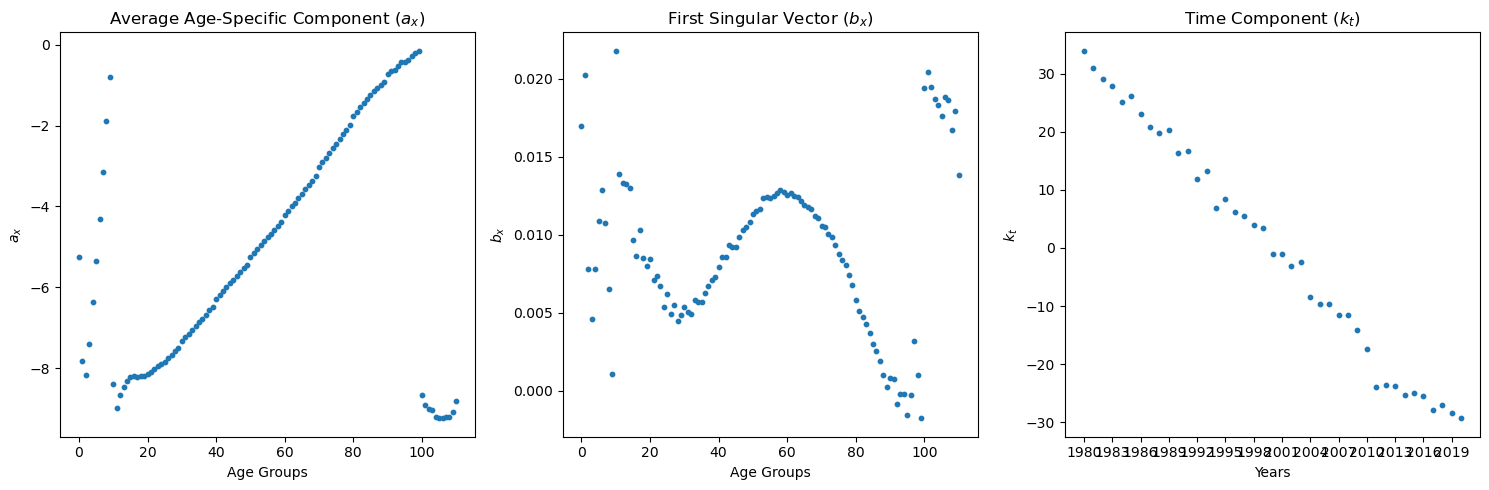


ADF Test Results for original of the series:
  Lag lag_0: ADF Statistic = -0.9233, p-value = 0.7802
  Lag lag_1: ADF Statistic = -0.9634, p-value = 0.7664
  Lag lag_2: ADF Statistic = -0.7885, p-value = 0.8225

ADF Test Results for first_diff of the series:
  Lag lag_0: ADF Statistic = -10.5545, p-value = 0.0000
  Lag lag_1: ADF Statistic = -4.8903, p-value = 0.0000
  Lag lag_2: ADF Statistic = -4.4175, p-value = 0.0003

ADF Test Results for second_diff of the series:
  Lag lag_0: ADF Statistic = -16.4336, p-value = 0.0000
  Lag lag_1: ADF Statistic = -7.3798, p-value = 0.0000
  Lag lag_2: ADF Statistic = -6.4412, p-value = 0.0000

ADF Test Results for third_diff of the series:
  Lag lag_0: ADF Statistic = -20.7567, p-value = 0.0000
  Lag lag_1: ADF Statistic = -9.2139, p-value = 0.0000
  Lag lag_2: ADF Statistic = -8.3075, p-value = 0.0000

Determined differencing order: d = 1


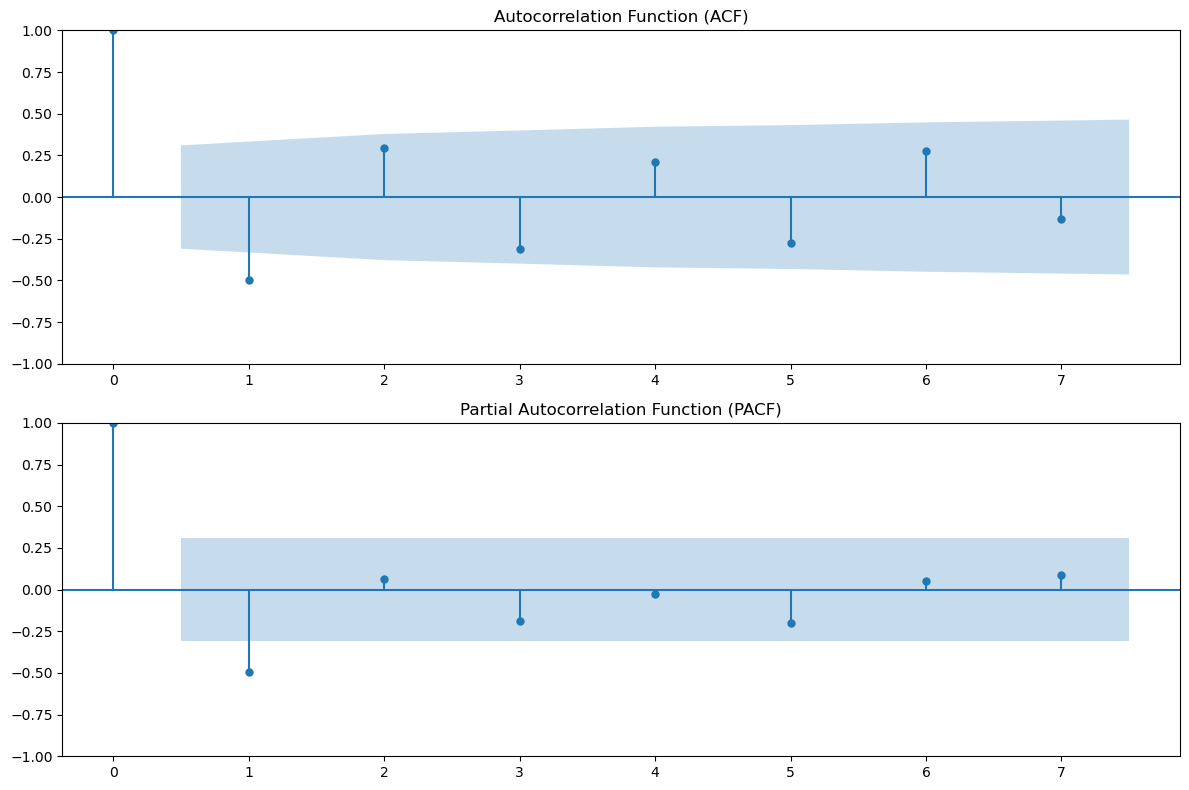

In [50]:
# Male period 1 model fitting

a_hat_female, b_hat_female, k_hat_female = fit_lee_carter_male_or_female(df_female_period3)
years = df_female_period3['Year'].unique()
age_groups = df_female_period3['Age'].unique()

plot_parameters(age_groups, a_hat_female, b_hat_female, years, k_hat_female)

differencing_order = perform_and_print_stationarity_tests(k_hat_female)

plot_acf_pacf(k_hat_female, differencing_order, subtract_lags=12)

Best ARIMA model: (1, 1, 1) with AIC: 181.6177212798082


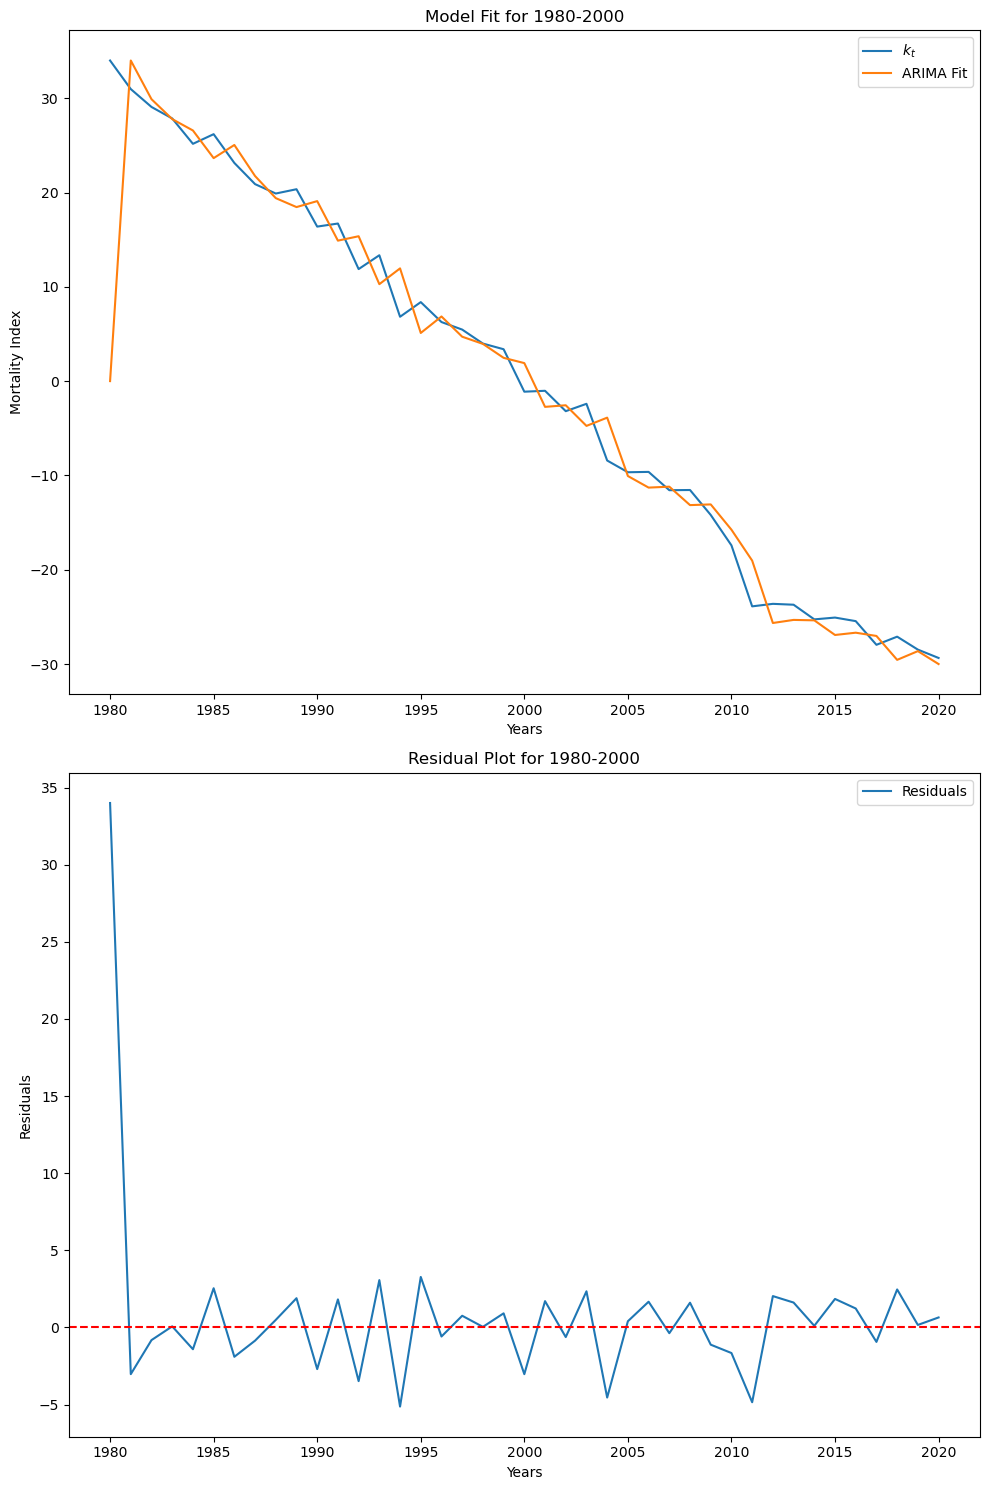

In [51]:
p_range = range(0, 2)  # Range for p based on PACF
q_range = range(0, 2)  # Range for q based on ACF

best_pdq, best_aic, best_model_fit = find_best_arima_model(k_hat_female, differencing_order, p_range, q_range)
    
plot_model_fit_and_residuals(years, k_hat_female, best_model_fit)

# COMBINE MALE AND FEMALE LIFE EXPECTANCIES

In [52]:
def calculate_life_expectancy(mortality_rates):
    survival_prob = 1 - mortality_rates
    cumulative_survival = np.cumprod(survival_prob, axis=0)
    life_expectancy = np.sum(cumulative_survival, axis=0)
    return life_expectancy

def combine_life_expectancies(male_life_expectancy, female_life_expectancy, male_population, female_population):
    total_population = male_population + female_population
    male_weight = male_population / total_population
    female_weight = female_population / total_population
    return male_weight * male_life_expectancy + female_weight * female_life_expectancy

In [53]:
# Calculate life expectancies from forecast data
life_expectancy_normal_model_1 = calculate_life_expectancy(mortality_rates_forecast_1)
life_expectancy_normal_model_2 = calculate_life_expectancy(mortality_rates_forecast_2)
life_expectancy_male_1 = calculate_life_expectancy(mortality_rates_male_forecast_1)
life_expectancy_male_2 = calculate_life_expectancy(mortality_rates_male_forecast_2)
life_expectancy_female_1 = calculate_life_expectancy(mortality_rates_female_forecast_1)
life_expectancy_female_2 = calculate_life_expectancy(mortality_rates_female_forecast_2)

# Get population data
male_population_1 = df_male[(df_male['Year'] >= 2000) & (df_male['Year'] <= 2010)].groupby('Year')['population'].sum().values
female_population_1 = df_female[(df_female['Year'] >= 2000) & (df_female['Year'] <= 2010)].groupby('Year')['population'].sum().values
male_population_2 = df_male[(df_male['Year'] >= 2010) & (df_male['Year'] <= 2020)].groupby('Year')['population'].sum().values
female_population_2 = df_female[(df_female['Year'] >= 2010) & (df_female['Year'] <= 2020)].groupby('Year')['population'].sum().values

# Combine life expectancies
life_expectancy_combined_1 = combine_life_expectancies(life_expectancy_male_1, life_expectancy_female_1, male_population_1, female_population_1)
life_expectancy_combined_2 = combine_life_expectancies(life_expectancy_male_2, life_expectancy_female_2, male_population_2, female_population_2)

In [54]:
# Function to calculate yearly life expectancies
def calculate_yearly_life_expectancies(df, start_year, end_year):
    df_filtered = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]
    mortality_rates = df_filtered.groupby(['Year', 'Age'])['total_mortality_rate'].mean().unstack(level='Age')
    
    yearly_life_expectancies = []
    for year in mortality_rates.index:
        year_mortality = mortality_rates.loc[year].values
        life_exp = calculate_life_expectancy(year_mortality)
        yearly_life_expectancies.append(life_exp)
    
    return np.array(yearly_life_expectancies)

# Calculate life expectancies for two periods
life_expectancy_2000_2010 = calculate_yearly_life_expectancies(df, 2000, 2010)
life_expectancy_2010_2020 = calculate_yearly_life_expectancies(df, 2010, 2020)

In [55]:
# Create DataFrames for each period
def create_results_df(period, years, original_lc, gendered_lc, actual):
    return pd.DataFrame({
        'Year': years,
        'Original Lee-Carter': original_lc,
        'Gendered Lee-Carter': gendered_lc,
        'Actual': actual
    })

# Period 1 (2000-2010)
years_1 = range(2000, 2011)
results_df_1 = create_results_df(
    'Period 1 (2000-2010)',
    years_1,
    life_expectancy_normal_model_1,
    life_expectancy_combined_1,
    life_expectancy_2000_2010
)

# Period 2 (2010-2020)
years_2 = range(2010, 2021)
results_df_2 = create_results_df(
    'Period 2 (2010-2020)',
    years_2,
    life_expectancy_normal_model_2,
    life_expectancy_combined_2,
    life_expectancy_2010_2020
)

# Combine the results
results_df = pd.concat([results_df_1, results_df_2], keys=['Period 1 (2000-2010)', 'Period 2 (2010-2020)'])

# Calculate mean life expectancies for each period and method
mean_results = results_df.groupby(level=0).mean()
mean_results.index.name = 'Period'
mean_results.reset_index(inplace=True)

# Print the detailed results
print("Detailed Life Expectancy Results:")
print(results_df.to_string())

print("\nMean Life Expectancy Results:")
print(mean_results.to_string(index=False))

Detailed Life Expectancy Results:
                         Year  Original Lee-Carter  Gendered Lee-Carter     Actual
Period 1 (2000-2010) 0   2000            76.998278            77.031199  77.038067
                     1   2001            77.233896            77.275938  77.312372
                     2   2002            77.377199            77.413666  77.429844
                     3   2003            77.569530            77.610489  77.518374
                     4   2004            77.731761            77.770190  78.075717
                     5   2005            77.908262            77.949772  78.280003
                     6   2006            78.074212            78.114725  78.512950
                     7   2007            78.243552            78.285891  78.695336
                     8   2008            78.408506            78.450280  78.816991
                     9   2009            78.573465            78.616482  79.316922
                     10  2010            78.736000   

In [56]:
def calculate_metrics(df):
    metrics = {}
    
    # Calculate MAE and MSE for each model
    metrics['Original LC MAE'] = np.mean(np.abs(df['Original Lee-Carter'] - df['Actual']))
    metrics['Gendered LC MAE'] = np.mean(np.abs(df['Gendered Lee-Carter'] - df['Actual']))
    metrics['Original LC MSE'] = np.mean((df['Original Lee-Carter'] - df['Actual'])**2)
    metrics['Gendered LC MSE'] = np.mean((df['Gendered Lee-Carter'] - df['Actual'])**2)
    
    # Determine which model is closer more often
    df['Closer Model'] = np.where(
        np.abs(df['Original Lee-Carter'] - df['Actual']) < np.abs(df['Gendered Lee-Carter'] - df['Actual']),
        'Original LC', 'Gendered LC'
    )
    closer_model_counts = df['Closer Model'].value_counts()
    closer_model_percentages = df['Closer Model'].value_counts(normalize=True) * 100
    
    for model in closer_model_counts.index:
        metrics[f'{model} Count'] = closer_model_counts[model]
        metrics[f'{model} Percentage'] = closer_model_percentages[model]
    
    return metrics

# Calculate metrics for each period
metrics_1 = calculate_metrics(results_df_1)
metrics_2 = calculate_metrics(results_df_2)

# Calculate overall metrics
overall_metrics = calculate_metrics(results_df.reset_index(level=0, drop=True))

# Create a DataFrame with all metrics
metrics_df = pd.DataFrame({
    'Period 1 (2000-2010)': metrics_1,
    'Period 2 (2010-2020)': metrics_2,
    'Overall': overall_metrics
}).T

# Print the metrics
print("Additional Analysis Metrics:")
print(metrics_df.to_string())

# Determine overall better model
print("\nOverall Model Comparison:")
if overall_metrics['Original LC MAE'] < overall_metrics['Gendered LC MAE']:
    print("The Original Lee-Carter model has a lower overall MAE.")
else:
    print("The Gendered Lee-Carter model has a lower overall MAE.")

if overall_metrics['Original LC MSE'] < overall_metrics['Gendered LC MSE']:
    print("The Original Lee-Carter model has a lower overall MSE.")
else:
    print("The Gendered Lee-Carter model has a lower overall MSE.")

print(f"\nThe Original Lee-Carter model was closer in {overall_metrics['Original LC Count']} years "
      f"({overall_metrics['Original LC Percentage']:.2f}% of the time).")
print(f"The Gendered Lee-Carter model was closer in {overall_metrics['Gendered LC Count']} years "
      f"({overall_metrics['Gendered LC Percentage']:.2f}% of the time).")

Additional Analysis Metrics:
                      Original LC MAE  Gendered LC MAE  Original LC MSE  Gendered LC MSE  Gendered LC Count  Gendered LC Percentage  Original LC Count  Original LC Percentage
Period 1 (2000-2010)         0.344591         0.311749         0.185668         0.159294               10.0               90.909091                1.0                9.090909
Period 2 (2010-2020)         0.377952         0.384104         0.266170         0.271900                5.0               45.454545                6.0               54.545455
Overall                      0.361271         0.347926         0.225919         0.215597               15.0               68.181818                7.0               31.818182

Overall Model Comparison:
The Gendered Lee-Carter model has a lower overall MAE.
The Gendered Lee-Carter model has a lower overall MSE.

The Original Lee-Carter model was closer in 7 years (31.82% of the time).
The Gendered Lee-Carter model was closer in 15 years (68.18

In [57]:
def calculate_concise_metrics(df):
    df['Closer Model'] = np.where(
        np.abs(df['Original Lee-Carter'] - df['Actual']) < np.abs(df['Gendered Lee-Carter'] - df['Actual']),
        'Original LC', 'Gendered LC'
    )
    closer_model_counts = df['Closer Model'].value_counts()
    closer_model_percentages = df['Closer Model'].value_counts(normalize=True) * 100
    
    return {
        'Original LC Count': closer_model_counts.get('Original LC', 0),
        'Original LC Percentage': closer_model_percentages.get('Original LC', 0),
        'Gendered LC Count': closer_model_counts.get('Gendered LC', 0),
        'Gendered LC Percentage': closer_model_percentages.get('Gendered LC', 0)
    }

# Calculate metrics for each period and overall
metrics_1 = calculate_concise_metrics(results_df_1)
metrics_2 = calculate_concise_metrics(results_df_2)
overall_metrics = calculate_concise_metrics(results_df.reset_index(level=0, drop=True))

# Print results as a list
print("Comparative Metrics:")
print("\nPeriod 1 (2000-2010):")
print(f"- Original Lee-Carter closer: {metrics_1['Original LC Count']} years ({metrics_1['Original LC Percentage']:.2f}%)")
print(f"- Gendered Lee-Carter closer: {metrics_1['Gendered LC Count']} years ({metrics_1['Gendered LC Percentage']:.2f}%)")

print("\nPeriod 2 (2010-2020):")
print(f"- Original Lee-Carter closer: {metrics_2['Original LC Count']} years ({metrics_2['Original LC Percentage']:.2f}%)")
print(f"- Gendered Lee-Carter closer: {metrics_2['Gendered LC Count']} years ({metrics_2['Gendered LC Percentage']:.2f}%)")

print("\nOverall (2000-2020):")
print(f"- Original Lee-Carter closer: {overall_metrics['Original LC Count']} years ({overall_metrics['Original LC Percentage']:.2f}%)")
print(f"- Gendered Lee-Carter closer: {overall_metrics['Gendered LC Count']} years ({overall_metrics['Gendered LC Percentage']:.2f}%)")

# Determine overall better model
overall_better = "Original Lee-Carter" if overall_metrics['Original LC Count'] > overall_metrics['Gendered LC Count'] else "Gendered Lee-Carter"
print(f"\nOverall better model: {overall_better}")

Comparative Metrics:

Period 1 (2000-2010):
- Original Lee-Carter closer: 1 years (9.09%)
- Gendered Lee-Carter closer: 10 years (90.91%)

Period 2 (2010-2020):
- Original Lee-Carter closer: 6 years (54.55%)
- Gendered Lee-Carter closer: 5 years (45.45%)

Overall (2000-2020):
- Original Lee-Carter closer: 7 years (31.82%)
- Gendered Lee-Carter closer: 15 years (68.18%)

Overall better model: Gendered Lee-Carter


# PENSION SECTION

In [58]:
# Define the GitHub URLs for the files
pension_types_url = 'https://raw.githubusercontent.com/gg321321/Dissertation-277165-Final/main/pension_types.csv'
preserved_DB_pension_wealth_url = 'https://raw.githubusercontent.com/gg321321/Dissertation-277165-Final/main/preserved_DB_pension_wealth.csv'
median_pension_wealth_url = 'https://raw.githubusercontent.com/gg321321/Dissertation-277165-Final/main/median_pension_wealth.csv'

# Read the CSV files into DataFrames directly from GitHub
pension_types_df = pd.read_csv(pension_types_url)
preserved_DB_pension_wealth_df = pd.read_csv(preserved_DB_pension_wealth_url)
median_pension_wealth_df = pd.read_csv(median_pension_wealth_url)

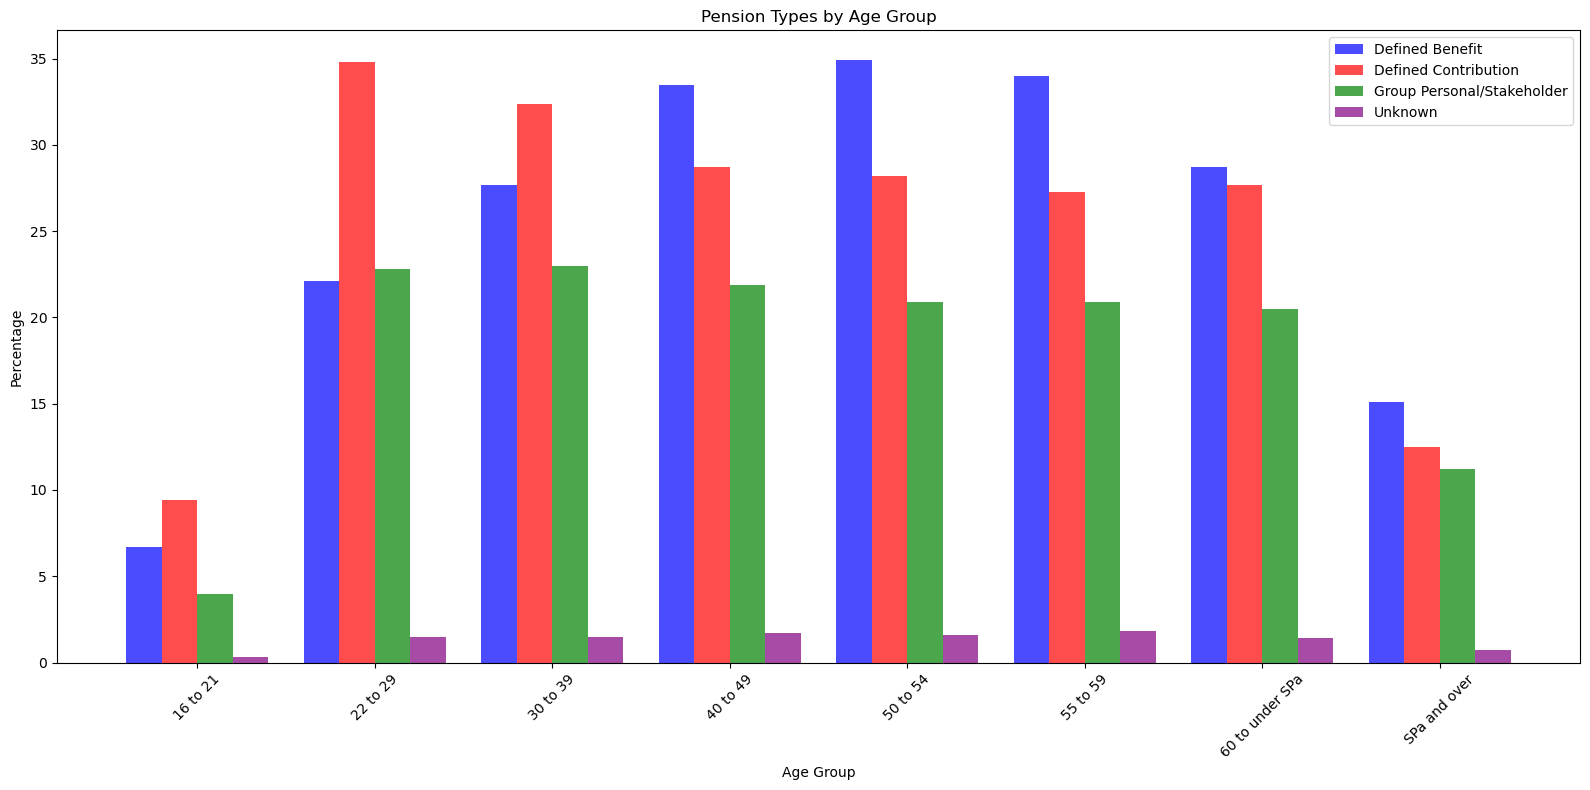

In [59]:
# Pension Types
plt.figure(figsize=(16, 8))
x = np.arange(len(pension_types_df['Age ']))
width = 0.2

plt.bar(x - 1.5*width, pension_types_df['Occupational defined benefit (%)'], width, label='Defined Benefit', color='blue', alpha=0.7)
plt.bar(x - 0.5*width, pension_types_df['Occupational defined contribution (%)'], width, label='Defined Contribution', color='red', alpha=0.7)
plt.bar(x + 0.5*width, pension_types_df['Group personal pension and group stakeholder (%)'], width, label='Group Personal/Stakeholder', color='green', alpha=0.7)
plt.bar(x + 1.5*width, pension_types_df['Unknown pension (%)'], width, label='Unknown', color='purple', alpha=0.7)

plt.title('Pension Types by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.legend()
plt.xticks(x, pension_types_df['Age '], rotation=45)
plt.tight_layout()
plt.show()

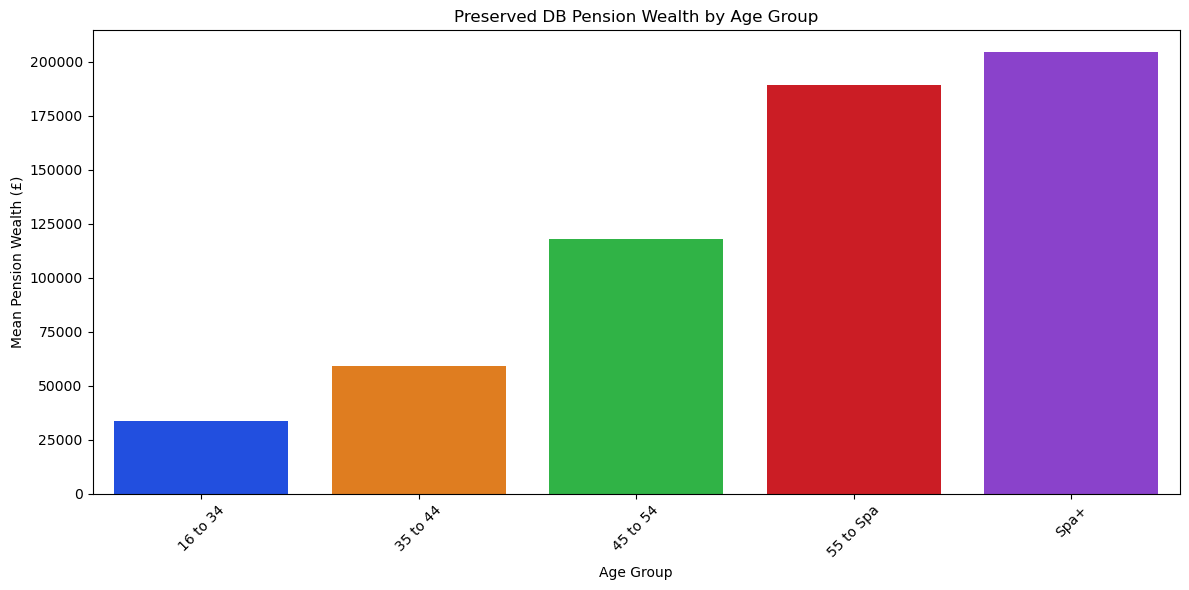

In [60]:
# Manually inputting the data
data = {
    'Year': ['2016-2018', '2016-2018', '2016-2018', '2016-2018', '2016-2018', '2012-2014', '2012-2014', '2012-2014', '2012-2014', '2012-2014'],
    'Age Band': ['16 to 34', '35 to 44', '45 to 54', '55 to Spa', 'Spa+', '16 to 34', '35 to 44', '45 to 54', '55 to Spa', 'Spa+'],
    'All employed both sexes Mean (£)': ['37,300', '70,500', '134,000', '204,800', '162,100', '30,300', '47,300', '101,400', '173,500', '246,400']
}

# Creating the DataFrame
df1 = pd.DataFrame(data)

# Convert the 'All employed both sexes Mean (£)' column to numeric, removing commas
df1['All employed both sexes Mean (£)'] = df1['All employed both sexes Mean (£)'].str.replace(',', '').astype(float)

sns.set_palette("bright")

# Plotting the data
plt.figure(figsize=(12, 6))
sns.barplot(x='Age Band', y='All employed both sexes Mean (£)', data=df1, ci=None)
plt.title('Preserved DB Pension Wealth by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Mean Pension Wealth (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

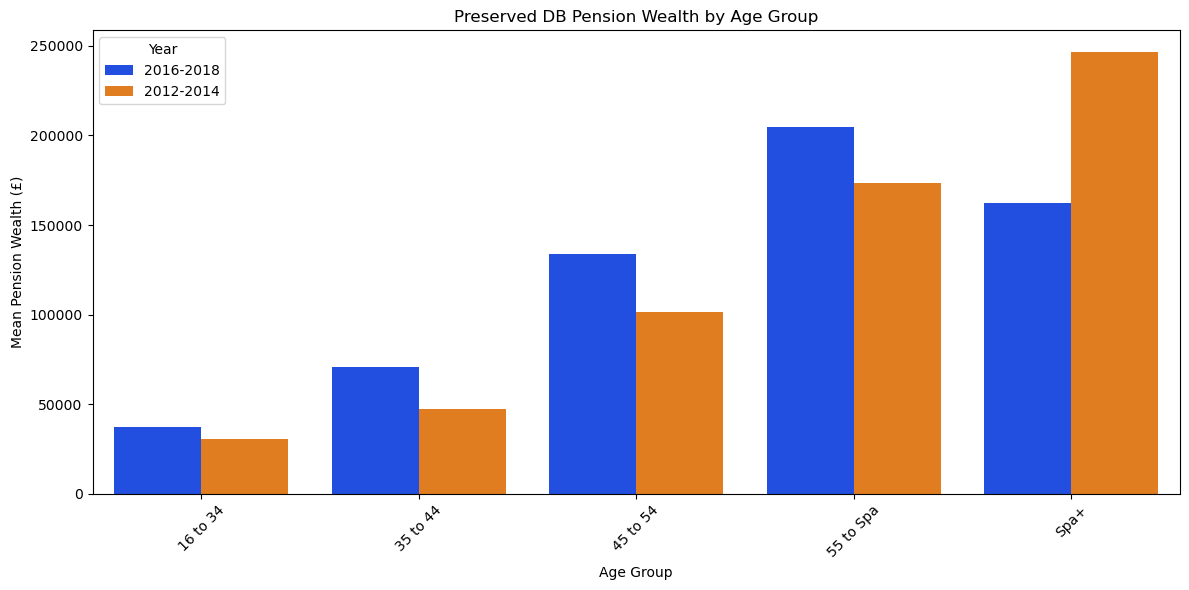

In [61]:
# Manually inputting the data
data = {
    'Year': ['2016-2018', '2016-2018', '2016-2018', '2016-2018', '2016-2018', '2012-2014', '2012-2014', '2012-2014', '2012-2014', '2012-2014'],
    'Age Band': ['16 to 34', '35 to 44', '45 to 54', '55 to Spa', 'Spa+', '16 to 34', '35 to 44', '45 to 54', '55 to Spa', 'Spa+'],
    'All employed both sexes Mean (£)': ['37,300', '70,500', '134,000', '204,800', '162,100', '30,300', '47,300', '101,400', '173,500', '246,400']
}

# Creating the DataFrame
df2 = pd.DataFrame(data)

# Convert the 'All employed both sexes Mean (£)' column to numeric, removing commas
df2['All employed both sexes Mean (£)'] = df2['All employed both sexes Mean (£)'].str.replace(',', '').astype(float)

# Set a vibrant color palette
sns.set_palette("bright")

# Plotting the data
plt.figure(figsize=(12, 6))
sns.barplot(x='Age Band', y='All employed both sexes Mean (£)', hue='Year', data=df2, ci=None)
plt.title('Preserved DB Pension Wealth by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Mean Pension Wealth (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

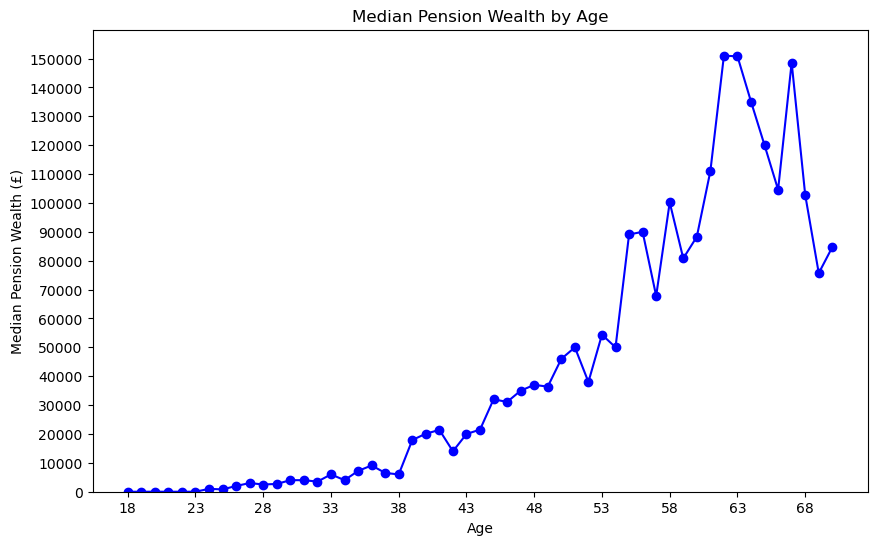

In [62]:
# Creating the dataframe with the provided data (issues with previous format so re-entering the data)
data = {
    'Age': list(range(18, 71)),
    'Median Pension Wealth (£)': [
        0, 0, 0, 0, 0, 0, 1000, 800, 2000, 3000, 2500, 2700, 4000, 4000, 3500, 6000, 4000, 7200, 9100, 6500, 6000, 
        17900, 20100, 21400, 14000, 20000, 21500, 32000, 31100, 35000, 37000, 36400, 46000, 50000, 38000, 54400, 
        50000, 89100, 90000, 67800, 100200, 80800, 88300, 111000, 151000, 150800, 135100, 120000, 104600, 148600, 
        102800, 75700, 84700
    ]
}

median_pension_wealth_df = pd.DataFrame(data)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(median_pension_wealth_df['Age'], median_pension_wealth_df['Median Pension Wealth (£)'], marker='o', linestyle='-', color='b')
plt.title('Median Pension Wealth by Age')
plt.xlabel('Age')
plt.ylabel('Median Pension Wealth (£)')
plt.xticks(range(18, 71, 5))
plt.yticks(range(0, 150001, 10000))  # Adjust y-axis ticks from 0 to 150000
plt.ylim(0, 160001)  # Set y-axis limits
plt.show()

# SIMULATION

In [63]:
# Monthly discount rates
monthly_rates = [0.054, 0.054, 0.054, 0.055, 0.057, 0.054, 0.054, 0.053, 0.051, 0.048, 0.049, 0.049,
                 0.045, 0.044, 0.044, 0.045, 0.041, 0.041, 0.039, 0.039, 0.037, 0.042, 0.041, 0.039]

# Convert to annual rates
def monthly_to_annual(monthly_rate):
    return (1 + monthly_rate/12)**12 - 1

annual_rates = [monthly_to_annual(r) for r in monthly_rates]

# Create a DataFrame with dates and rates
dates = pd.date_range(start='2018-04-01', periods=24, freq='M')
rates_df = pd.DataFrame({'Date': dates, 'Annual_Rate': annual_rates})

# Calculate the geometric mean for future projections
avg_annual_rate = np.prod(np.array(annual_rates) + 1)**(1/len(annual_rates)) - 1

print(f"Average annual rate for future projections: {avg_annual_rate:.4f}")

Average annual rate for future projections: 0.0481


In [64]:
# 1. Historical Improvement Analysis 

# Filter the data for the years 1980-2020
df_filtered = df[(df['Year'] >= 1980) & (df['Year'] <= 2020)]

def calculate_mortality_improvements(df):
    df_sorted = df.sort_values(['Age', 'Year'])
    df_sorted['Mortality_Improvement'] = df_sorted.groupby('Age')['total_mortality_rate'].pct_change() * -1
    df_sorted = df_sorted[~df_sorted['Mortality_Improvement'].isin([np.inf, -np.inf])]
    df_sorted = df_sorted.dropna(subset=['Mortality_Improvement'])
    return df_sorted

df_imp = calculate_mortality_improvements(df_filtered)

# Average mortality improvement (base shock)
base_shock = df_imp['Mortality_Improvement'].mean()
print(f"Average mortality improvement (base shock): {base_shock:.6f}")

# Difference between min and max mortality improvement (age factor)
age_factor = df_imp['Mortality_Improvement'].max() - df_imp['Mortality_Improvement'].min()
print(f"Difference between min and max mortality improvement (age factor): {age_factor:.6f}")

# Standard deviation of historical data improvements (base standard deviation)
base_standard_deviation = df_imp['Mortality_Improvement'].std()
print(f"Standard deviation of historical data improvements (base standard deviation): {base_standard_deviation:.6f}")

# Mean annual mortality improvement (mu_hist)
mu_hist = df_imp.groupby('Year')['Mortality_Improvement'].mean().mean()
print(f"Mean annual mortality improvement (mu_hist): {mu_hist:.6f}")

Average mortality improvement (base shock): 0.009321
Difference between min and max mortality improvement (age factor): 3.440000
Standard deviation of historical data improvements (base standard deviation): 0.107090
Mean annual mortality improvement (mu_hist): 0.009332


  Age_Group  Avg_Improvement
0      0-20         0.022693
1     21-40         0.005720
2     41-60         0.012258
3     61-80         0.016070
4    81-110        -0.004151
Trend: Slope = -0.00036113086019634523, Intercept = 0.731774472279959
GEV parameters - Shape: -0.3717953046123069, Location: 0.15373677944077735, Scale: 0.04997457726102106


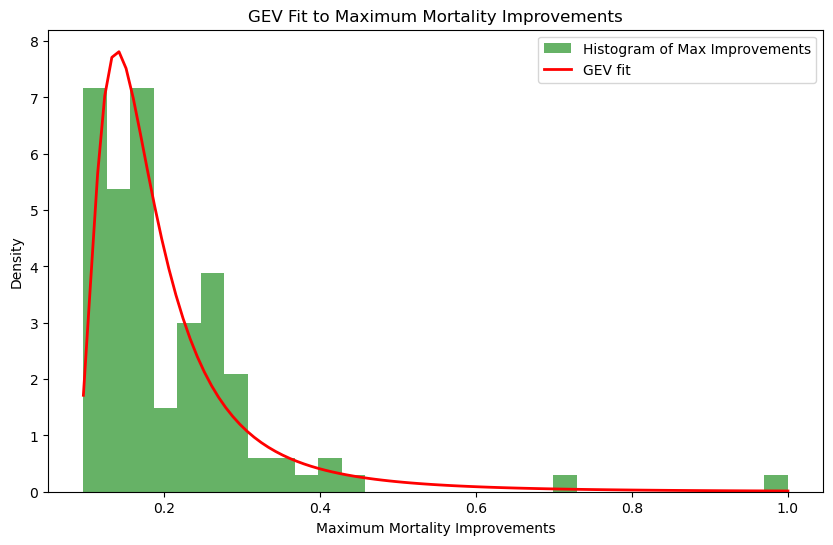

KS Test Statistic: 0.08216591640327608
KS Test p-value: 0.4193719349376265


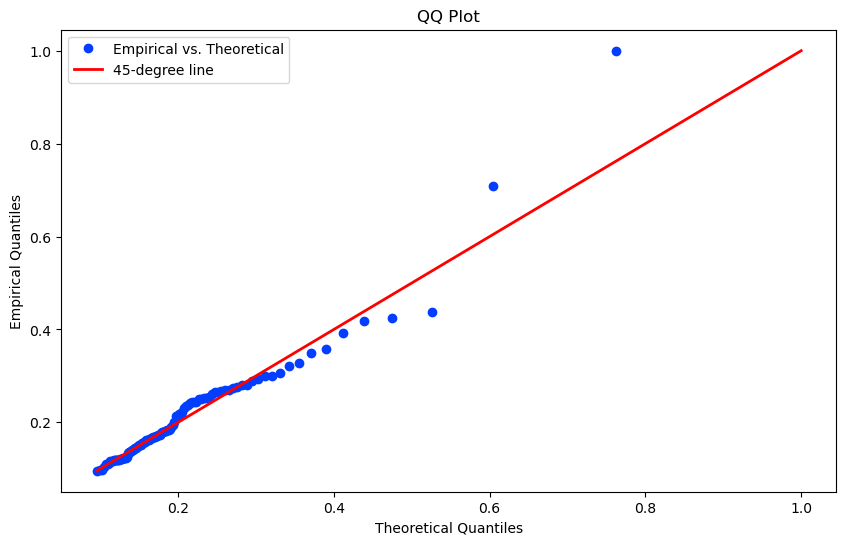

   shock_multiplier        VaR_95       CVaR_95
0               0.8  4.732728e+07  4.733832e+07
1               0.9  4.736967e+07  4.737907e+07
2               1.0  4.740397e+07  4.741172e+07
3               1.1  4.743111e+07  4.743800e+07
4               1.2  4.745292e+07  4.745927e+07


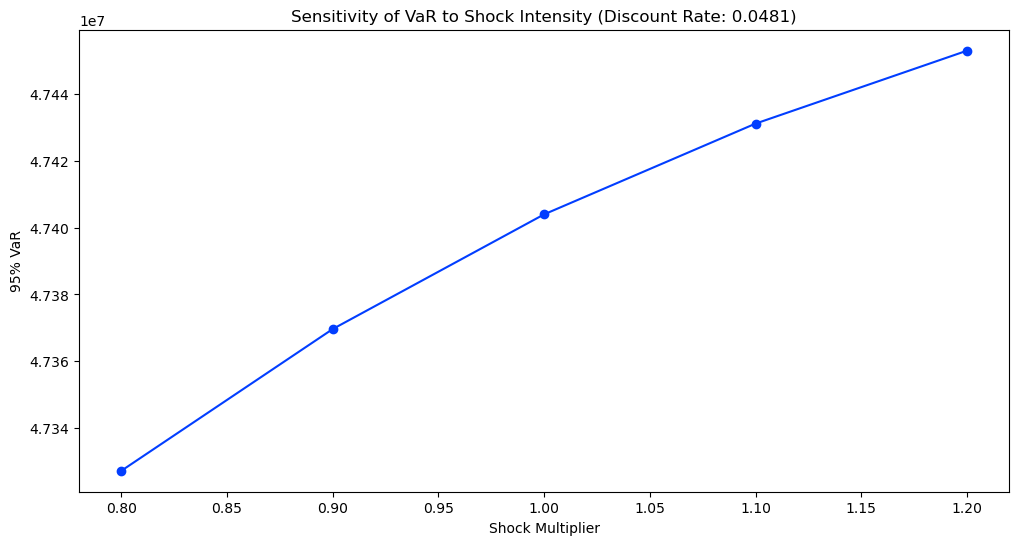

Final 95% VaR: £47,403,220
Final 95% CVaR: £47,411,113


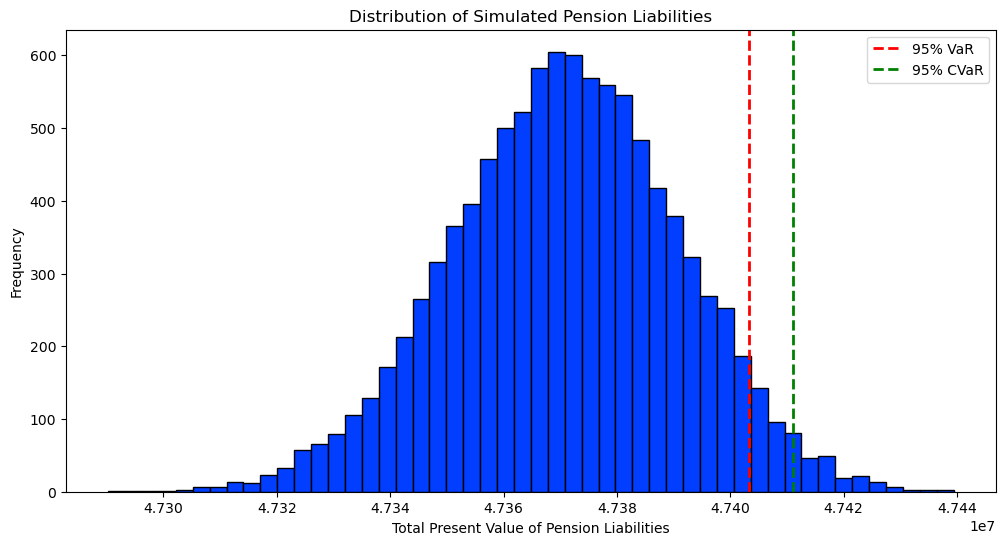

Age group 18-30:
  Base liability: £319,257
  Average simulated liability: £328,908
  Potential increase: 3.02%

Age group 31-50:
  Base liability: £7,611,058
  Average simulated liability: £7,825,374
  Potential increase: 2.82%

Age group 51-65:
  Base liability: £27,760,220
  Average simulated liability: £28,510,657
  Potential increase: 2.70%

Age group 66-100:
  Base liability: £10,432,788
  Average simulated liability: £10,705,343
  Potential increase: 2.61%



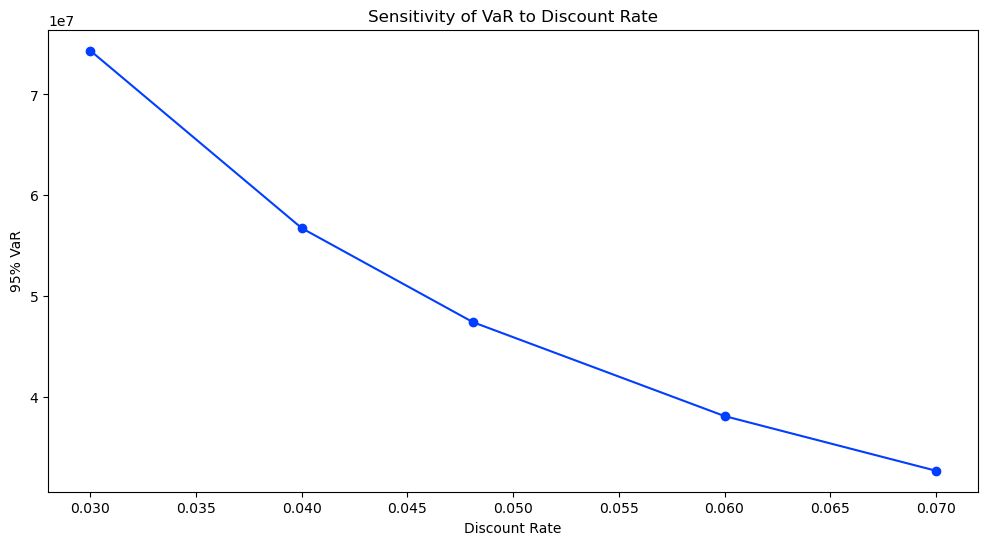

In [65]:
# 2. Age-Dependent Patterns
age_groups = [(0, 20), (21, 40), (41, 60), (61, 80), (81, 110)]

def analyze_age_patterns(df_imp):
    age_pattern = []
    for start, end in age_groups:
        avg_imp = df_imp[(df_imp['Age'] >= start) & (df_imp['Age'] <= end)]['Mortality_Improvement'].mean()
        age_pattern.append((f"{start}-{end}", avg_imp))
    return pd.DataFrame(age_pattern, columns=['Age_Group', 'Avg_Improvement'])

age_pattern_df = analyze_age_patterns(df_imp)
print(age_pattern_df)

# 3. Trend Analysis
def analyze_trend(df_imp):
    yearly_avg = df_imp.groupby('Year')['Mortality_Improvement'].mean()
    trend = np.polyfit(yearly_avg.index, yearly_avg.values, 1)
    return trend

trend = analyze_trend(df_imp)
print(f"Trend: Slope = {trend[0]}, Intercept = {trend[1]}")

# 4. Extreme Value Analysis
def extreme_value_analysis(df_imp):
    max_improvements = df_imp.groupby('Age')['Mortality_Improvement'].max()
    params = genextreme.fit(max_improvements)
    shape, loc, scale = params
    print(f"GEV parameters - Shape: {shape}, Location: {loc}, Scale: {scale}")
    return params, max_improvements

extreme_params, max_improvements = extreme_value_analysis(df_imp)

# Visualize the GEV fit
def plot_gev_fit(params, data):
    shape, loc, scale = params
    x = np.linspace(min(data), max(data), 100)
    y = genextreme.pdf(x, shape, loc=loc, scale=scale)
    
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Histogram of Max Improvements')
    plt.plot(x, y, 'r-', lw=2, label='GEV fit')
    plt.xlabel('Maximum Mortality Improvements')
    plt.ylabel('Density')
    plt.title('GEV Fit to Maximum Mortality Improvements')
    plt.legend()
    plt.show()

plot_gev_fit(extreme_params, max_improvements)

# 5. Model Validation

# Goodness-of-Fit Test: Kolmogorov-Smirnov Test
def goodness_of_fit_test(params, data):
    shape, loc, scale = params
    d_stat, p_value = kstest(data, 'genextreme', args=(shape, loc, scale))
    print(f"KS Test Statistic: {d_stat}")
    print(f"KS Test p-value: {p_value}")

goodness_of_fit_test(extreme_params, max_improvements)

# QQ Plot
def plot_qq(params, data):
    shape, loc, scale = params
    quantiles = np.linspace(0.01, 0.99, len(data))
    theoretical_quantiles = genextreme.ppf(quantiles, shape, loc=loc, scale=scale)
    empirical_quantiles = np.sort(data)
    
    plt.figure(figsize=(10, 6))
    
    # Plot the QQ plot
    plt.plot(theoretical_quantiles, empirical_quantiles, 'o', label='Empirical vs. Theoretical')
    
    # Plot the y=x line (45-degree line)
    plt.plot([min(empirical_quantiles), max(empirical_quantiles)], 
             [min(empirical_quantiles), max(empirical_quantiles)], 
             'r-', lw=2, label='45-degree line')
    
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Empirical Quantiles')
    plt.title('QQ Plot')
    plt.legend()
    plt.show()
    
plot_qq(extreme_params, max_improvements)

# 6. Gendered Lee-Carter model implementation
# Fit Lee-Carter model for both genders
a_x_male, b_x_male, k_t_male = fit_lee_carter_male_or_female(df_male)
a_x_female, b_x_female, k_t_female = fit_lee_carter_male_or_female(df_female)

# Forecast k_t using ARIMA for both genders
model_male = ARIMA(k_t_male, order=(0,1,0))
results_male = model_male.fit()
k_t_forecast_male = results_male.forecast(steps=30)  # Forecast for next 30 years

model_female = ARIMA(k_t_female, order=(1,1,1))
results_female = model_female.fit()
k_t_forecast_female = results_female.forecast(steps=30)  # Forecast for next 30 years

# Combine historical and forecasted k_t
k_t_combined_male = np.concatenate([k_t_male, k_t_forecast_male])
k_t_combined_female = np.concatenate([k_t_female, k_t_forecast_female])

# Calculate mortality rates
years = np.arange(1980, 2051)
ages = df_male['Age'].unique()
mortality_rates_male = np.exp(a_x_male[:, np.newaxis] + np.outer(b_x_male, k_t_combined_male))
mortality_rates_female = np.exp(a_x_female[:, np.newaxis] + np.outer(b_x_female, k_t_combined_female))

# Calculate life expectancies
def calculate_life_expectancy(mortality_rates):
    survival_prob = 1 - mortality_rates
    cumulative_survival = np.cumprod(survival_prob, axis=0)
    life_expectancy = np.sum(cumulative_survival, axis=0)
    return life_expectancy

life_expectancy_male = calculate_life_expectancy(mortality_rates_male)
life_expectancy_female = calculate_life_expectancy(mortality_rates_female)


# Calculate male and female populations by year
male_population = df_male.groupby('Year')['population'].sum().values
female_population = df_female.groupby('Year')['population'].sum().values

# Ensure that life expectancy arrays have the same shape
min_length = min(len(life_expectancy_male), len(life_expectancy_female), len(male_population), len(female_population))

# Truncate arrays to the minimum length
life_expectancy_male = life_expectancy_male[:min_length]
life_expectancy_female = life_expectancy_female[:min_length]
male_population = male_population[:min_length]
female_population = female_population[:min_length]

# Combine life expectancies
def combine_life_expectancies(male_life_expectancy, female_life_expectancy, male_population, female_population):
    total_population = male_population + female_population
    male_weight = male_population / total_population
    female_weight = female_population / total_population
    return male_weight * male_life_expectancy + female_weight * female_life_expectancy

life_expectancy_combined = combine_life_expectancies(life_expectancy_male, life_expectancy_female, male_population, female_population)


# Create a DataFrame with ages and life expectancies
life_exp_df = pd.DataFrame({
    'Age': ages[:min_length], 
    'Life_Expectancy_Male': life_expectancy_male,
    'Life_Expectancy_Female': life_expectancy_female,
    'Life_Expectancy_Combined': life_expectancy_combined
})



# 7. Combine with Pension Data and Present Value Calculation
min_length = min(len(life_expectancy_male), len(life_expectancy_female), len(life_expectancy_combined), len(ages))

# Truncate all arrays to the minimum length
life_expectancy_male = life_expectancy_male[:min_length]
life_expectancy_female = life_expectancy_female[:min_length]
life_expectancy_combined = life_expectancy_combined[:min_length]
ages = ages[:min_length]

# Create a DataFrame with ages and life expectancies
life_exp_df = pd.DataFrame({
    'Age': ages,
    'Life_Expectancy_Male': life_expectancy_male,
    'Life_Expectancy_Female': life_expectancy_female,
    'Life_Expectancy_Combined': life_expectancy_combined
})

def present_value(amount, years, discount_rate):
    return amount * (1 - (1 + discount_rate)**-years) / discount_rate

discount_rate = 0.0481  
combined_data = pd.merge(median_pension_wealth_df, life_exp_df, on='Age', how='left')
combined_data = combined_data.dropna()

combined_data['PV_Pension'] = combined_data.apply(
    lambda row: present_value(row['Median Pension Wealth (£)'], row['Life_Expectancy_Combined'], discount_rate),
    axis=1)

# 8. Longevity risk simulation with GEV and truncated normal distribution
def simulate_longevity_risk_with_combined_shocks(data, gev_params, discount_rate, shock_multiplier=1.0, num_simulations=1000):
    np.random.seed(42)  # Set the random seed for reproducibility
    shape, loc, scale = gev_params
    results = []
    for _ in range(num_simulations):
        simulated_data = data.copy()
        age_dependent_shocks = np.zeros(len(simulated_data))
        for i, age in enumerate(simulated_data['Age']):
            mean_shock = 0.0092 + (age / 110) * 3.4400
            std_dev_shock = 0.1070 * (1 + age / 110)
            
            a, b = (-0.03 - mean_shock) / std_dev_shock, (0.05 - mean_shock) / std_dev_shock
            base_shock = truncnorm.rvs(a, b, loc=mean_shock, scale=std_dev_shock)
            
            extreme_shock = genextreme.rvs(shape, loc=loc, scale=scale)
            
            shock = base_shock + extreme_shock
            age_factor_adjustment = (1 + 3.4400 * (age / 110))
            age_dependent_shocks[i] = max(0, (shock * age_factor_adjustment) * shock_multiplier)
        
        simulated_data['Simulated_Life_Expectancy'] = simulated_data['Life_Expectancy_Combined'] * (1 + age_dependent_shocks)
        simulated_data['Simulated_PV_Pension'] = simulated_data.apply(
            lambda row: present_value(row['Median Pension Wealth (£)'], row['Simulated_Life_Expectancy'], discount_rate),
            axis=1)
        results.append(simulated_data['Simulated_PV_Pension'].sum())
    return results

# 9. Sensitivity Analysis
def sensitivity_analysis(data, gev_params, base_discount_rate, shock_multipliers, num_simulations=1000):
    results = []
    for shock_multiplier in shock_multipliers:
        simulation_results = simulate_longevity_risk_with_combined_shocks(data, gev_params, base_discount_rate, shock_multiplier, num_simulations)
        VaR_95 = np.percentile(simulation_results, 95)
        CVaR_95 = np.mean([x for x in simulation_results if x > VaR_95])
        results.append({
            'shock_multiplier': shock_multiplier,
            'VaR_95': VaR_95,
            'CVaR_95': CVaR_95
        })
    return pd.DataFrame(results)

base_discount_rate = 0.0481
shock_multipliers = [0.8, 0.9, 1.0, 1.1, 1.2]
sensitivity_results = sensitivity_analysis(combined_data, extreme_params, base_discount_rate, shock_multipliers)
print(sensitivity_results)

# Visualise sensitivity results
plt.figure(figsize=(12, 6))
plt.plot(sensitivity_results['shock_multiplier'], sensitivity_results['VaR_95'], marker='o')
plt.xlabel('Shock Multiplier')
plt.ylabel('95% VaR')
plt.title(f'Sensitivity of VaR to Shock Intensity (Discount Rate: {base_discount_rate:.4f})')
plt.show()

# 10. Final Simulation
final_simulation_results = simulate_longevity_risk_with_combined_shocks(combined_data, extreme_params, base_discount_rate, num_simulations=10000)

final_VaR_95 = np.percentile(final_simulation_results, 95)
final_CVaR_95 = np.mean([x for x in final_simulation_results if x > final_VaR_95])

print(f"Final 95% VaR: £{final_VaR_95:,.0f}")
print(f"Final 95% CVaR: £{final_CVaR_95:,.0f}")

# Visualise final simulation results
plt.figure(figsize=(12, 6))
plt.hist(final_simulation_results, bins=50, edgecolor='black')
plt.axvline(final_VaR_95, color='r', linestyle='dashed', linewidth=2, label='95% VaR')
plt.axvline(final_CVaR_95, color='g', linestyle='dashed', linewidth=2, label='95% CVaR')
plt.title('Distribution of Simulated Pension Liabilities')
plt.xlabel('Total Present Value of Pension Liabilities')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 11. Analyse Impact on Different Age Groups
def analyze_age_groups(data, age_groups, gev_params, discount_rate):
    for start, end in age_groups:
        group_data = data[(data['Age'] >= start) & (data['Age'] <= end)].copy()
        base_liability = group_data['PV_Pension'].sum()
        simulation_results = simulate_longevity_risk_with_combined_shocks(group_data, gev_params, discount_rate, num_simulations=1000)
        
        avg_simulated_liability = np.mean(simulation_results)
        increase = (avg_simulated_liability - base_liability) / base_liability * 100
        
        print(f"Age group {start}-{end}:")
        print(f"  Base liability: £{base_liability:,.0f}")
        print(f"  Average simulated liability: £{avg_simulated_liability:,.0f}")
        print(f"  Potential increase: {increase:.2f}%\n")

age_groups = [(18, 30), (31, 50), (51, 65), (66, 100)]
analyze_age_groups(combined_data, age_groups, extreme_params, base_discount_rate)

# 12. Discount Rate Sensitivity
discount_rates = [0.03, 0.04, 0.0481, 0.06, 0.07]
discount_sensitivity = []

for rate in discount_rates:
    simulation_results = simulate_longevity_risk_with_combined_shocks(combined_data, extreme_params, rate, num_simulations=1000)
    VaR_95 = np.percentile(simulation_results, 95)
    CVaR_95 = np.mean([x for x in simulation_results if x > VaR_95])
    discount_sensitivity.append({
        'discount_rate': rate,
        'VaR_95': VaR_95,
        'CVaR_95': CVaR_95
    })

discount_sensitivity_df = pd.DataFrame(discount_sensitivity)

# Visualise discount rate sensitivity
plt.figure(figsize=(12, 6))
plt.plot(discount_sensitivity_df['discount_rate'], discount_sensitivity_df['VaR_95'], marker='o')
plt.xlabel('Discount Rate')
plt.ylabel('95% VaR')
plt.title('Sensitivity of VaR to Discount Rate')
plt.show()


In [66]:
mean_result = np.mean(final_simulation_results)

In [67]:
mean_result

47370821.81387911

Text(0, 0.5, 'Average Improvement')

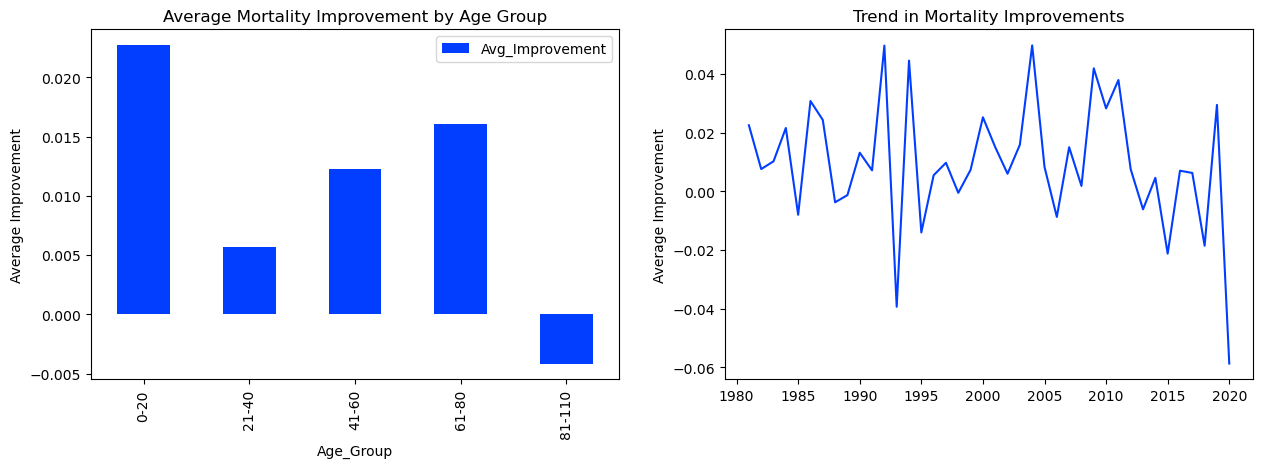

In [68]:
# Plotting results
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
age_pattern_df.plot(x='Age_Group', y='Avg_Improvement', kind='bar', ax=plt.gca())
plt.title('Average Mortality Improvement by Age Group')
plt.ylabel('Average Improvement')

plt.subplot(2, 2, 2)
plt.plot(df_imp.groupby('Year')['Mortality_Improvement'].mean())
plt.title('Trend in Mortality Improvements')
plt.ylabel('Average Improvement')